In [1]:
import pysam
import numpy as np
import cPickle as pickle

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from collections import Counter
import matplotlib.pyplot as plt

In [4]:
import pandas as pd
from random import shuffle, sample
from itertools import islice

In [5]:
import glob, os

In [6]:
import logging
logging.basicConfig(level=logging.INFO)

In [7]:
def umi_gene_db(in_file):
    
    st = pysam.AlignmentFile(in_file,"rb")
    st.reset()
    reads = st.fetch(until_eof=True)
    
    l = []
    for r in reads:
        if r.has_tag('NH') and r.get_tag('NH') == 1 and r.has_tag('GE'):
            ge = r.get_tag('GE')
            xm = r.get_tag('XM')
            #ref = r.reference_name
            start = r.reference_start
            xg = xm + ':' + ge
            l.append((xg,start))
    ldf = pd.DataFrame(l, columns=['XG','POS'])
    ldg = ldf.groupby(['XG'])['POS']
    l = []
    for xg, group in ldg:
        if not len(group) == 1 :
            for pos in list(group):
                l.append(xg + ':' + str(pos))
    
    return l

In [8]:
def psplit(a):
    
    splt = a.rfind(':')
    pos = a[splt + 1 :]
    xg = a[: splt ]
    return xg, pos

In [9]:
def different_positions(samples):
    
    psamples = [psplit(item) for item in samples]
    dist = []
    df = pd.DataFrame(psamples, columns = ['XG','POS'])
    for xg, pos in df.groupby(['XG'])['POS']:
        if not len(pos)==1:
            dist.append(len(set(pos)))
    
    return dist

In [10]:
def plot_sat_curve(in_file, plot_data, step_size, sample ='', out_file_prefix=''):
    
    medianprops = dict(linewidth=2.5, color='r')

    x = [i for i,j in plot_data]
    box_data = [j for i,j in plot_data]

    fig = plt.figure(figsize=(25,20))
    plt.boxplot(box_data, sym='g', medianprops = medianprops)
    
    locs, labels = plt.xticks()
    labels = [format(item ,',') for item in x]
    ax = plt.subplot(1, 1, 1)
    ax.yaxis.grid()
    plt.xticks(locs, labels, fontsize = 16, rotation='vertical')
    plt.yticks(range(0,10,1),fontsize = 16)
    plt.ylim(0,50)
    plt.xlabel('Number of unique annotated reads in sample ' + in_file , fontsize=20, labelpad=25)
    plt.ylabel('Number of disctinct positions per molecule', fontsize=20, labelpad=25)
    out_file = out_file_prefix + in_file + '.png'
    plt.savefig(out_file)

In [11]:
def compute_saturation(in_file, step_size):
    
    db = umi_gene_db(in_file)
    shuffle(db)
    samples = []
    
    sat_plot_data = []
    for i in range(0, len(db), step_size):
        new_slice = [item for item in islice(db , i, i + step_size)]
        samples += new_slice
        dist = different_positions(samples)
        sat_plot_data.append((i + step_size, dist))
        
    plot_sat_curve(in_file, sat_plot_data, step_size)

In [12]:
def manual_sample(lst):
    
    db = []
    dc = {}
    samples = []
    for item in lst:
        xg, pos = psplit(item)
        if not xg in dc:
            dc.update({xg:pos})
        else:
            db.append(item)

    for key, value in dc.items():
        samples.append(key + ':' + value)
        
    return samples, db

In [13]:
def compute_step_saturation(in_file, step_size, out_file_prefix=''):
    
    db = umi_gene_db(in_file)

    base, pool = manual_sample(db)
    shuffle(pool)
   
    sat_plot_data = []
    samples = base
    
    for i in range(len(base) , len(pool), step_size):
        new_slice = [item for item in islice(pool , i, i + step_size)]
        samples += new_slice
        dist = different_positions(samples)
        sat_plot_data.append((i + step_size, dist))
        
    plot_sat_curve(in_file, sat_plot_data, step_size, out_file_prefix=out_file_prefix)

CPU times: user 58.7 s, sys: 449 ms, total: 59.2 s
Wall time: 59.2 s


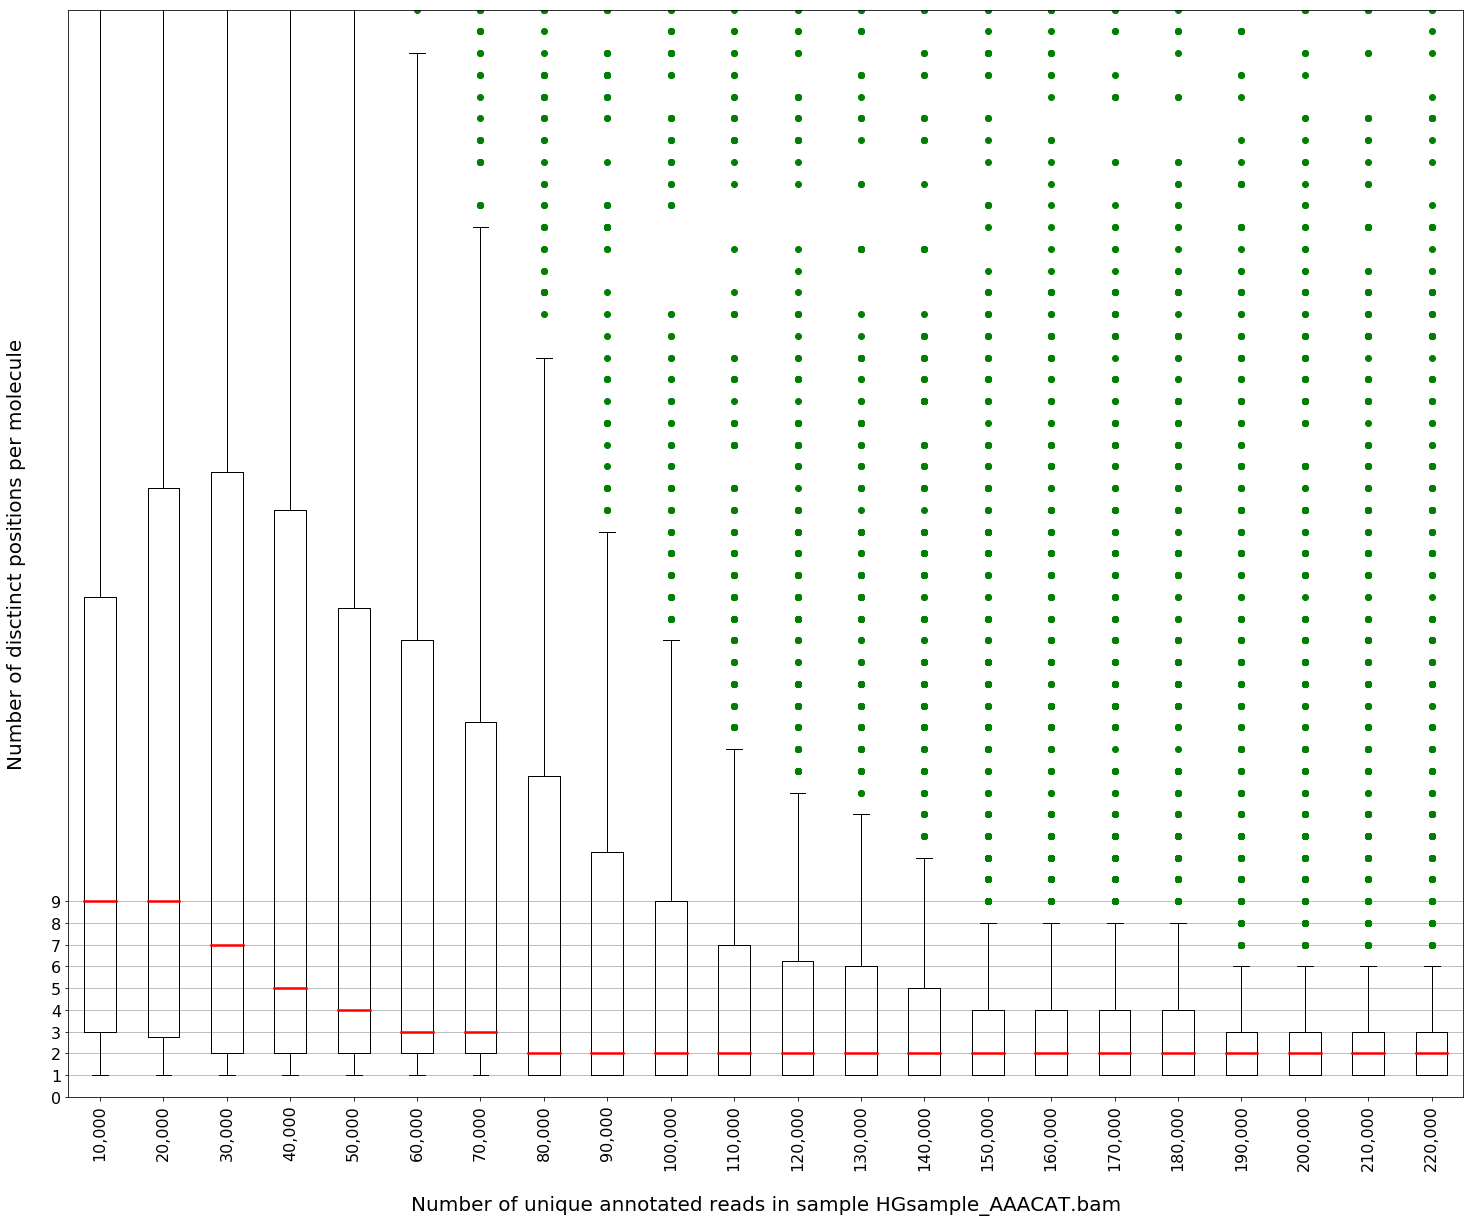

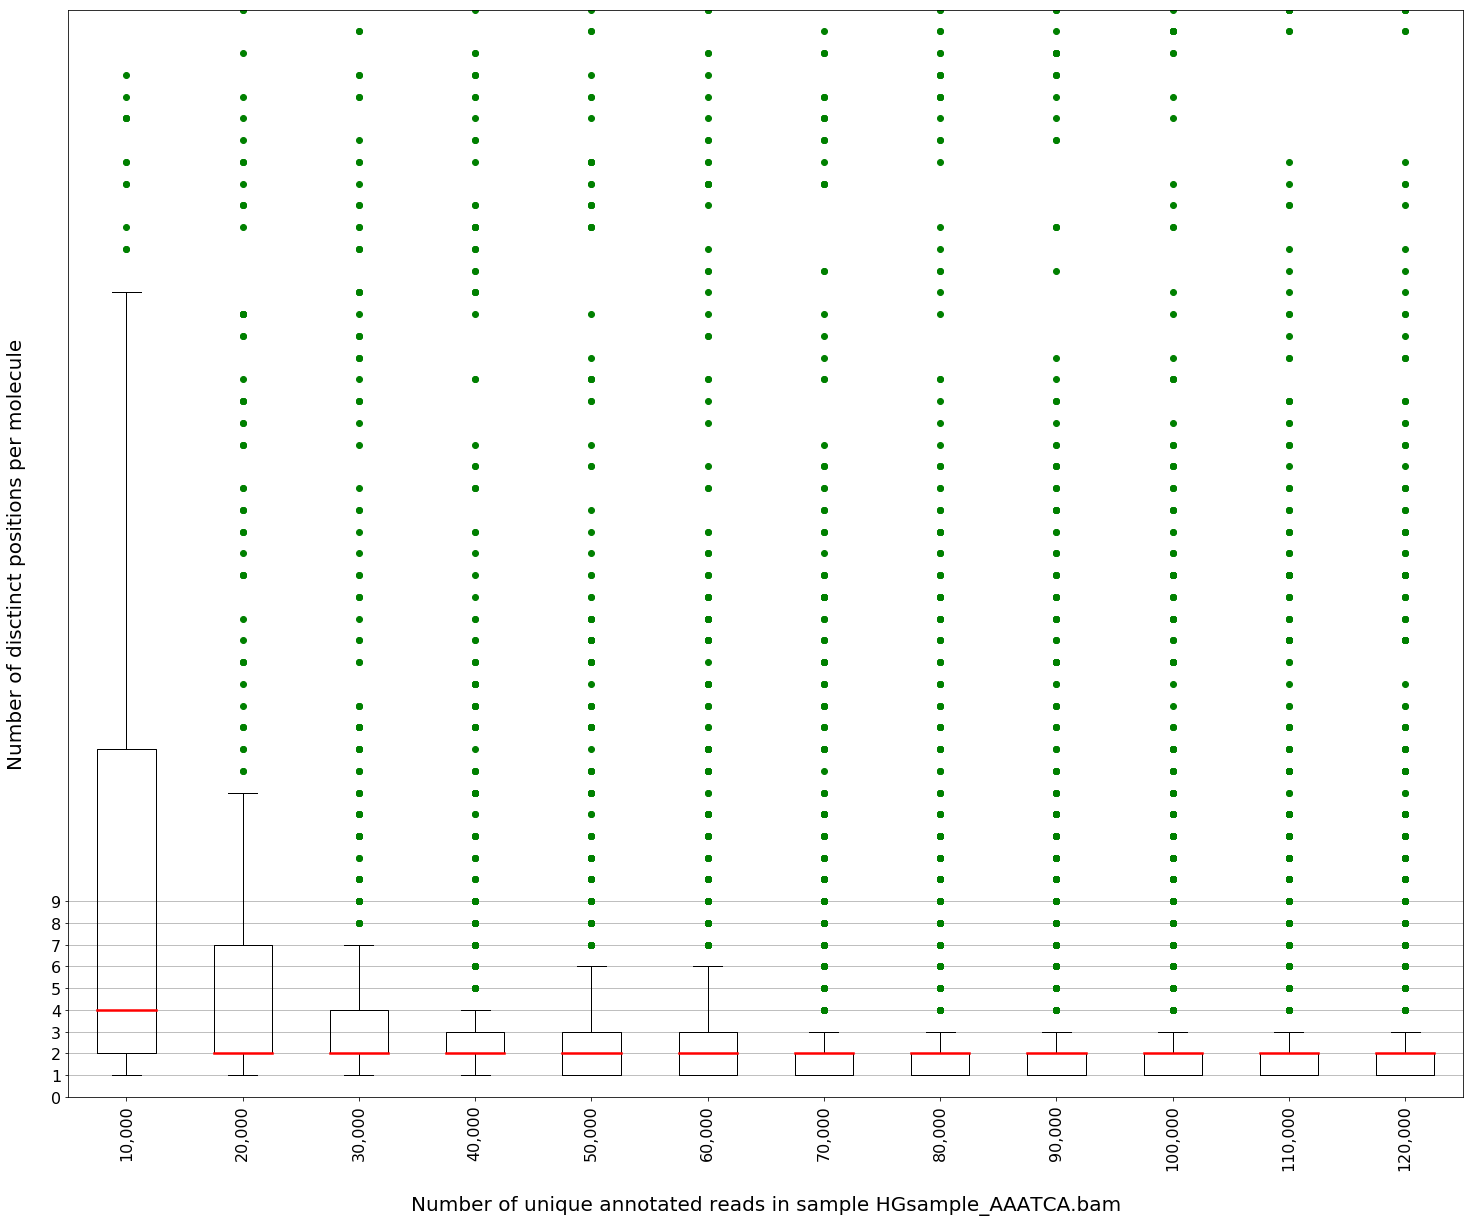

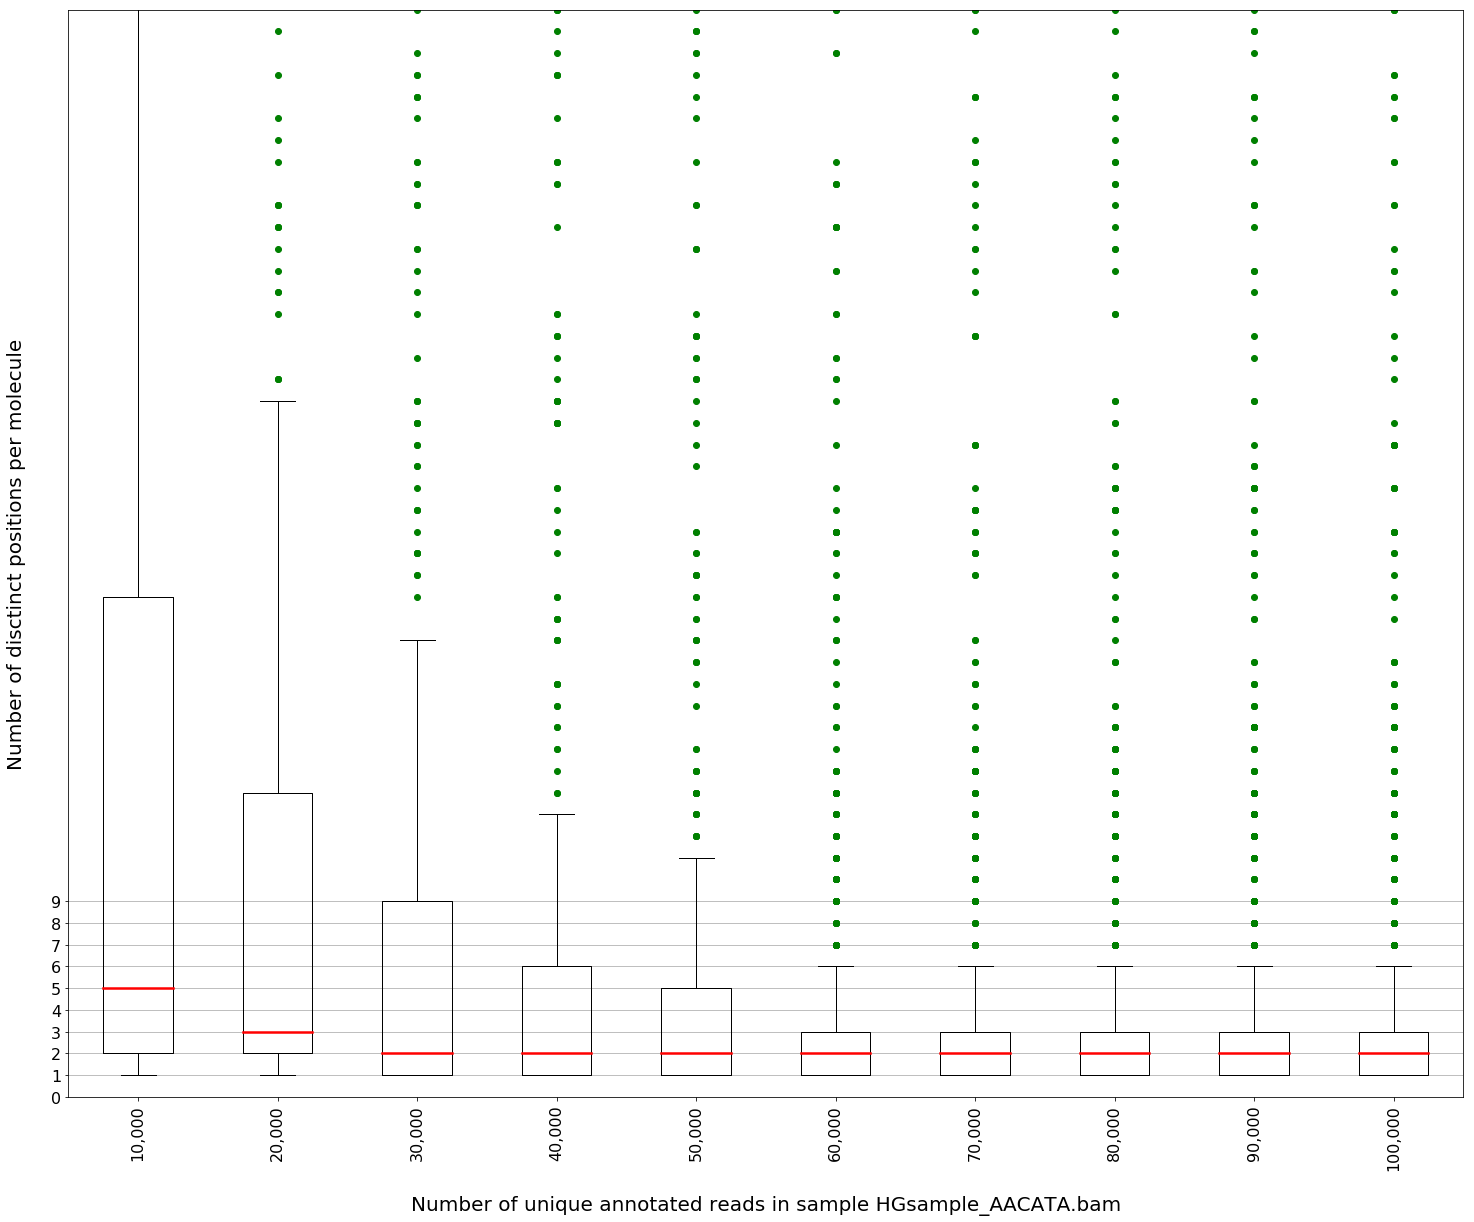

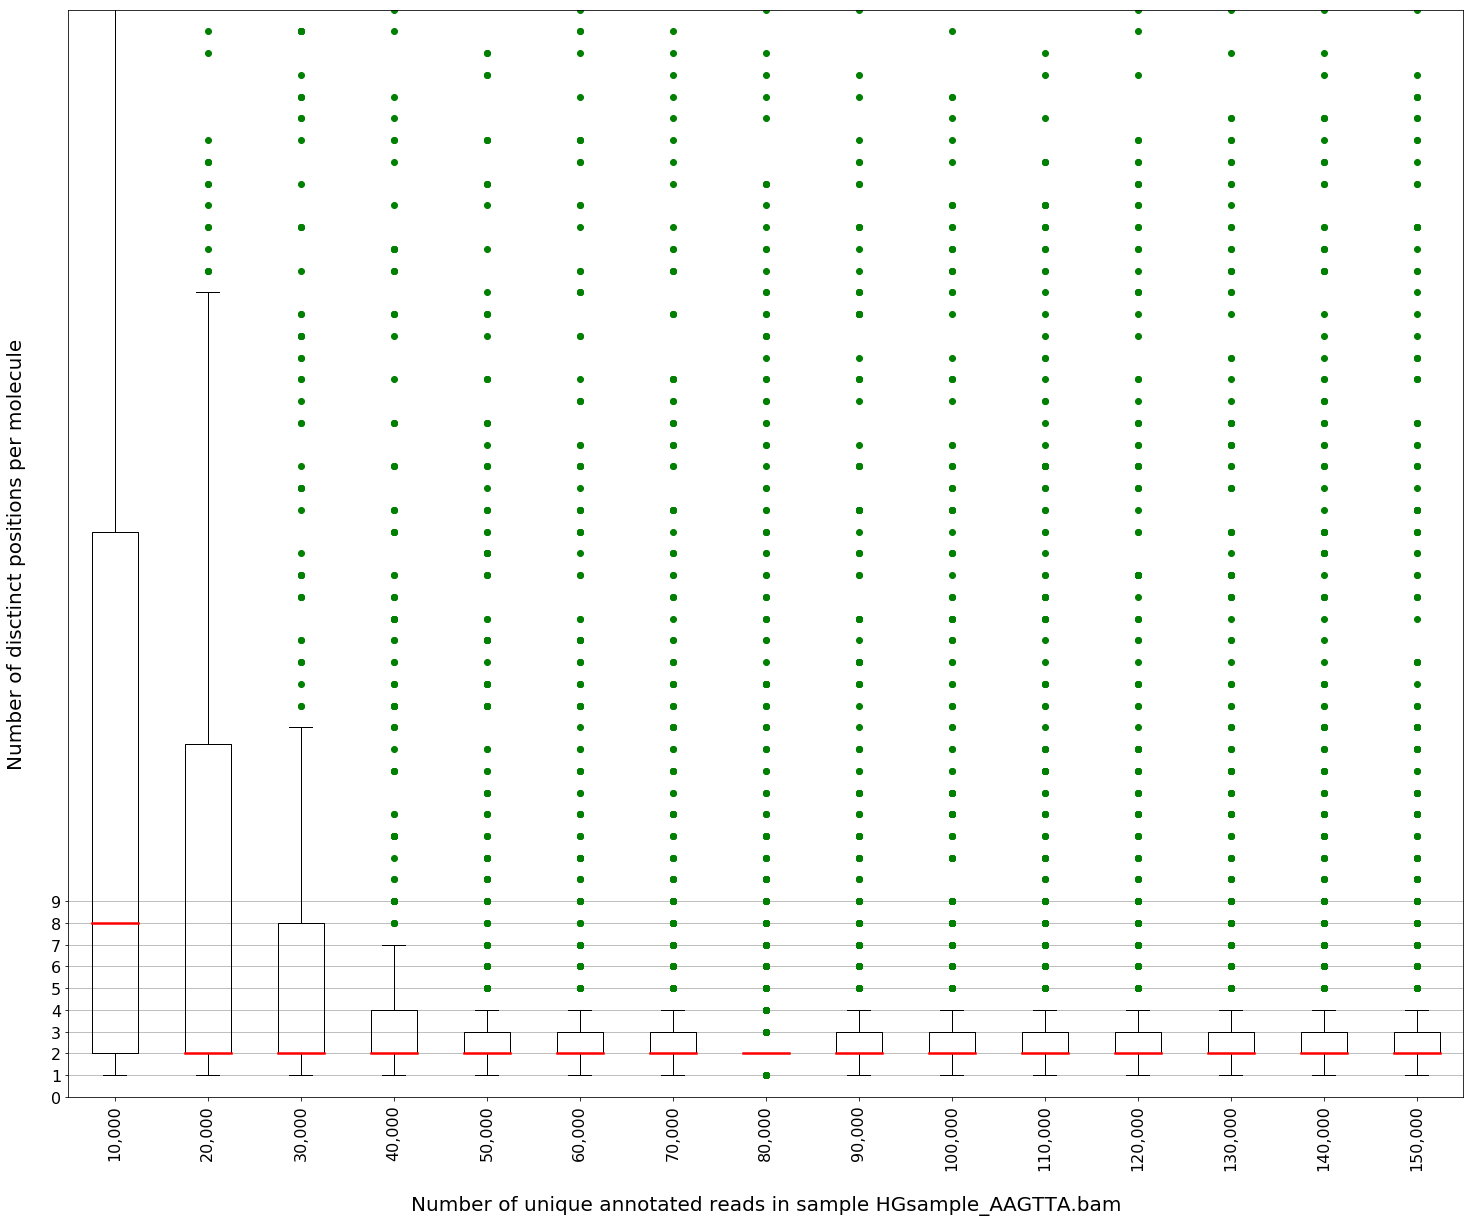

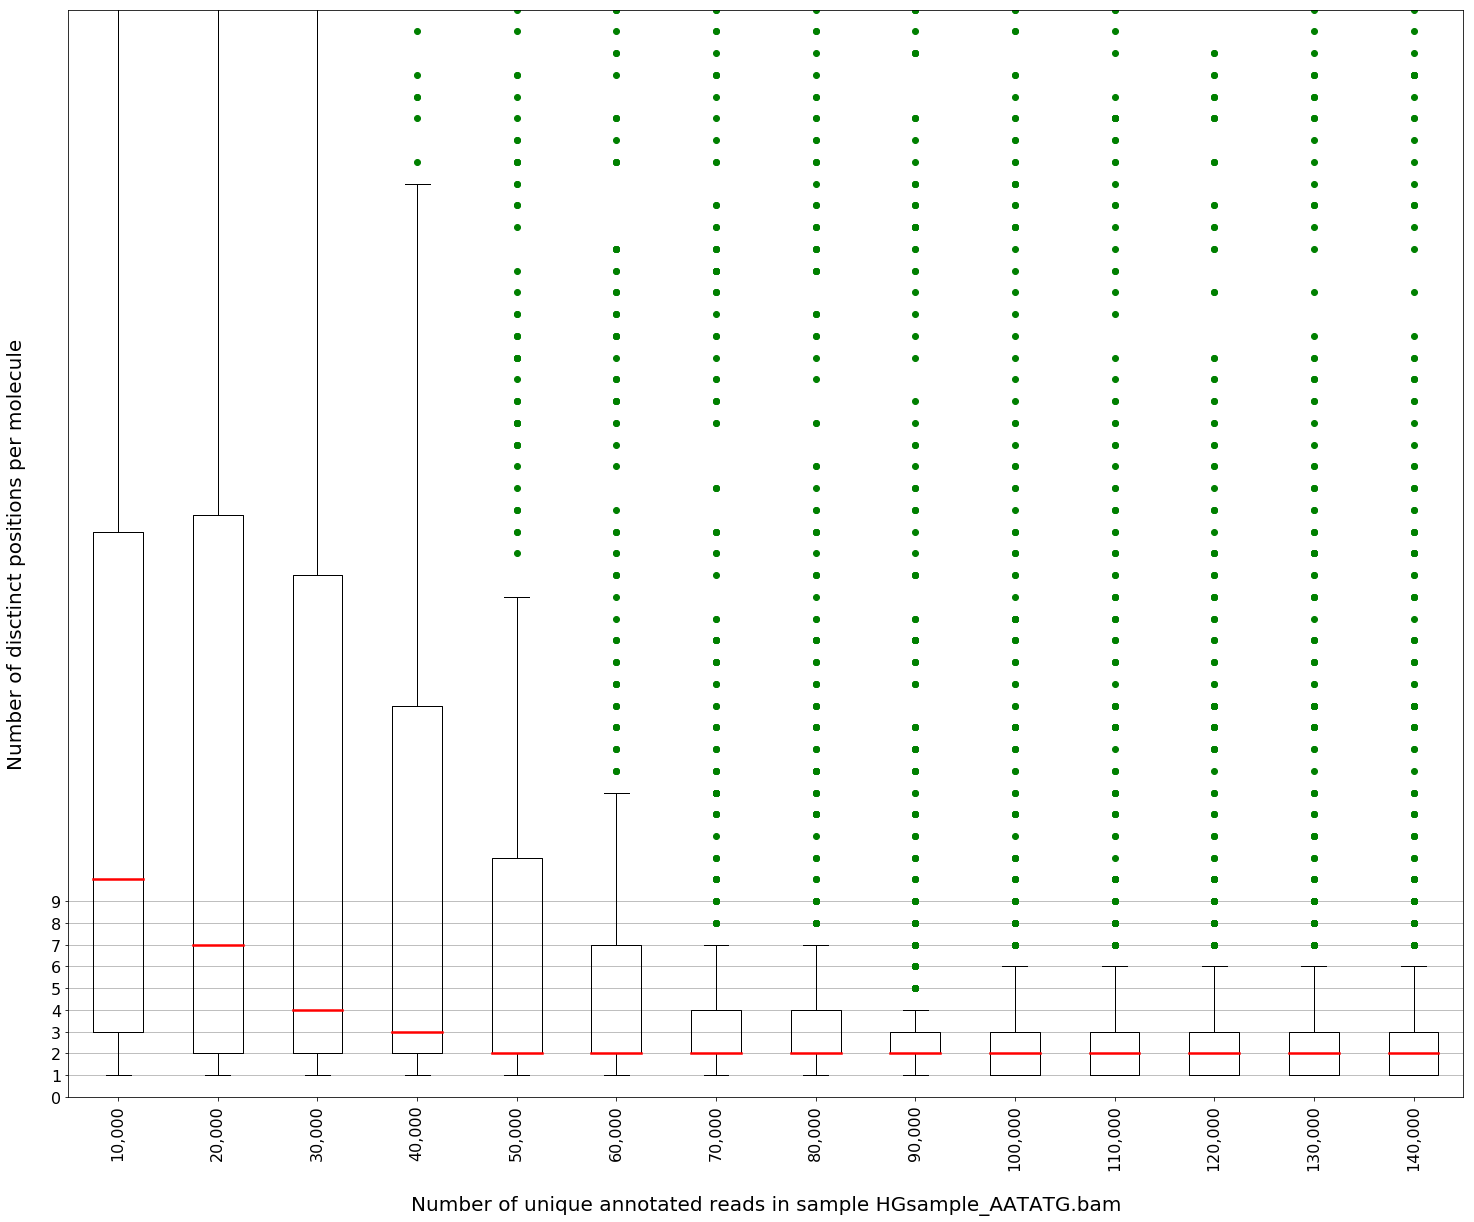

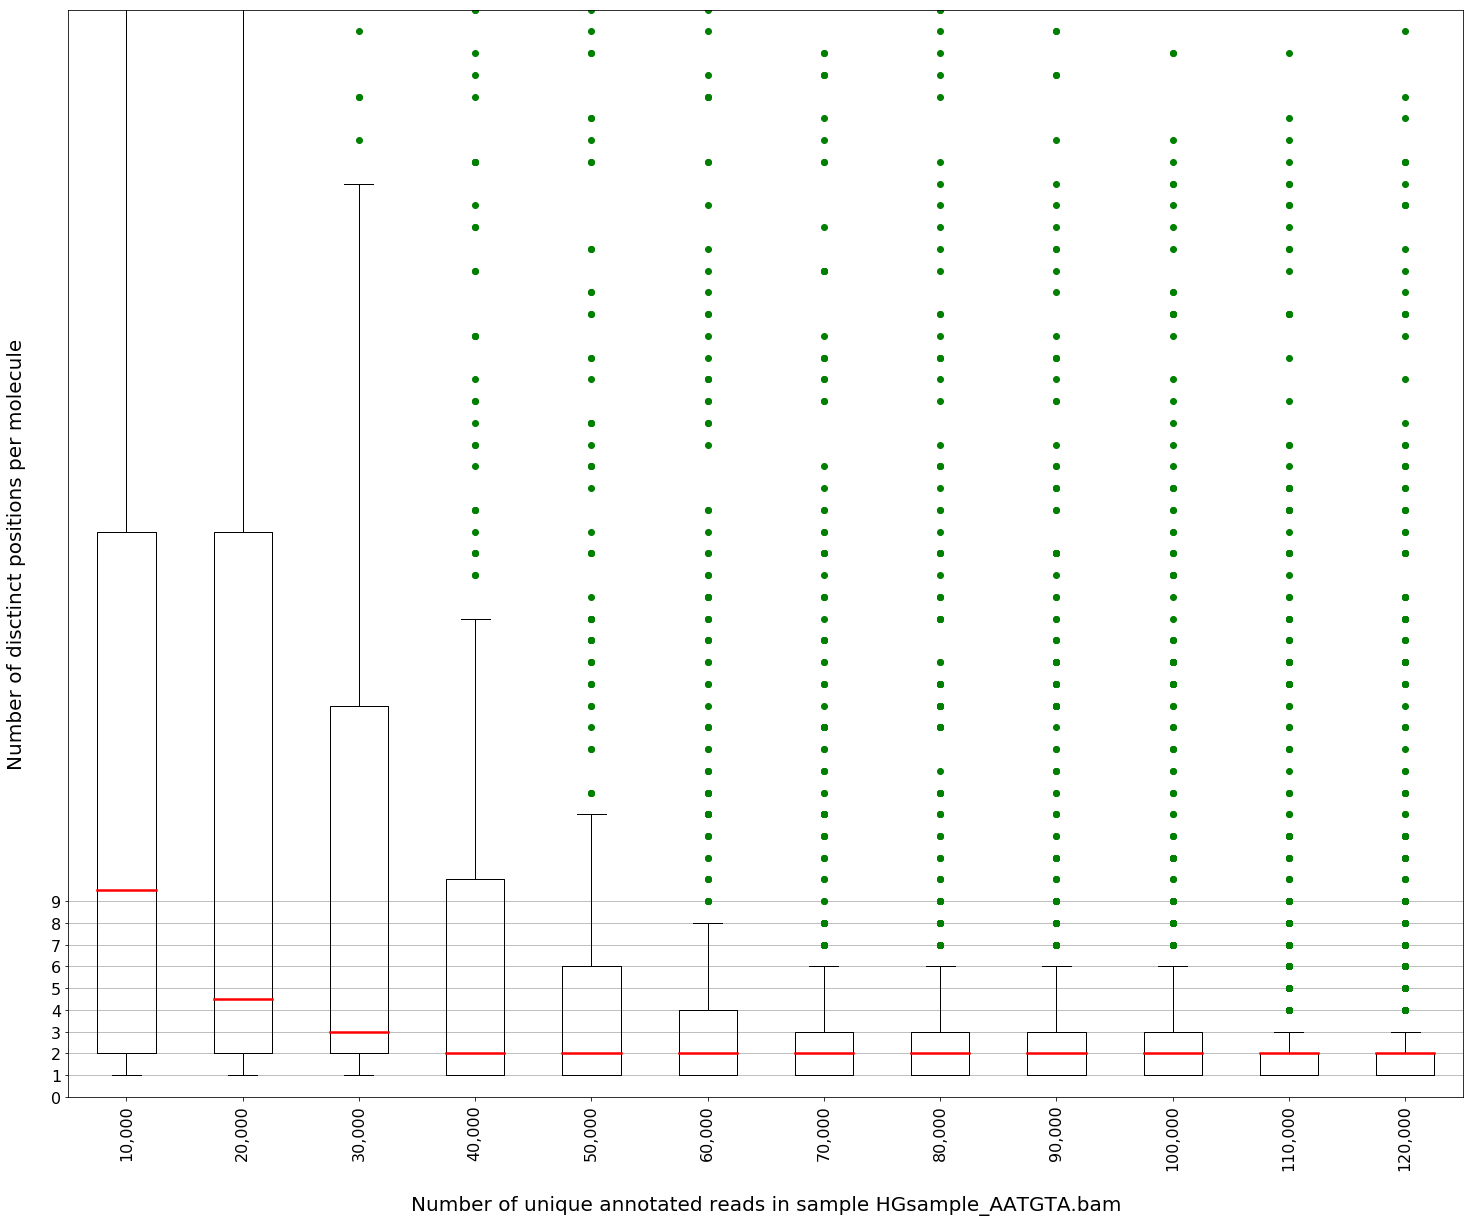

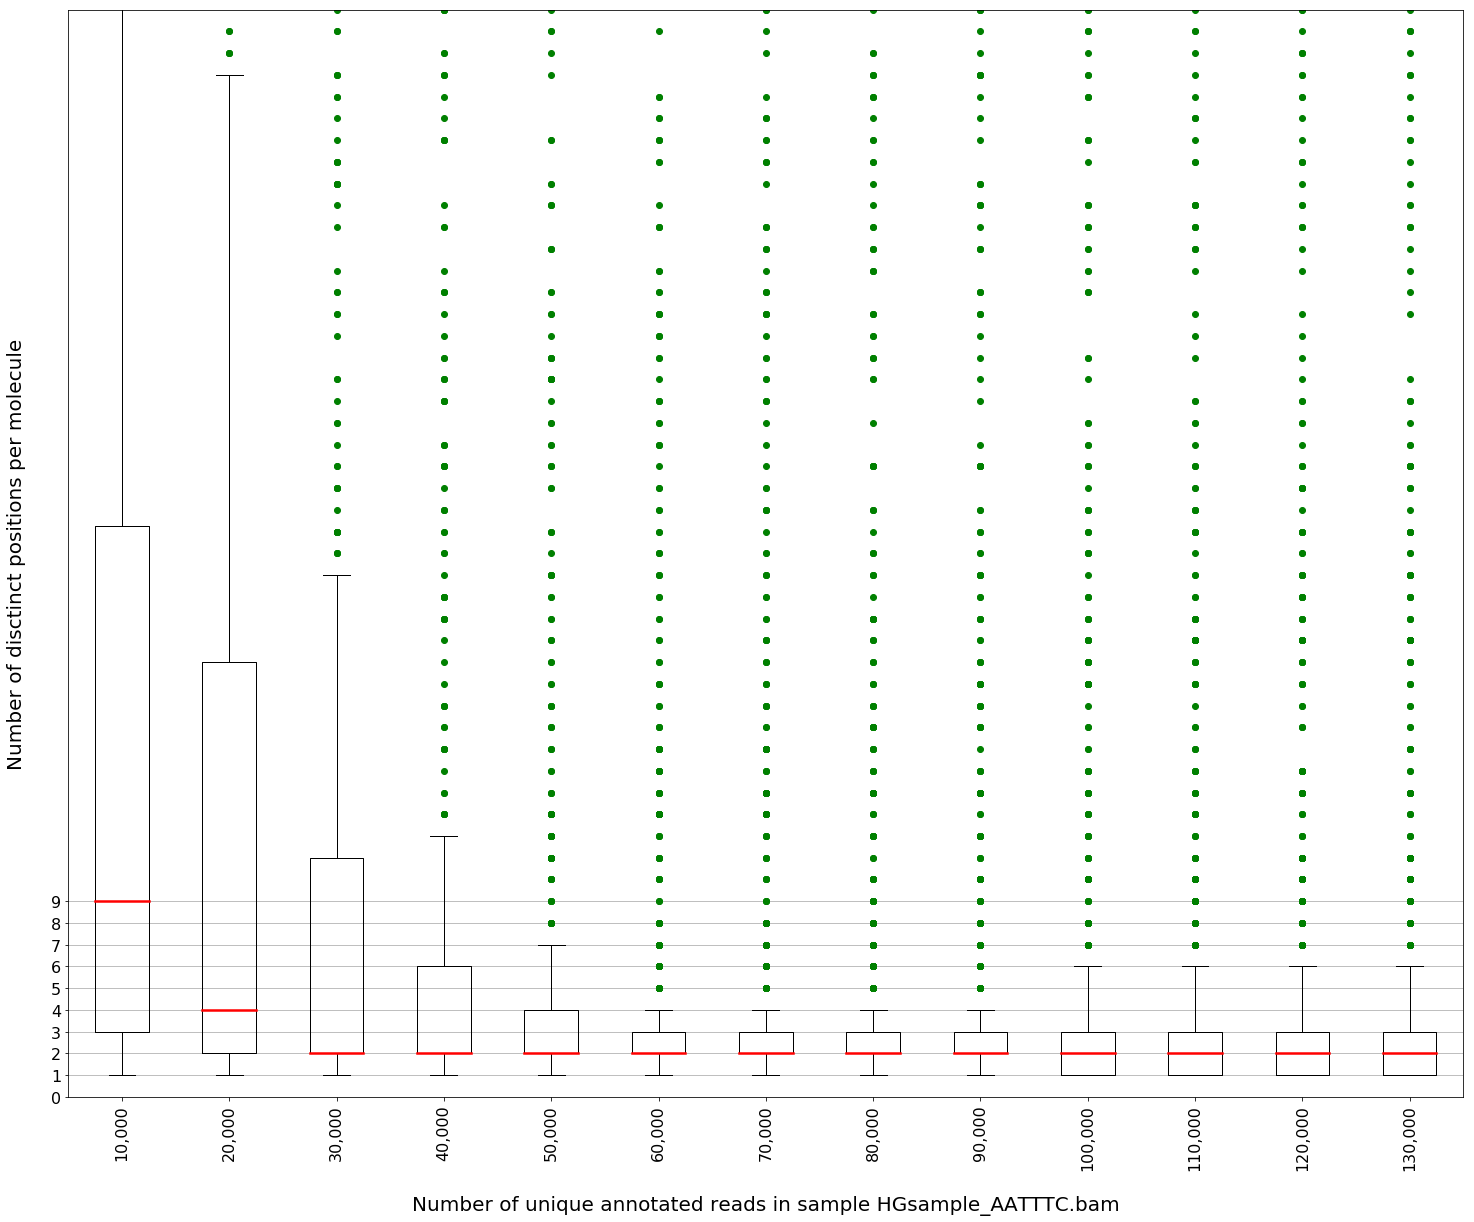

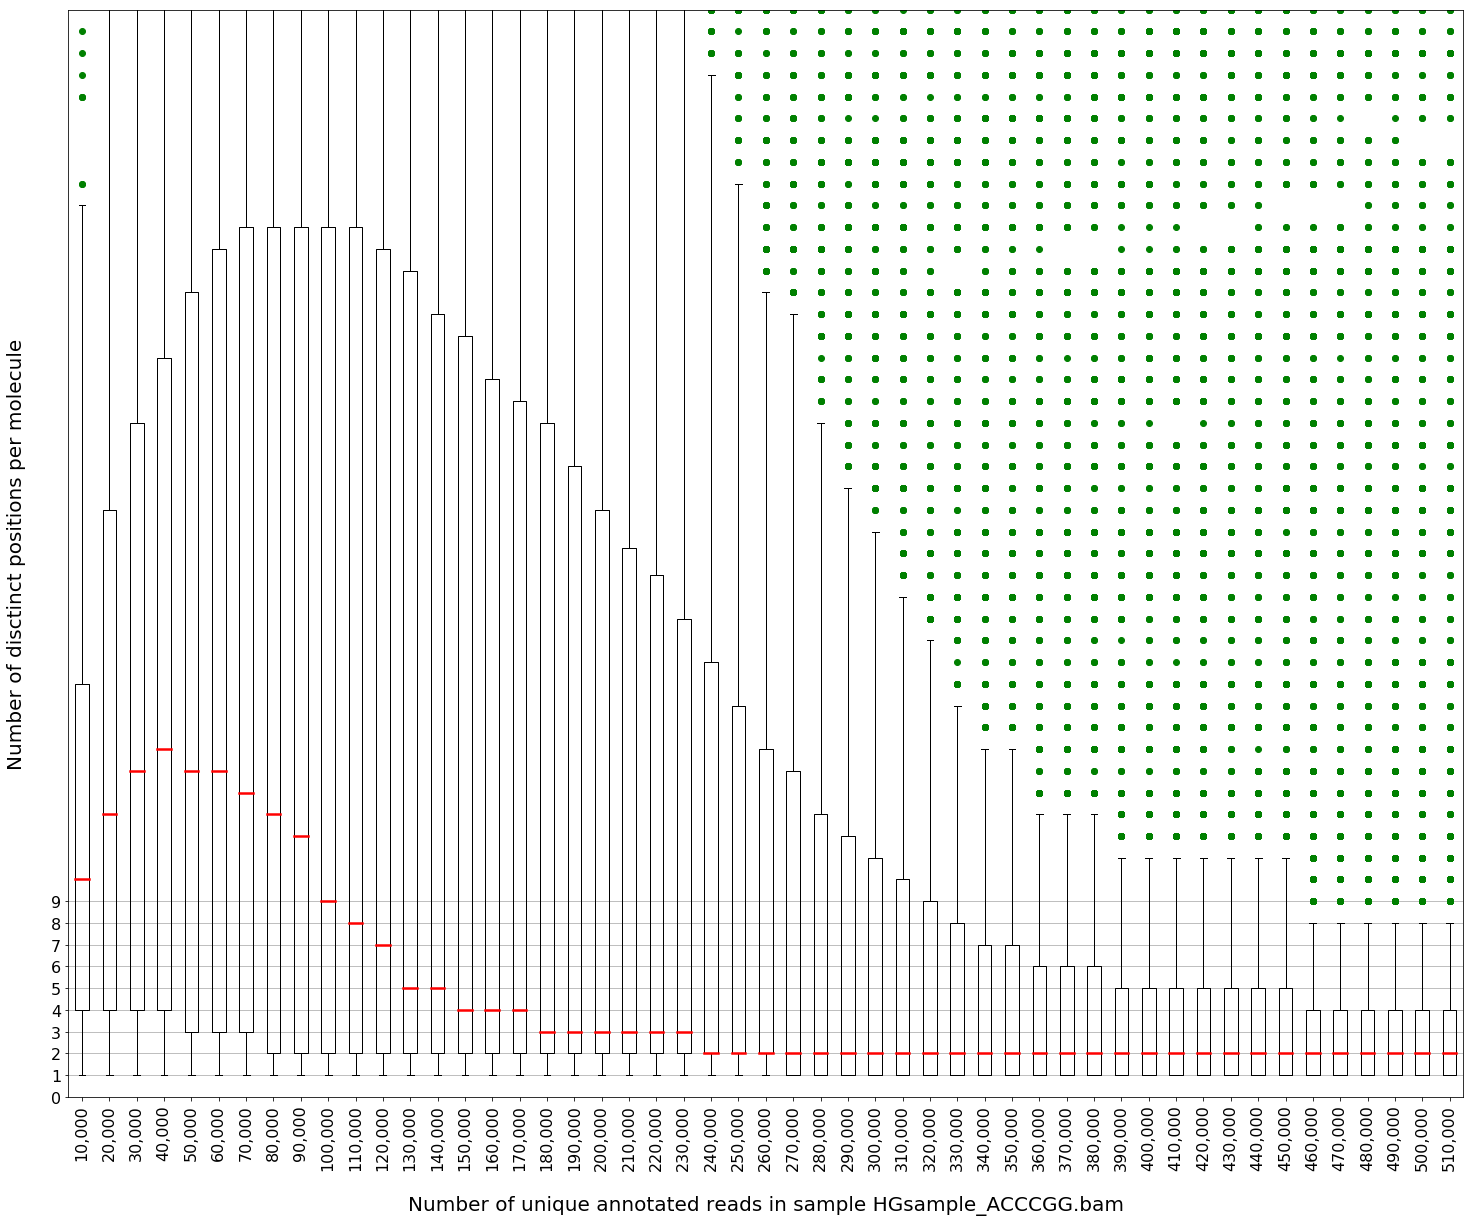

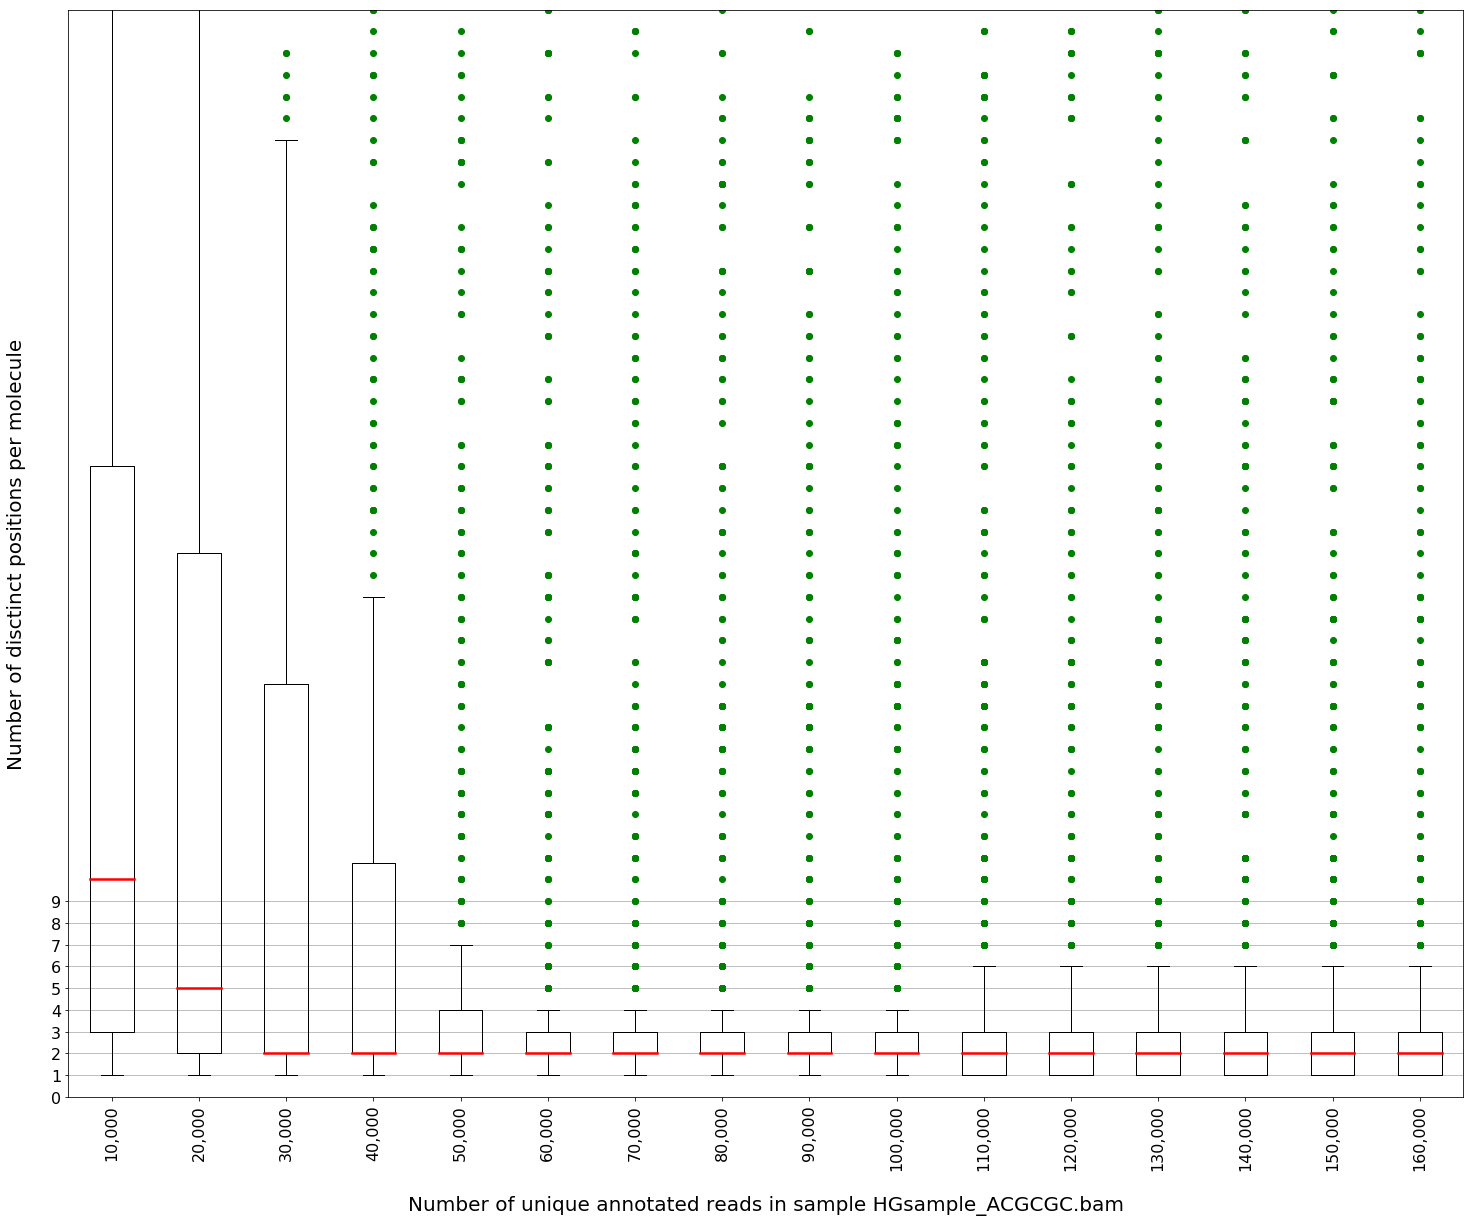

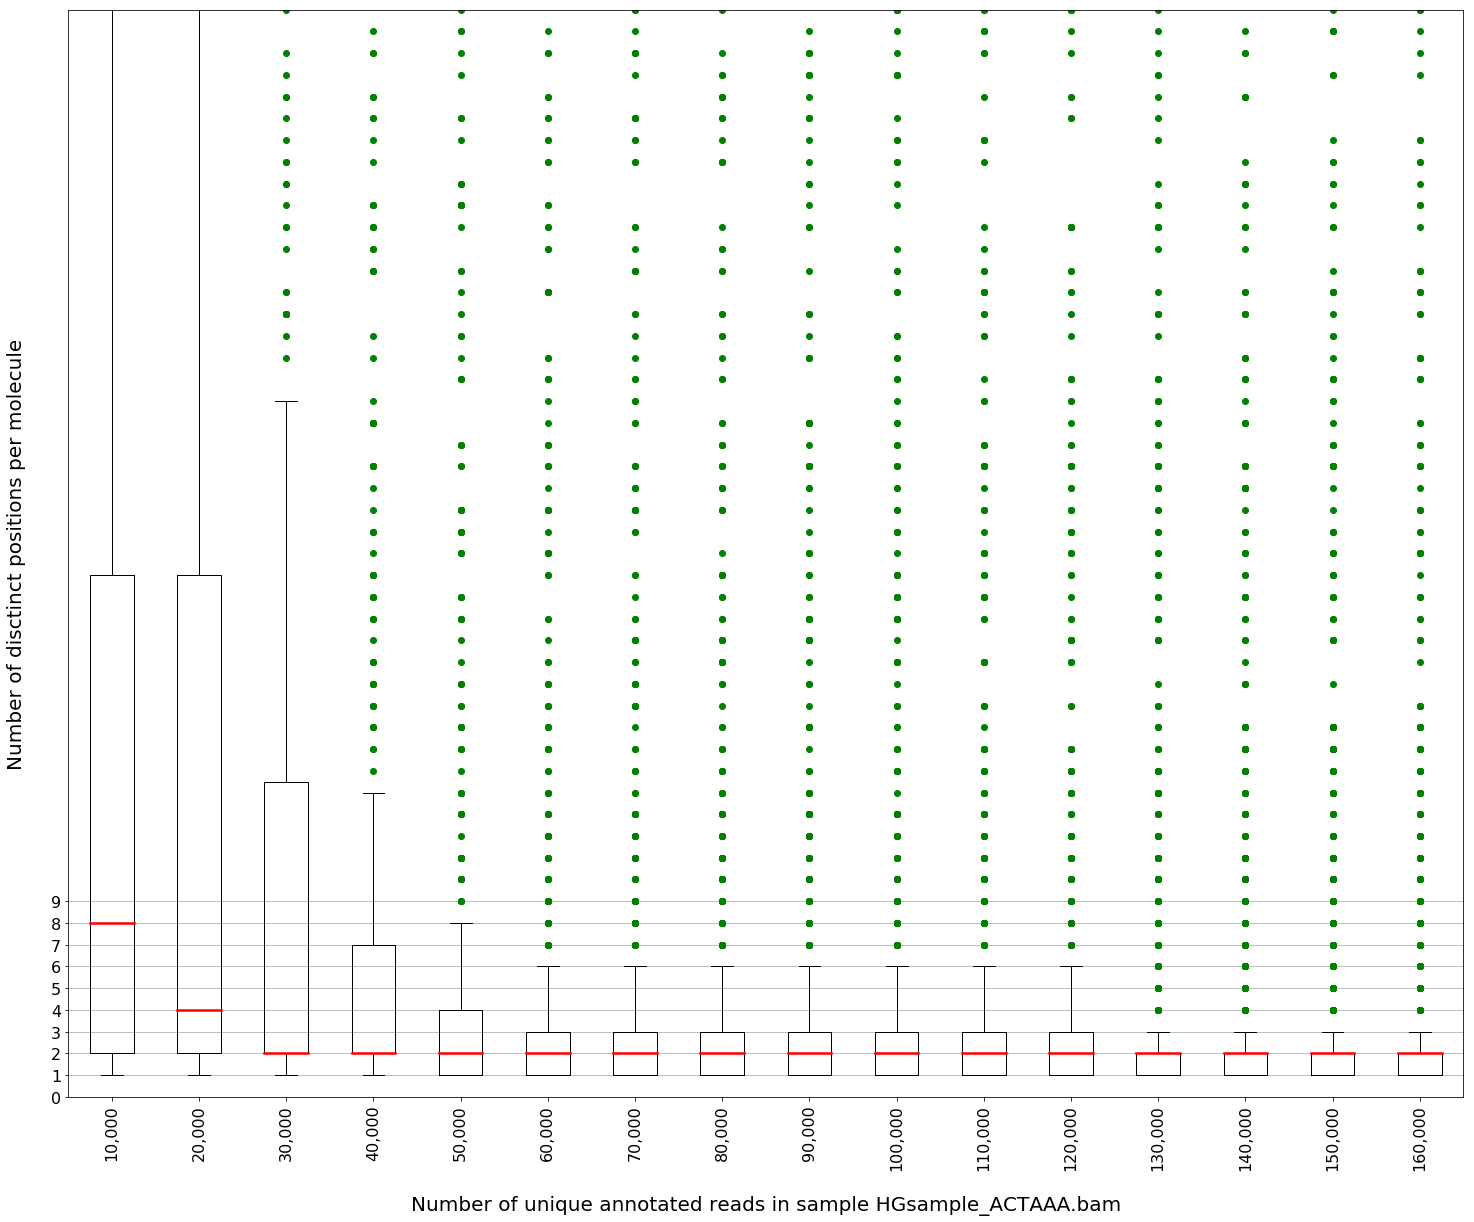

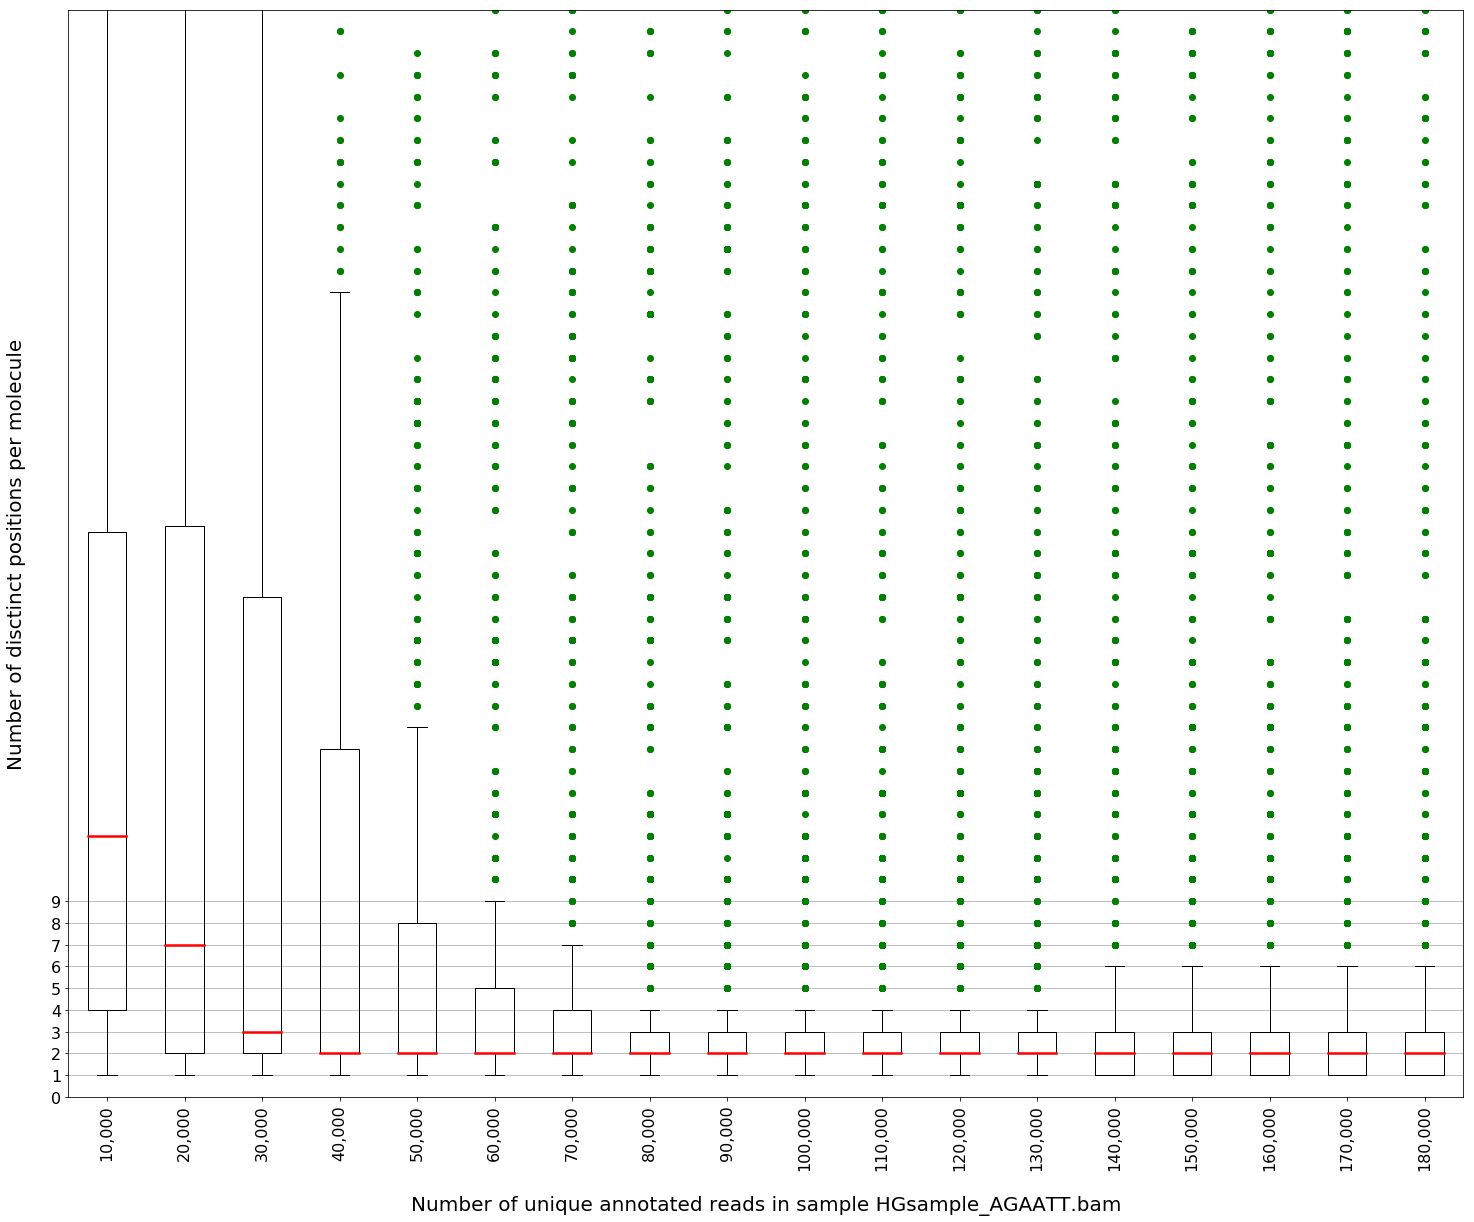

In [14]:
%%time

os.chdir("/data/parastou/UMI/data/HG/AMLPDXdemux/")
step_size = 10000
counter = 0

for in_file in glob.glob("*.bam"):
    if counter > 10:
        break
        
    compute_saturation(in_file, step_size)
        
    counter += 1

CPU times: user 1min 2s, sys: 306 ms, total: 1min 3s
Wall time: 1min 3s


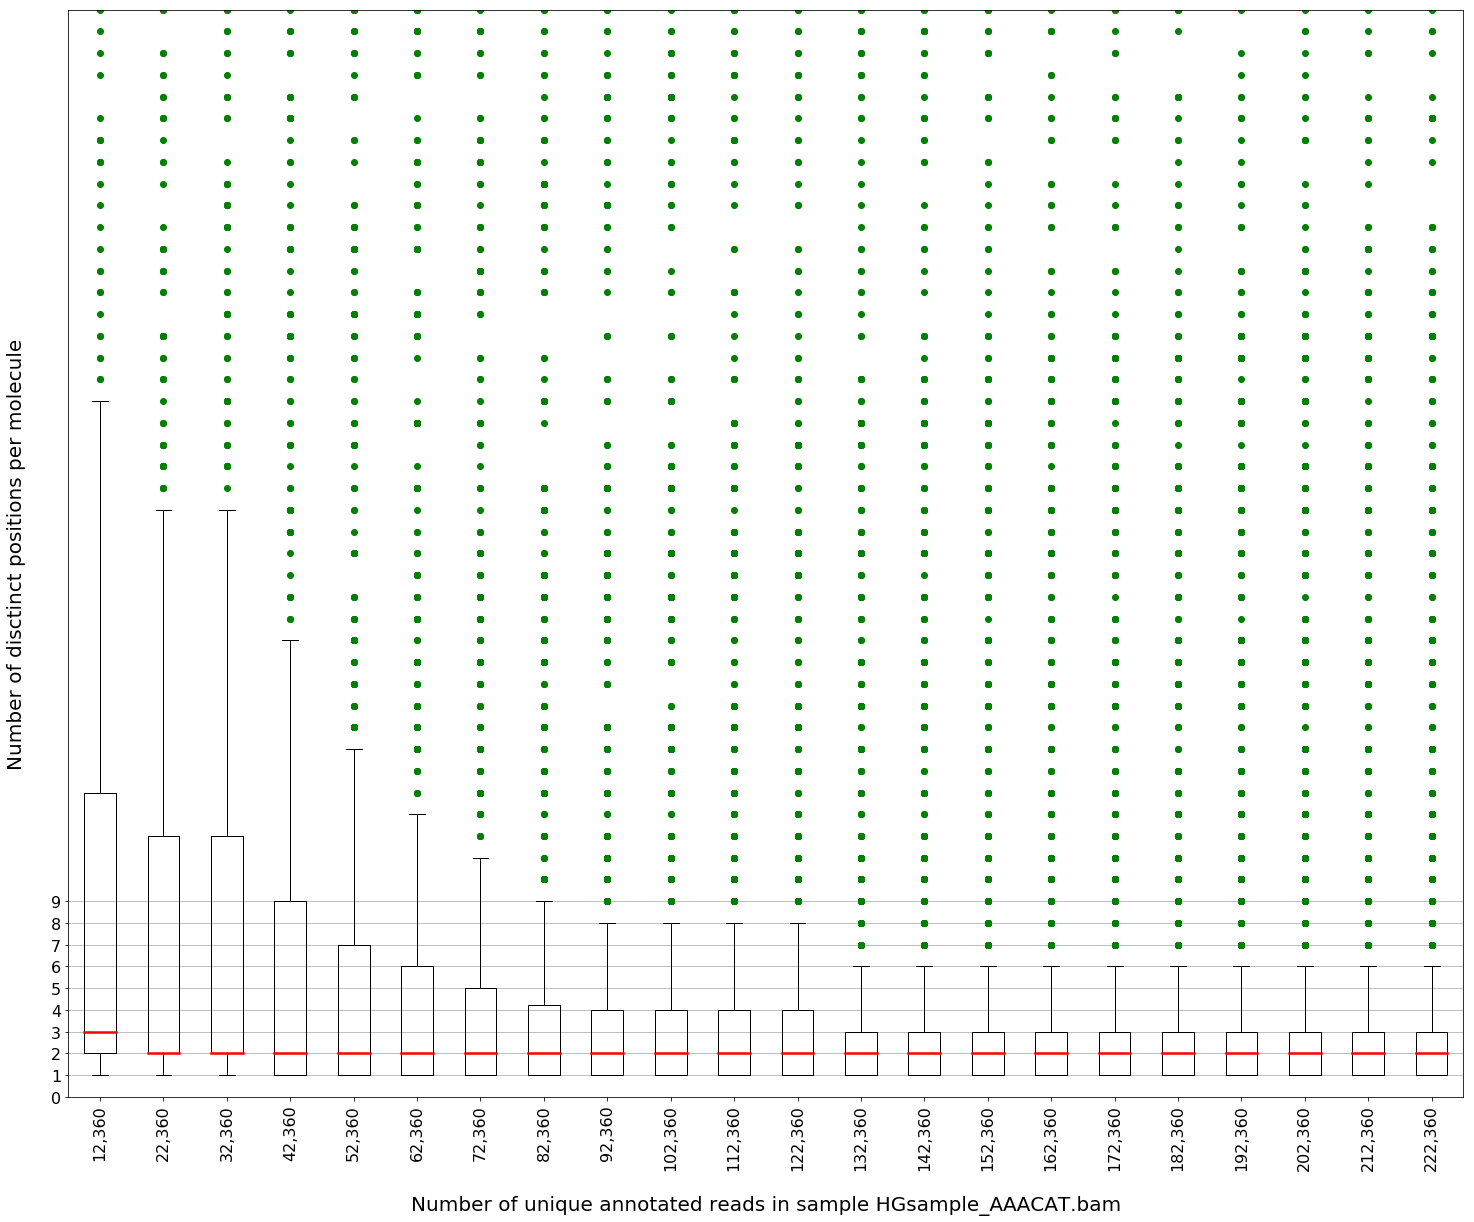

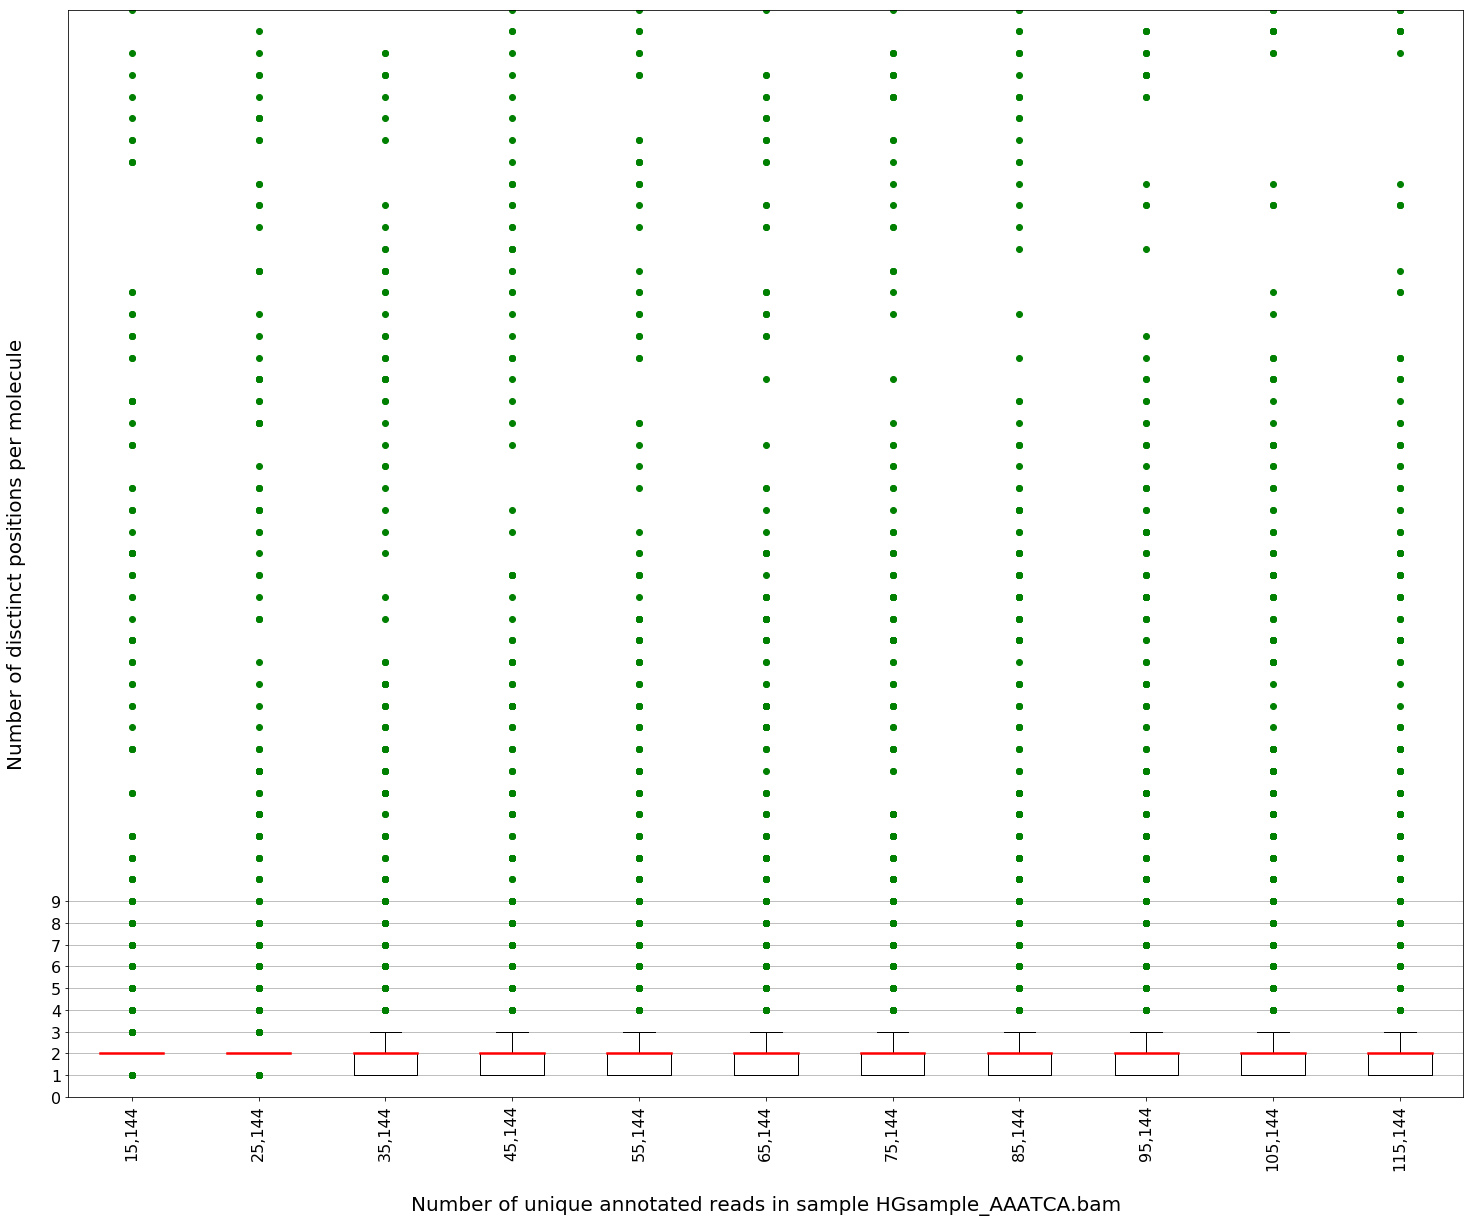

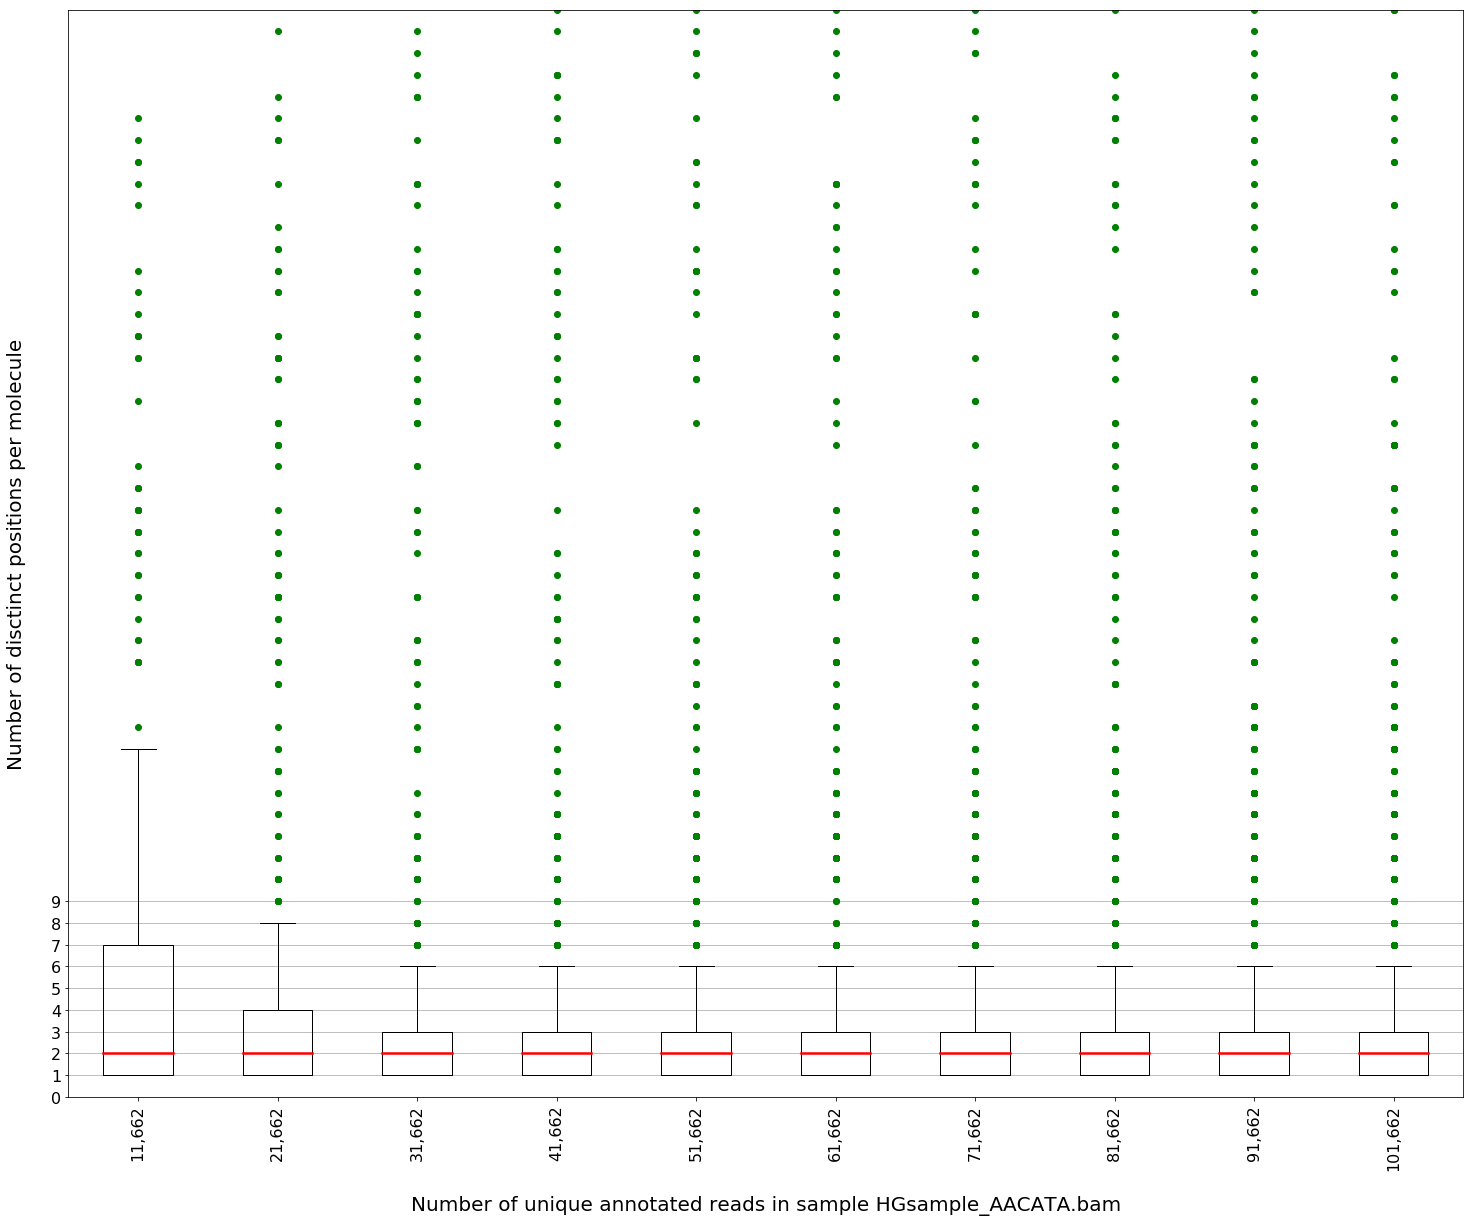

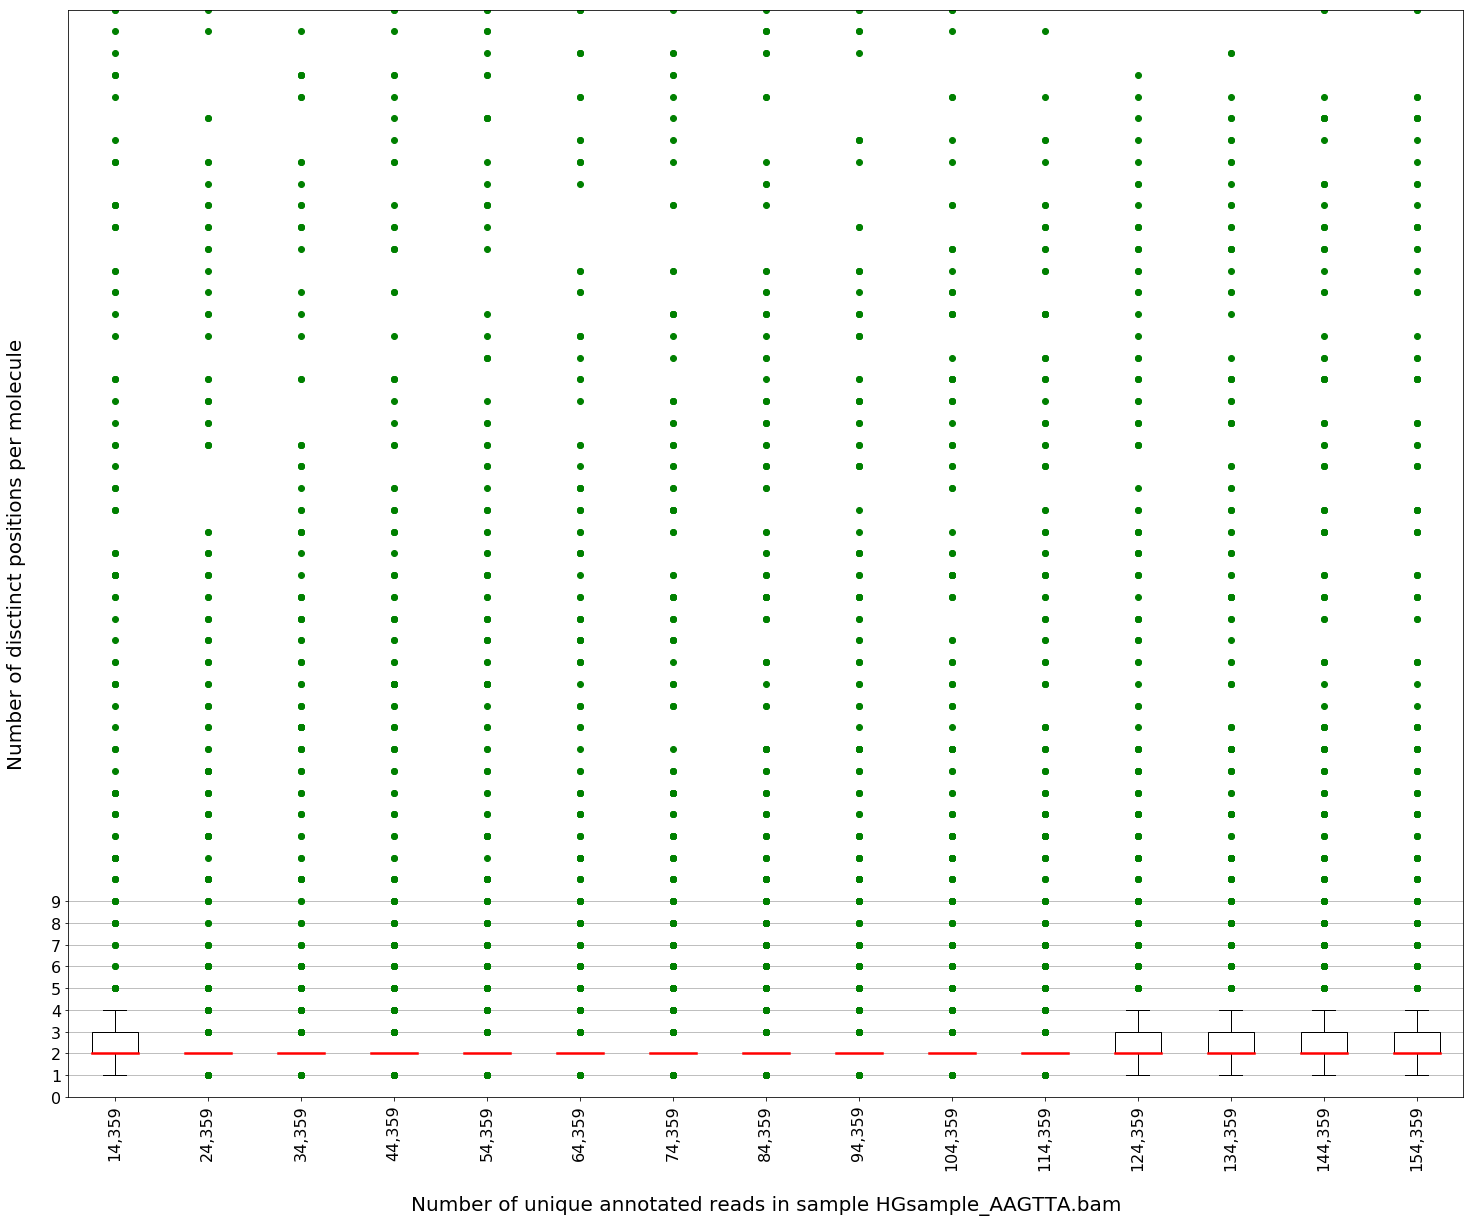

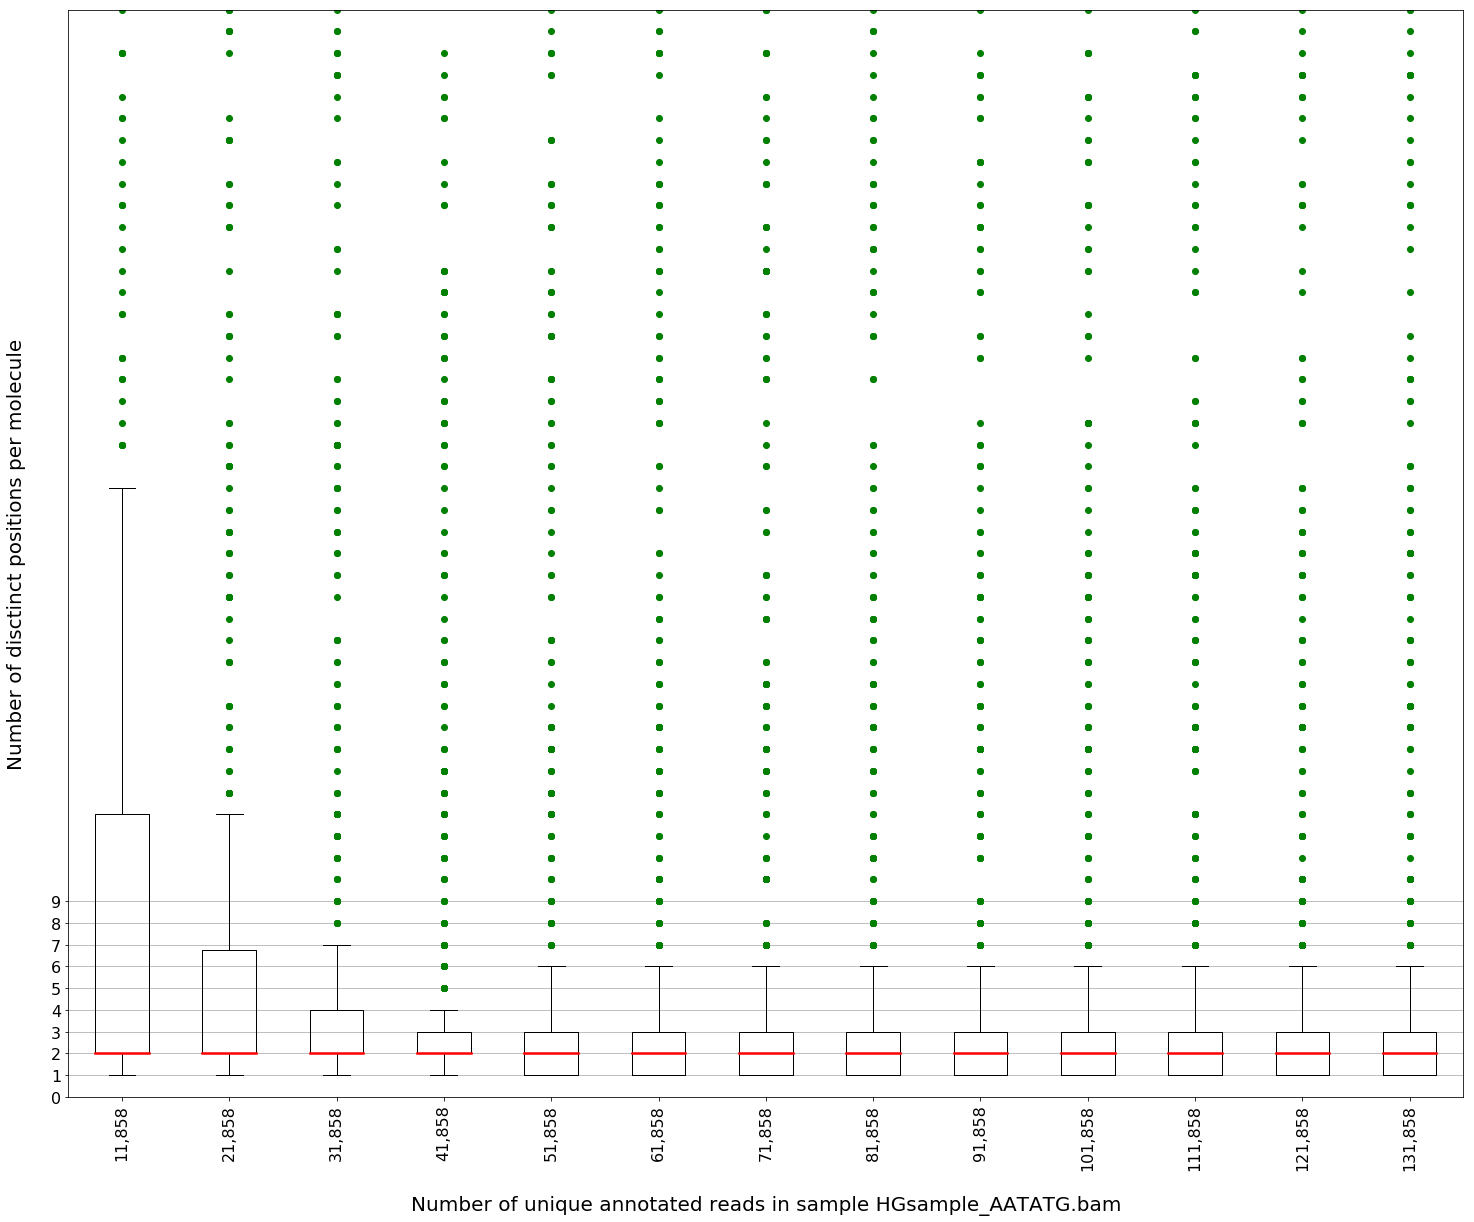

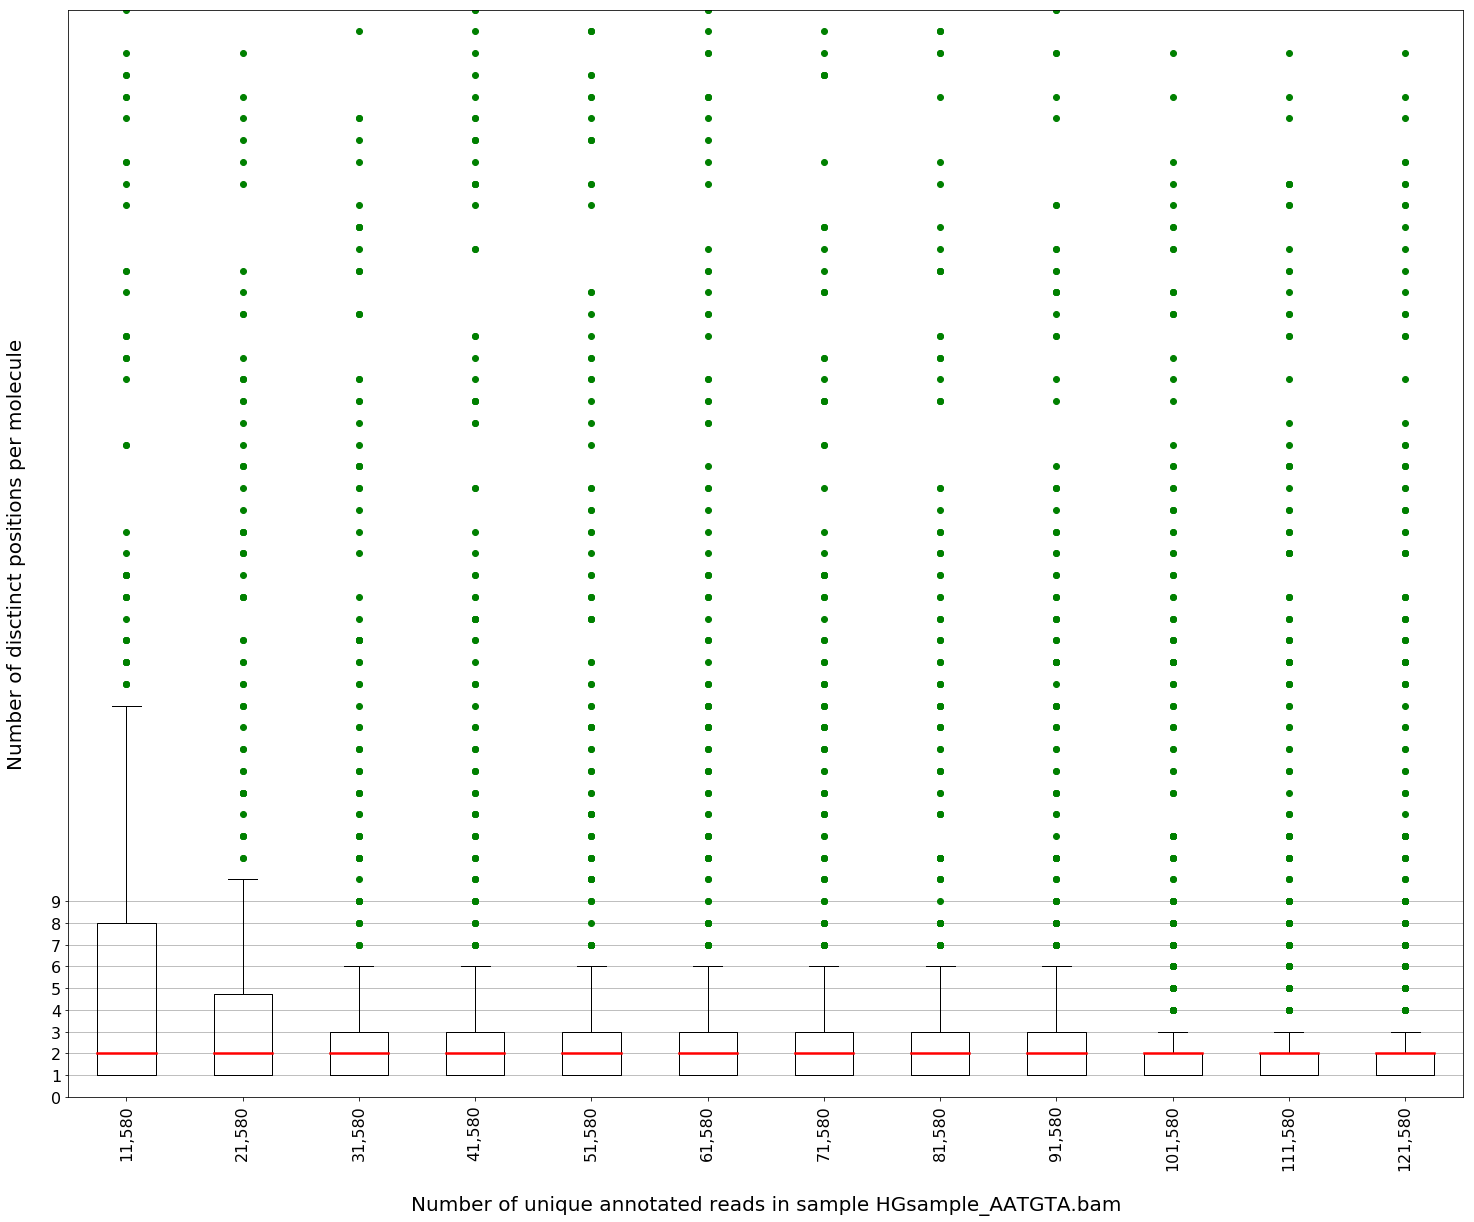

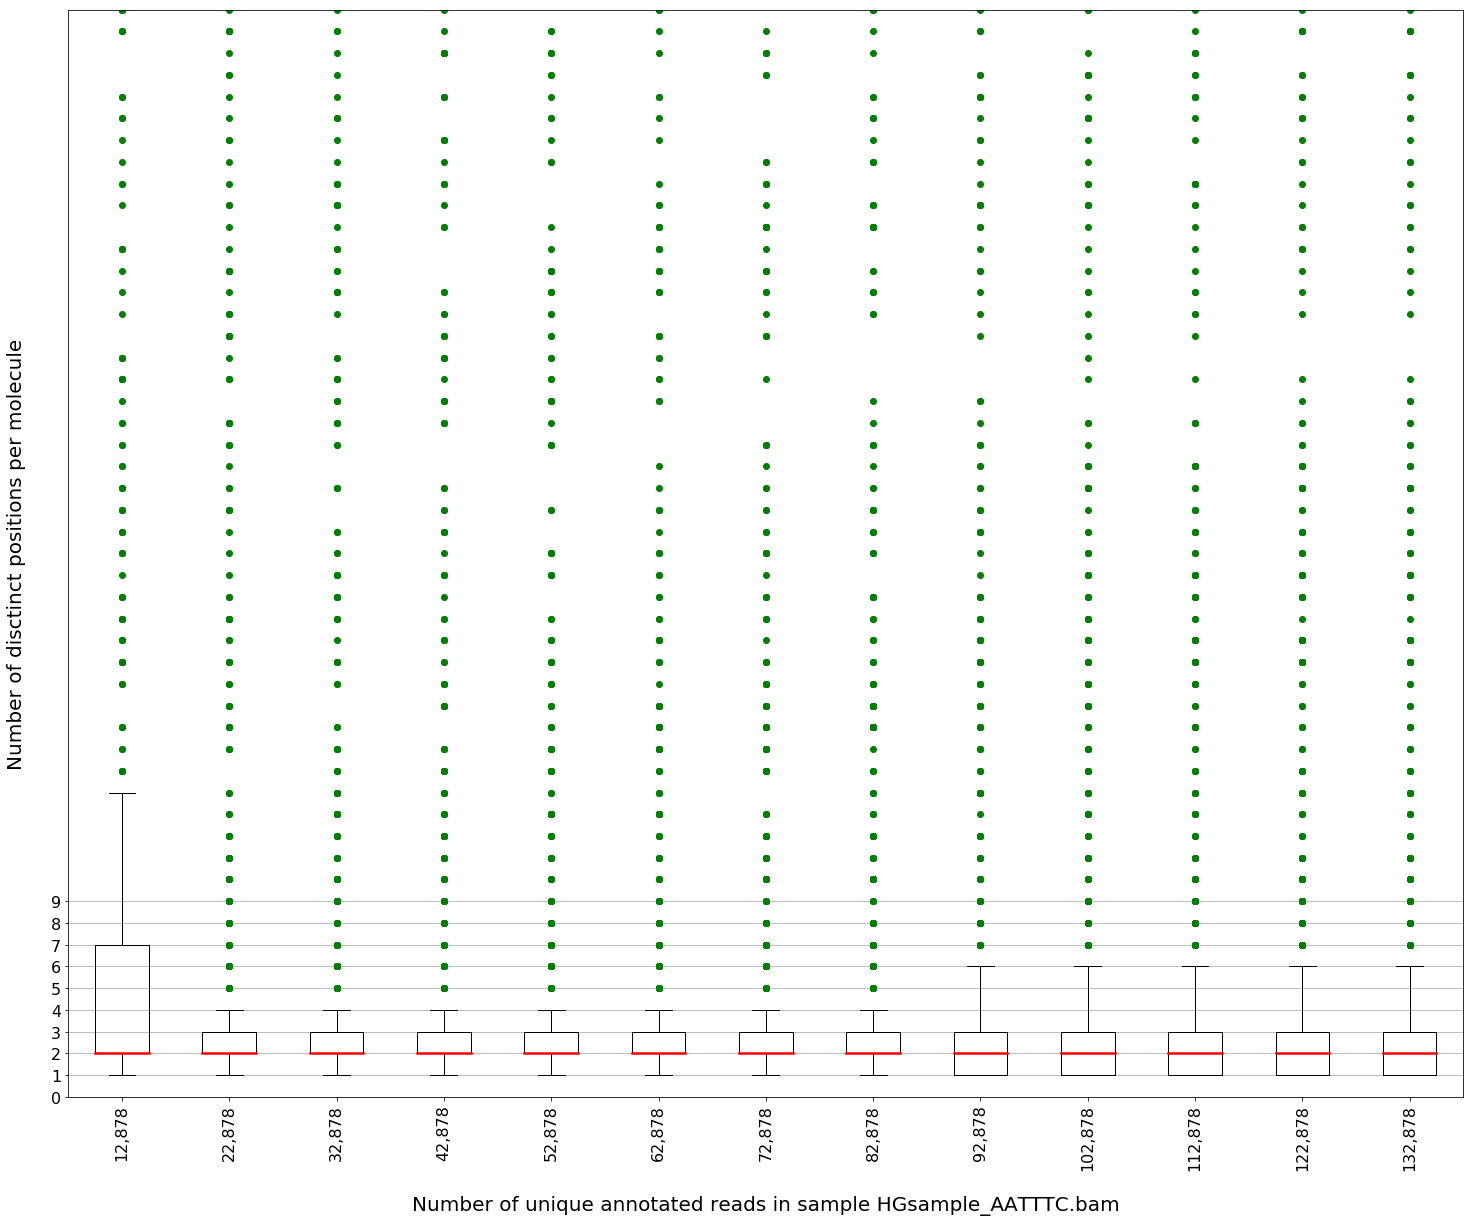

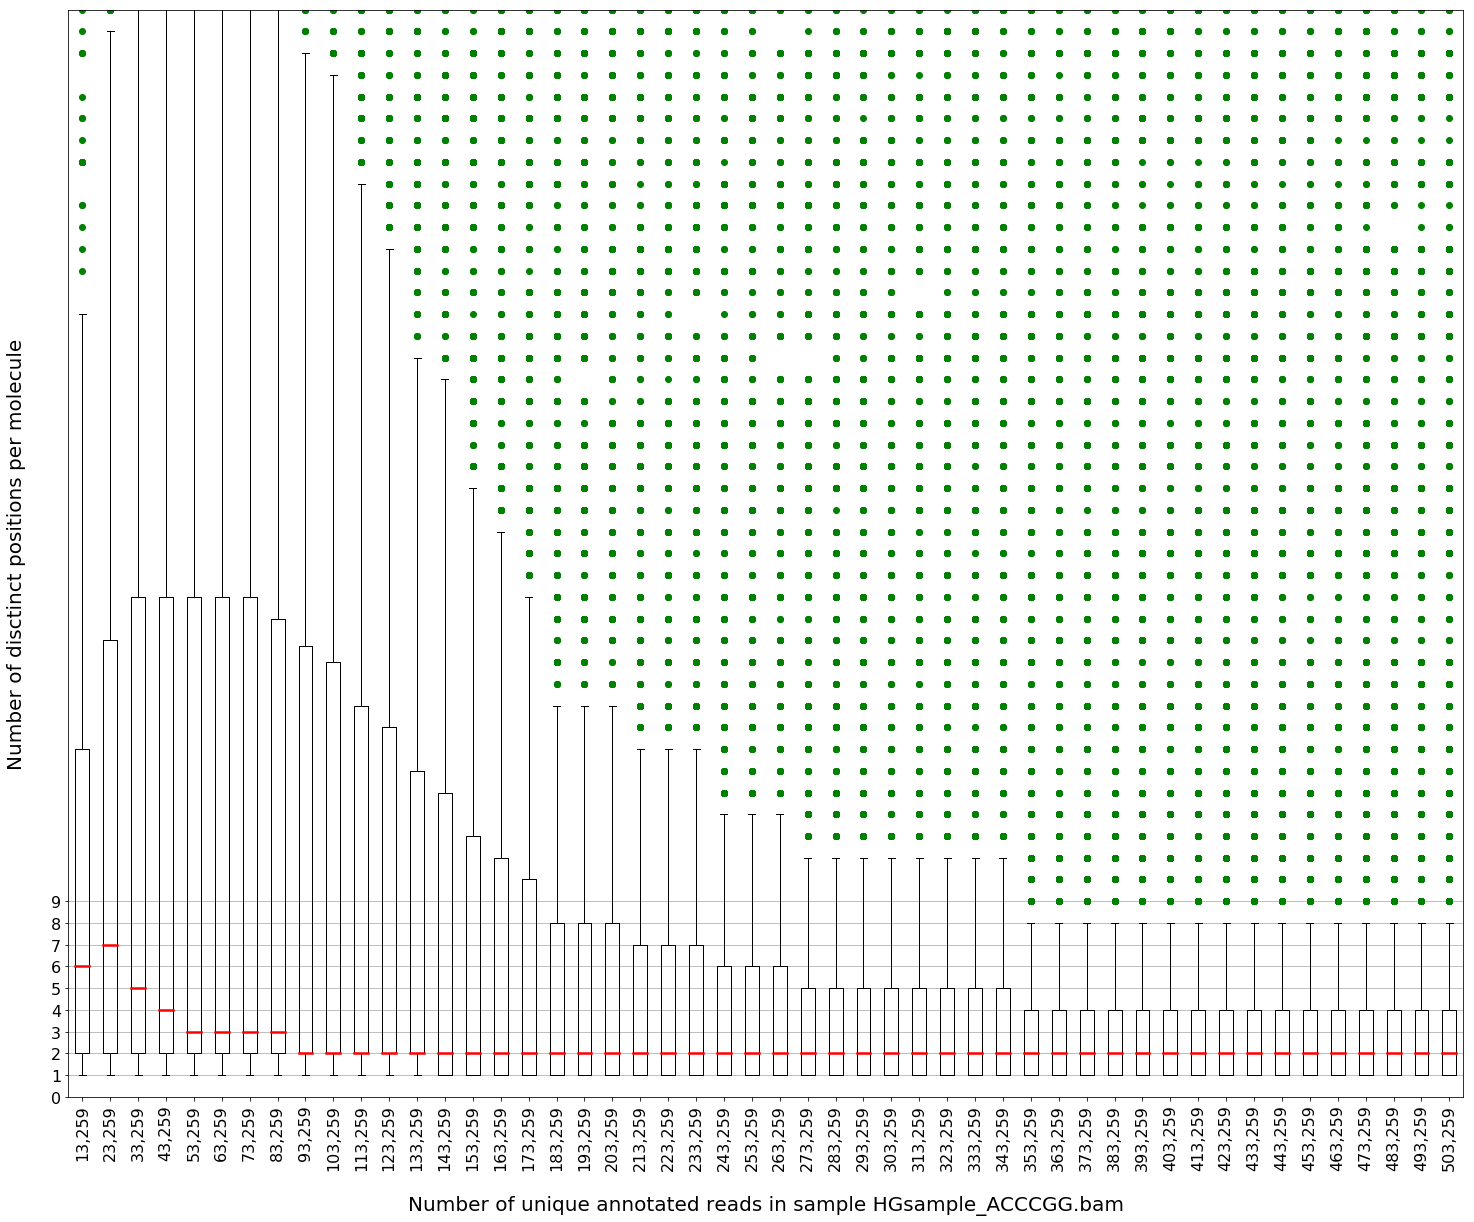

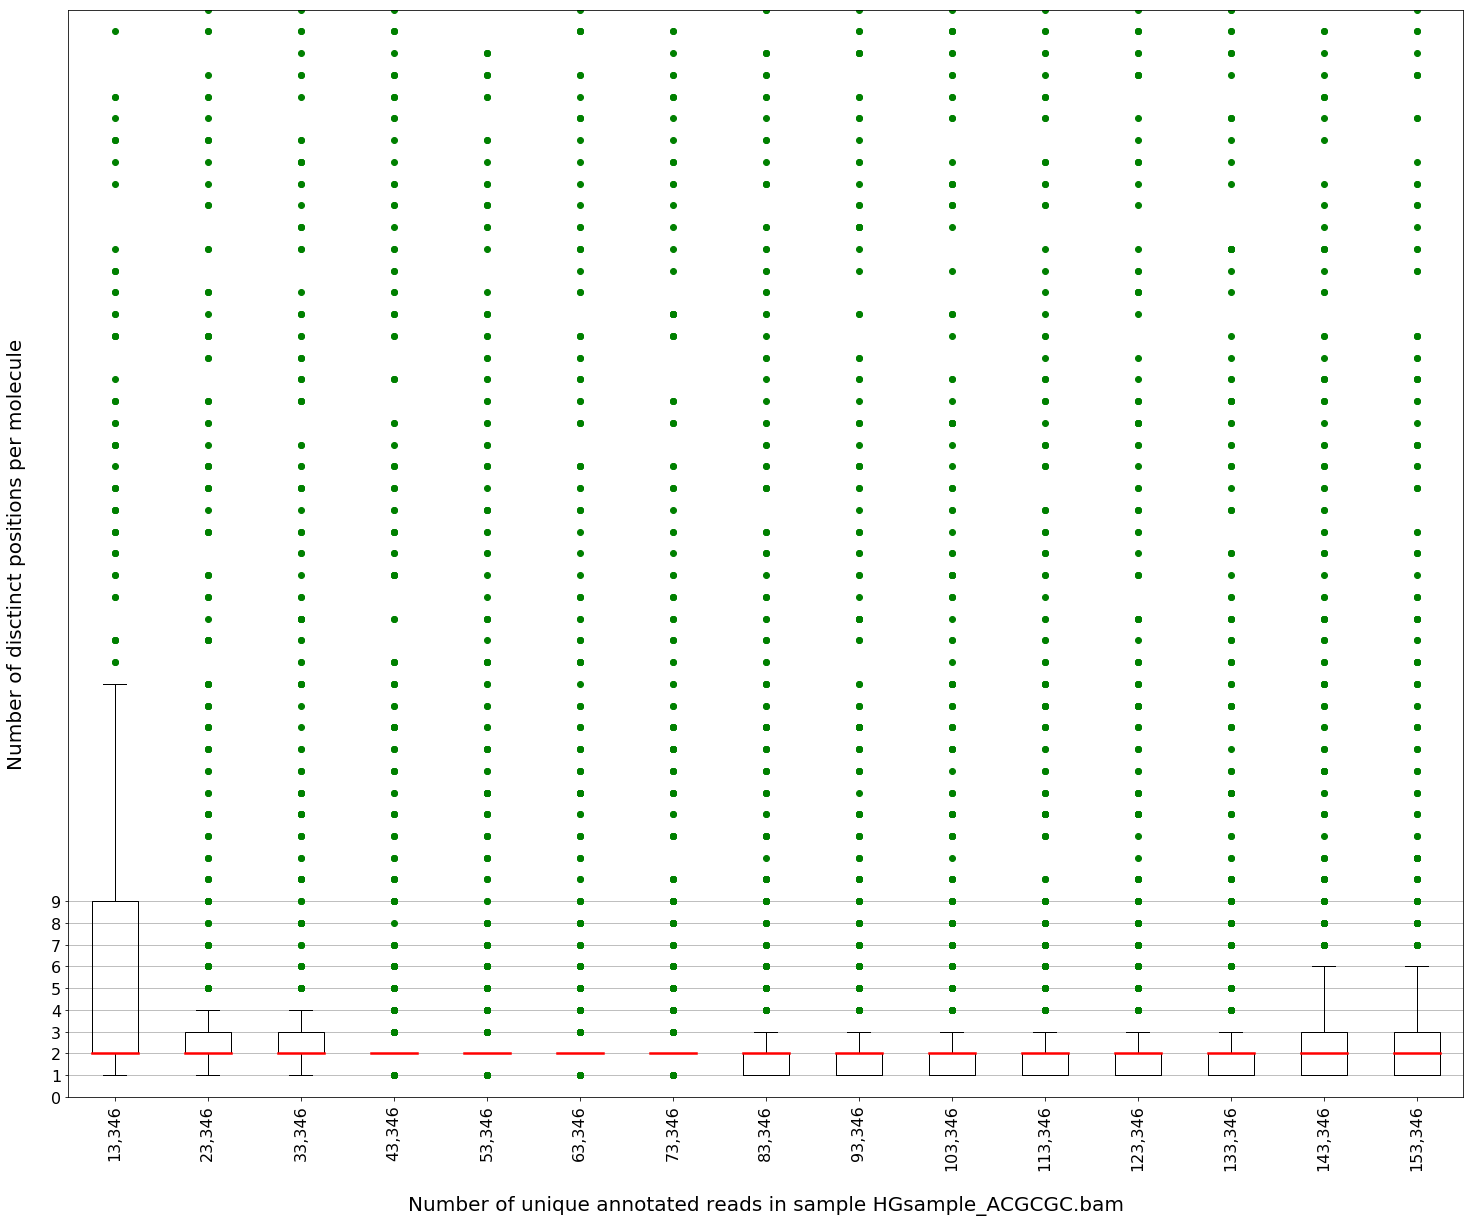

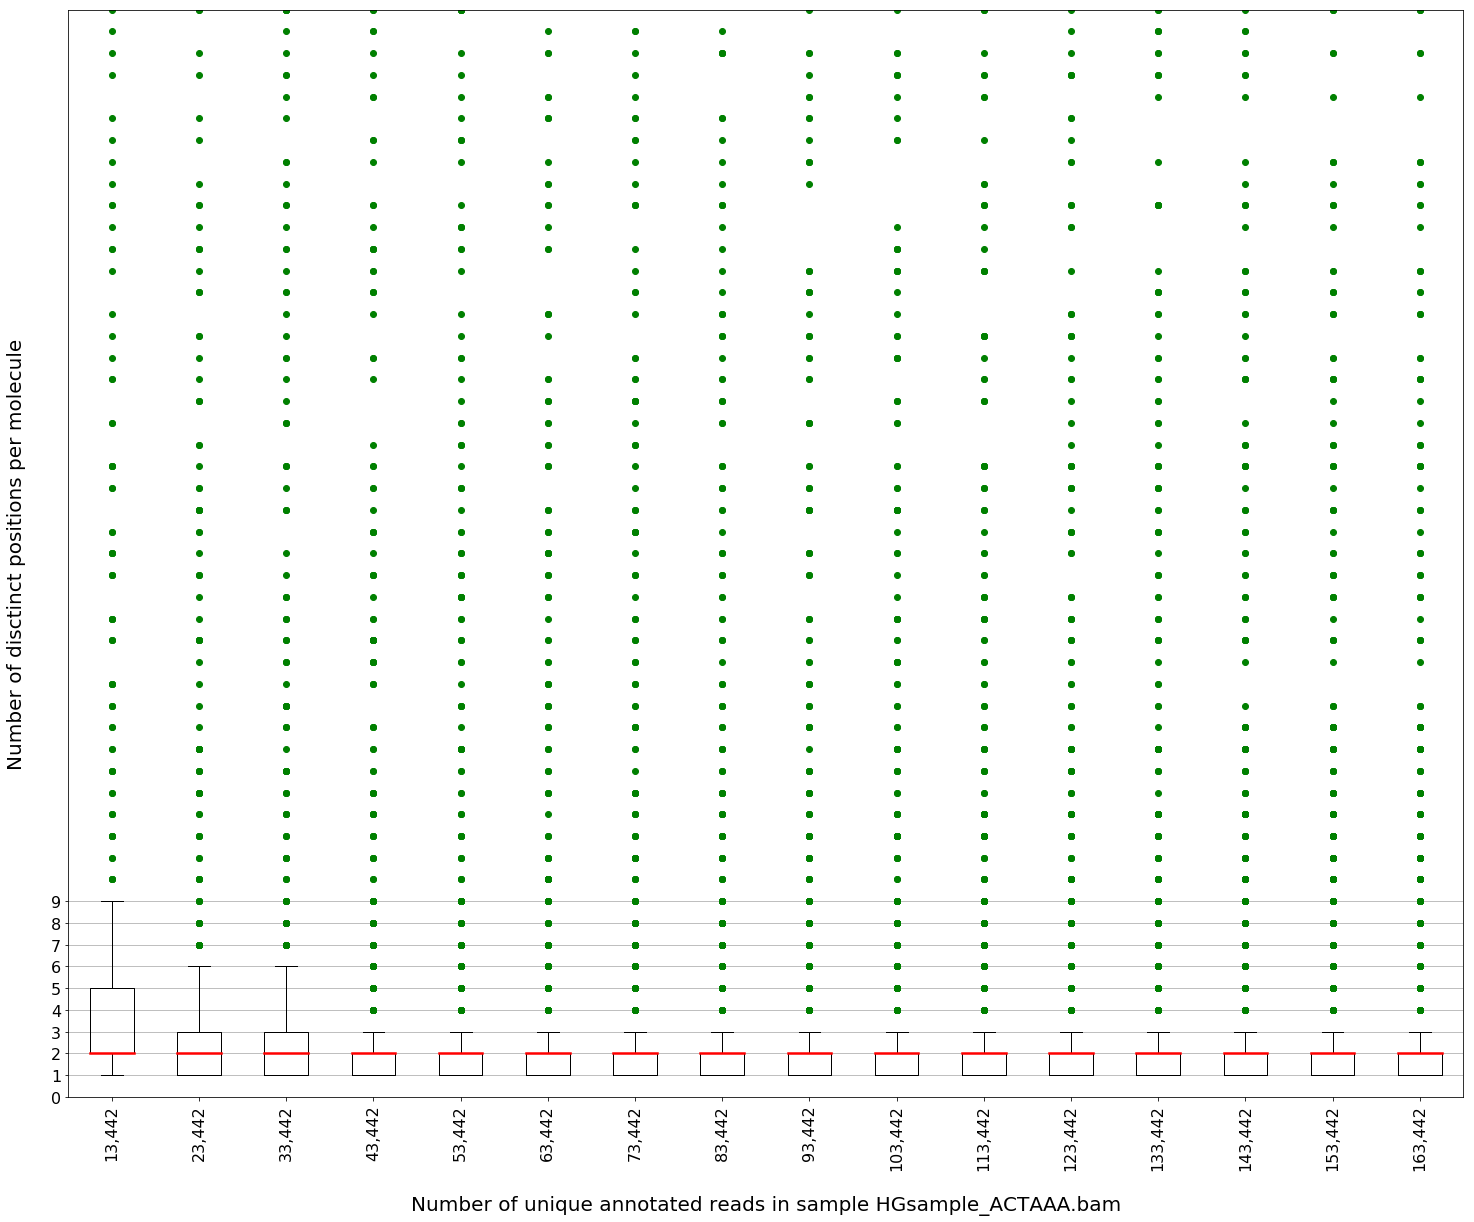

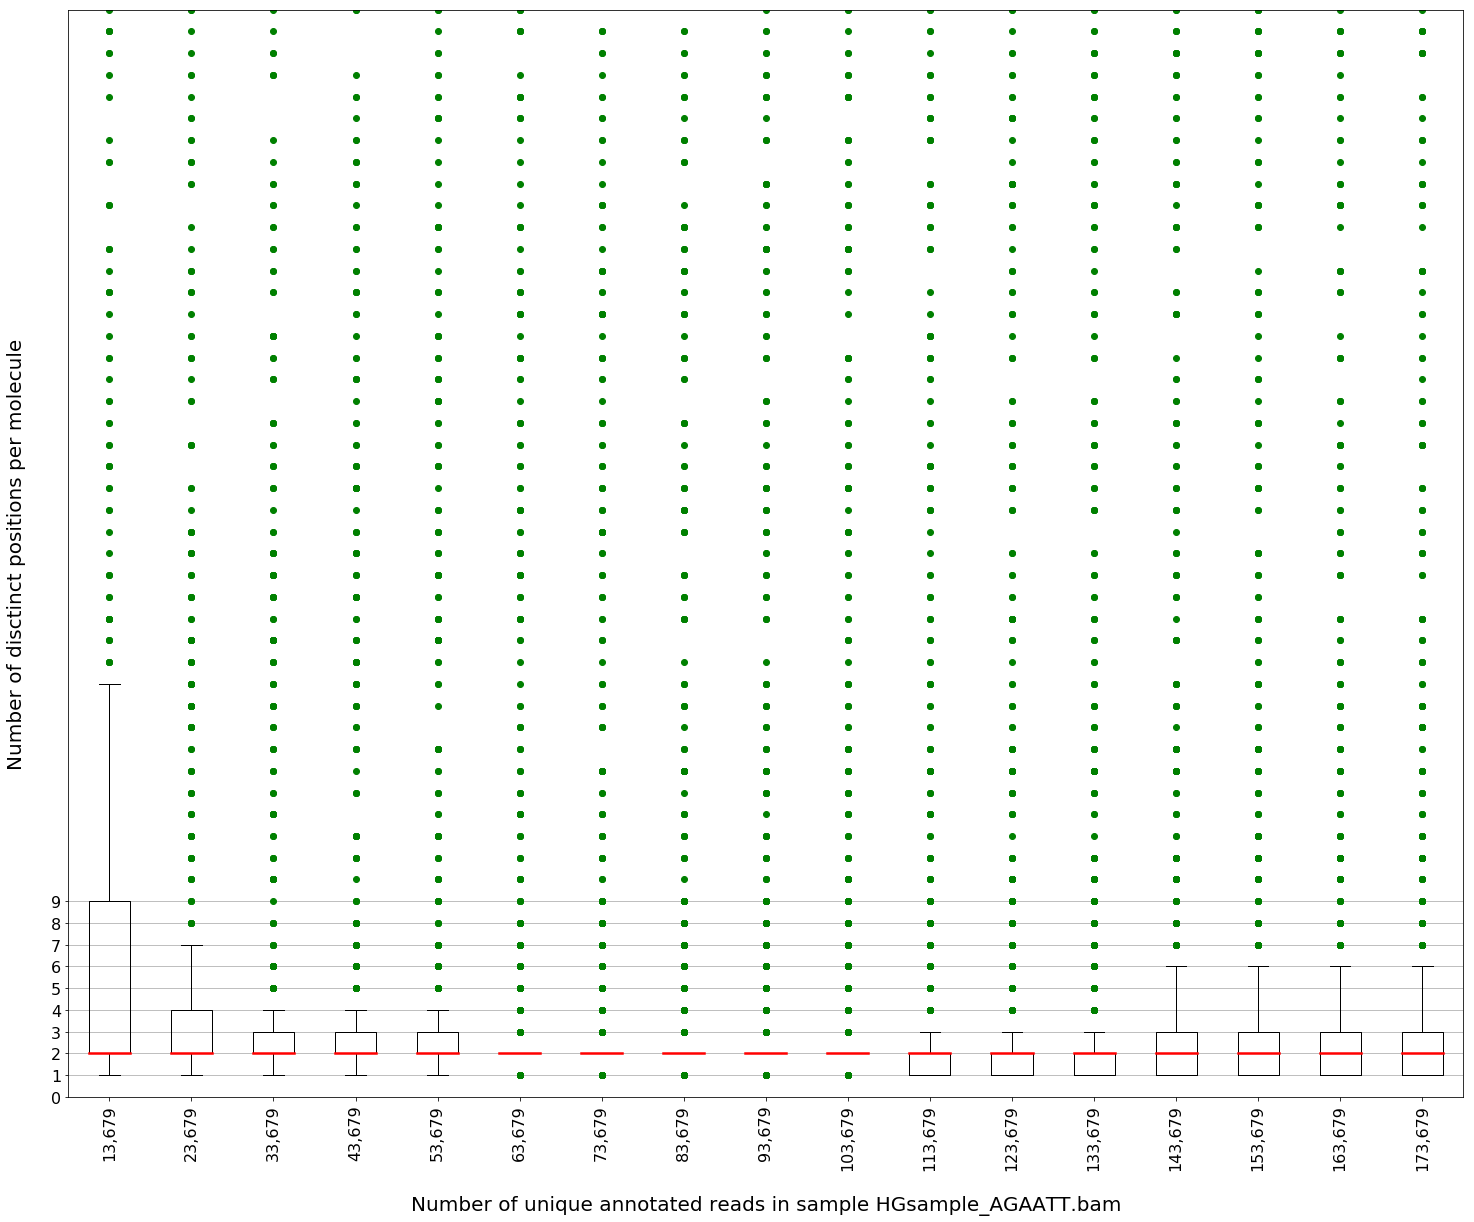

In [15]:
%%time

os.chdir("/data/parastou/UMI/data/HG/AMLPDXdemux/")
step_size = 10000
counter = 0

for in_file in glob.glob("*.bam"):
    if counter > 10:
        break
        
    compute_step_saturation(in_file, step_size, out_file_prefix='step')
        
    counter += 1

----------------------------------------------------------------------------

CPU times: user 1h 14s, sys: 24.4 s, total: 1h 38s
Wall time: 1h 39s


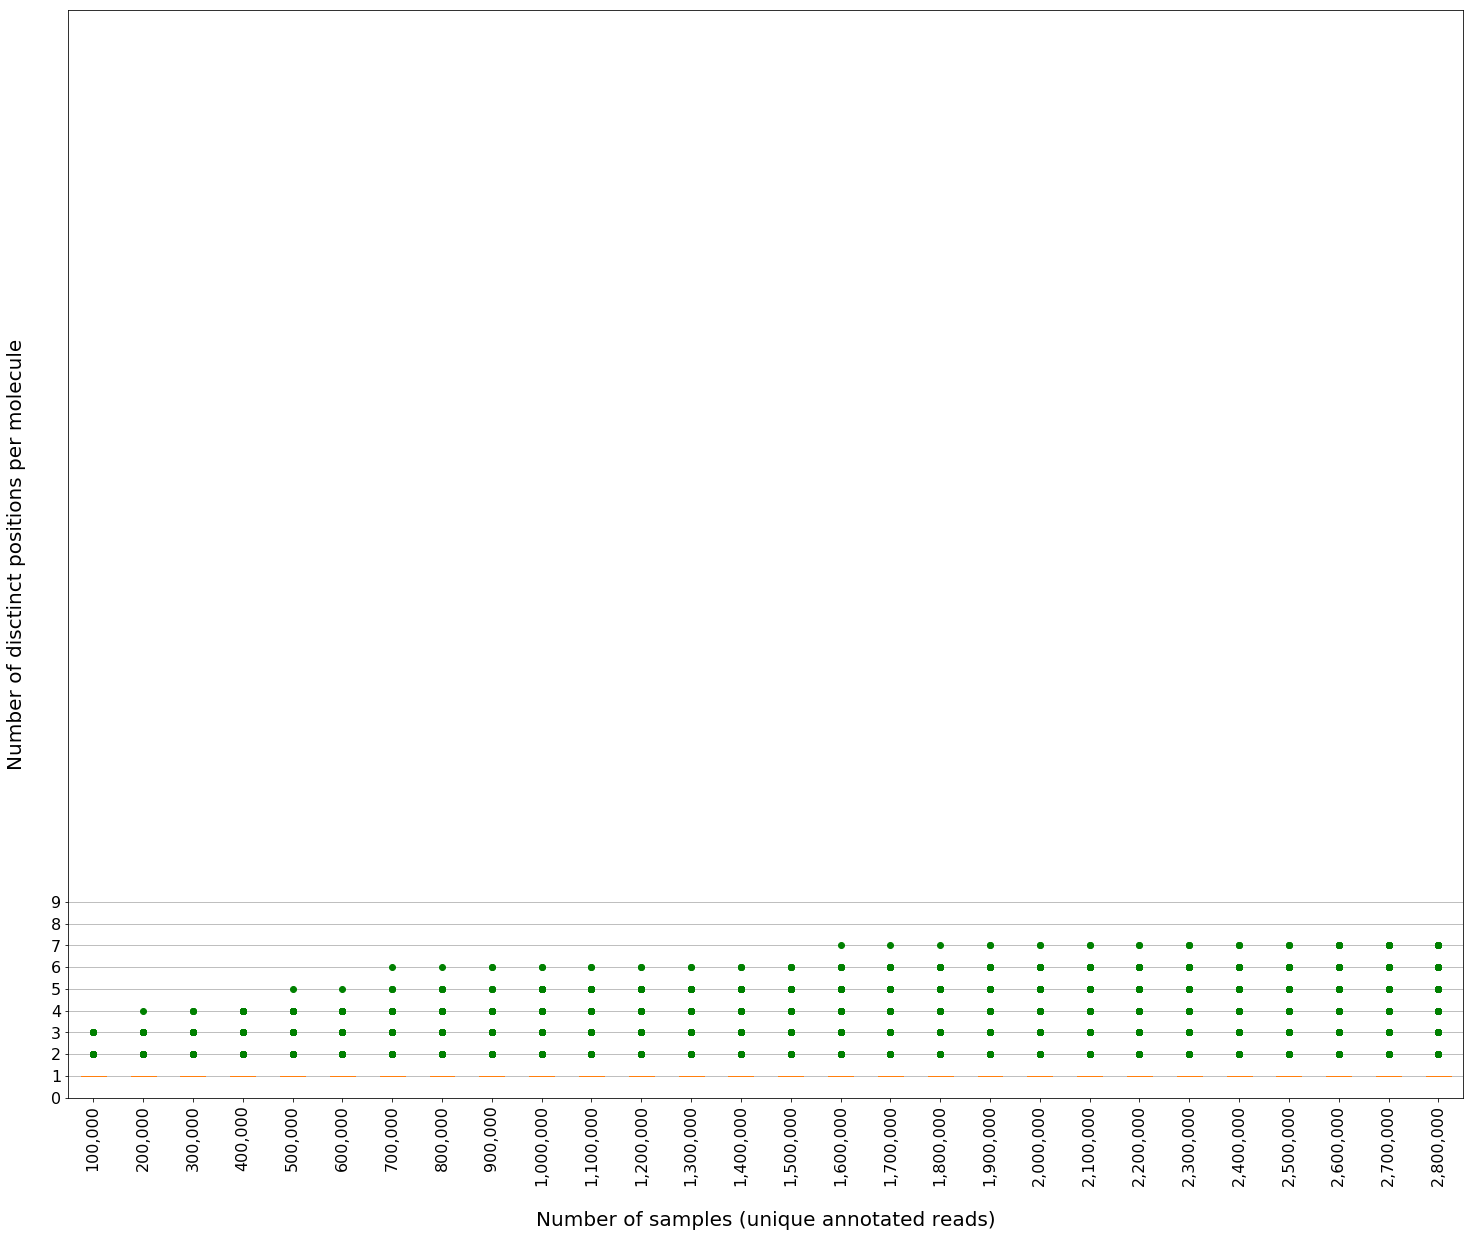

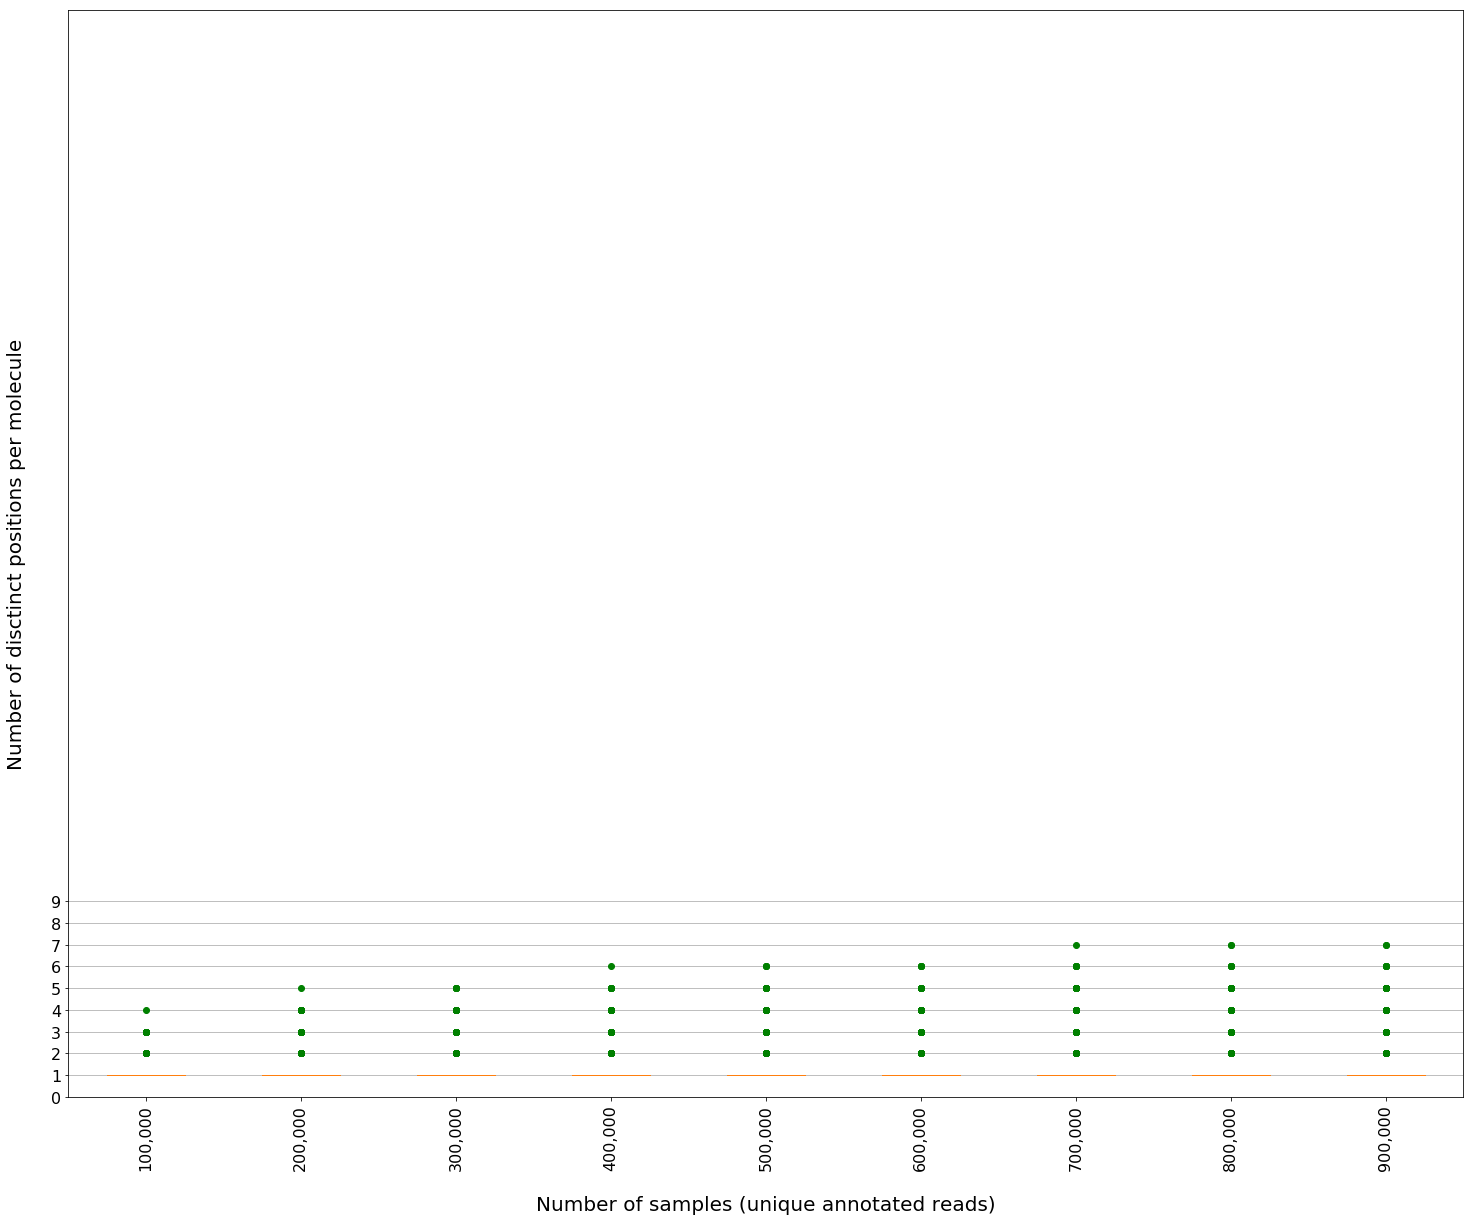

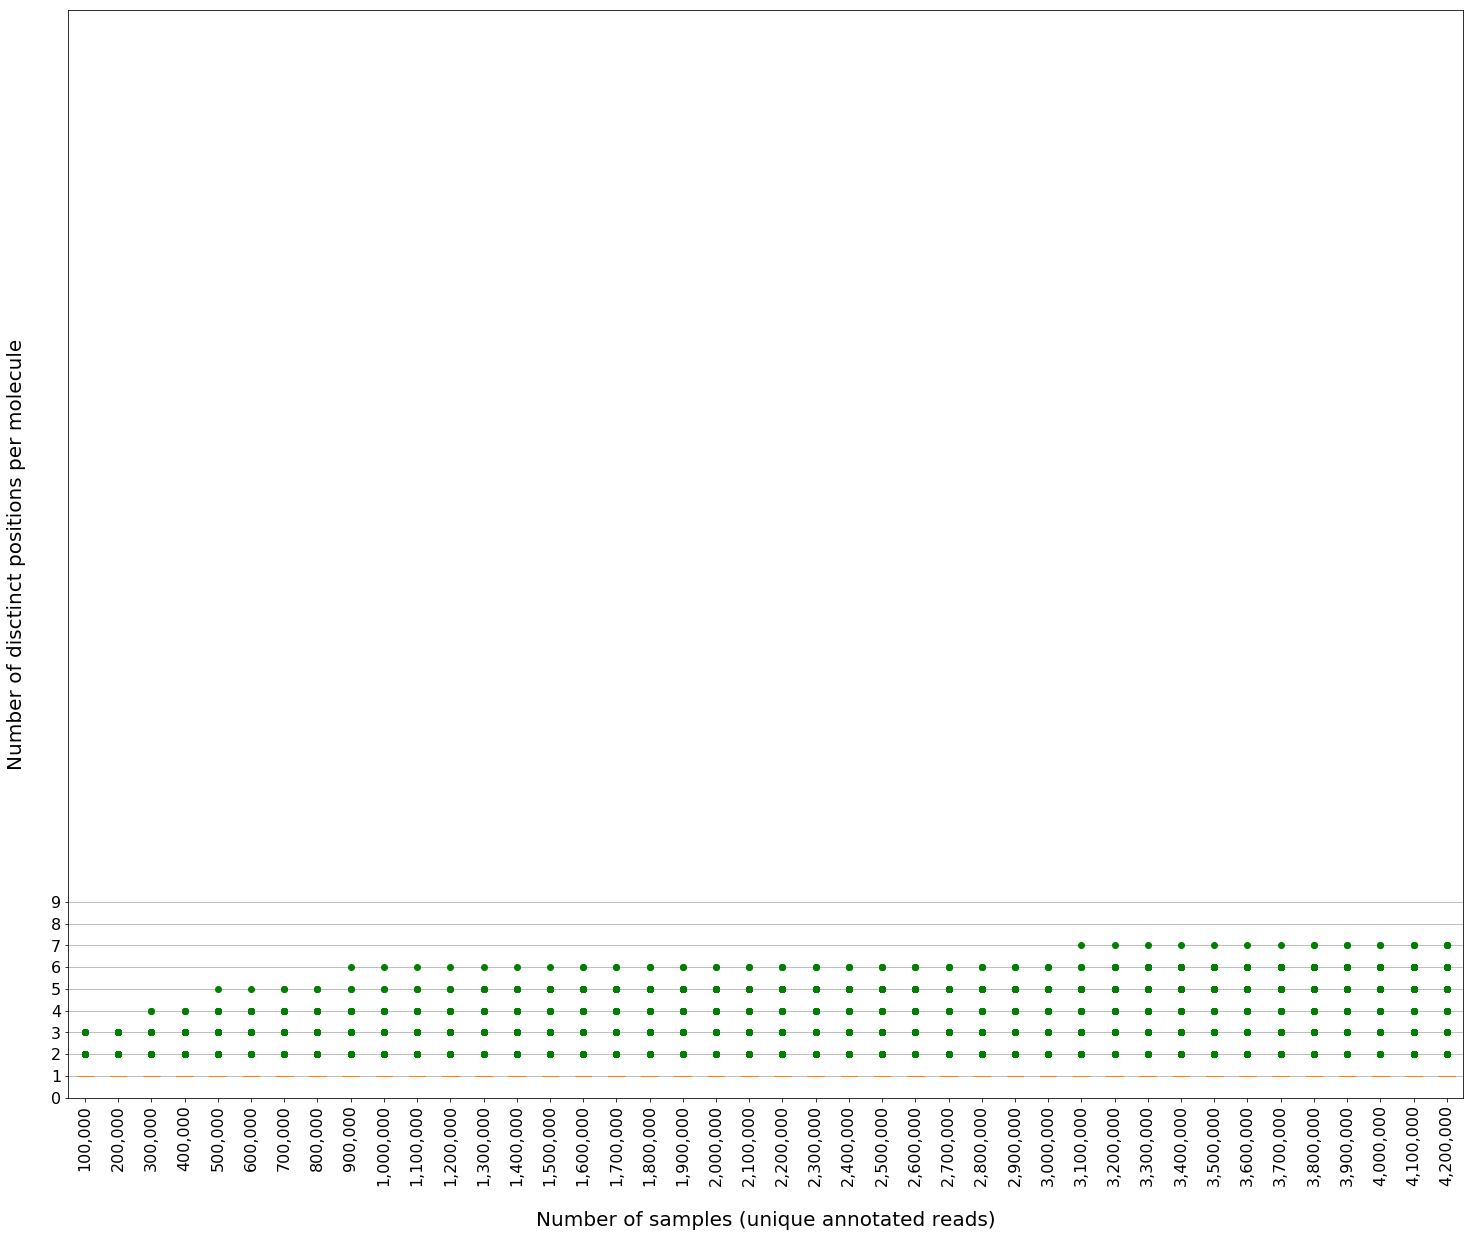

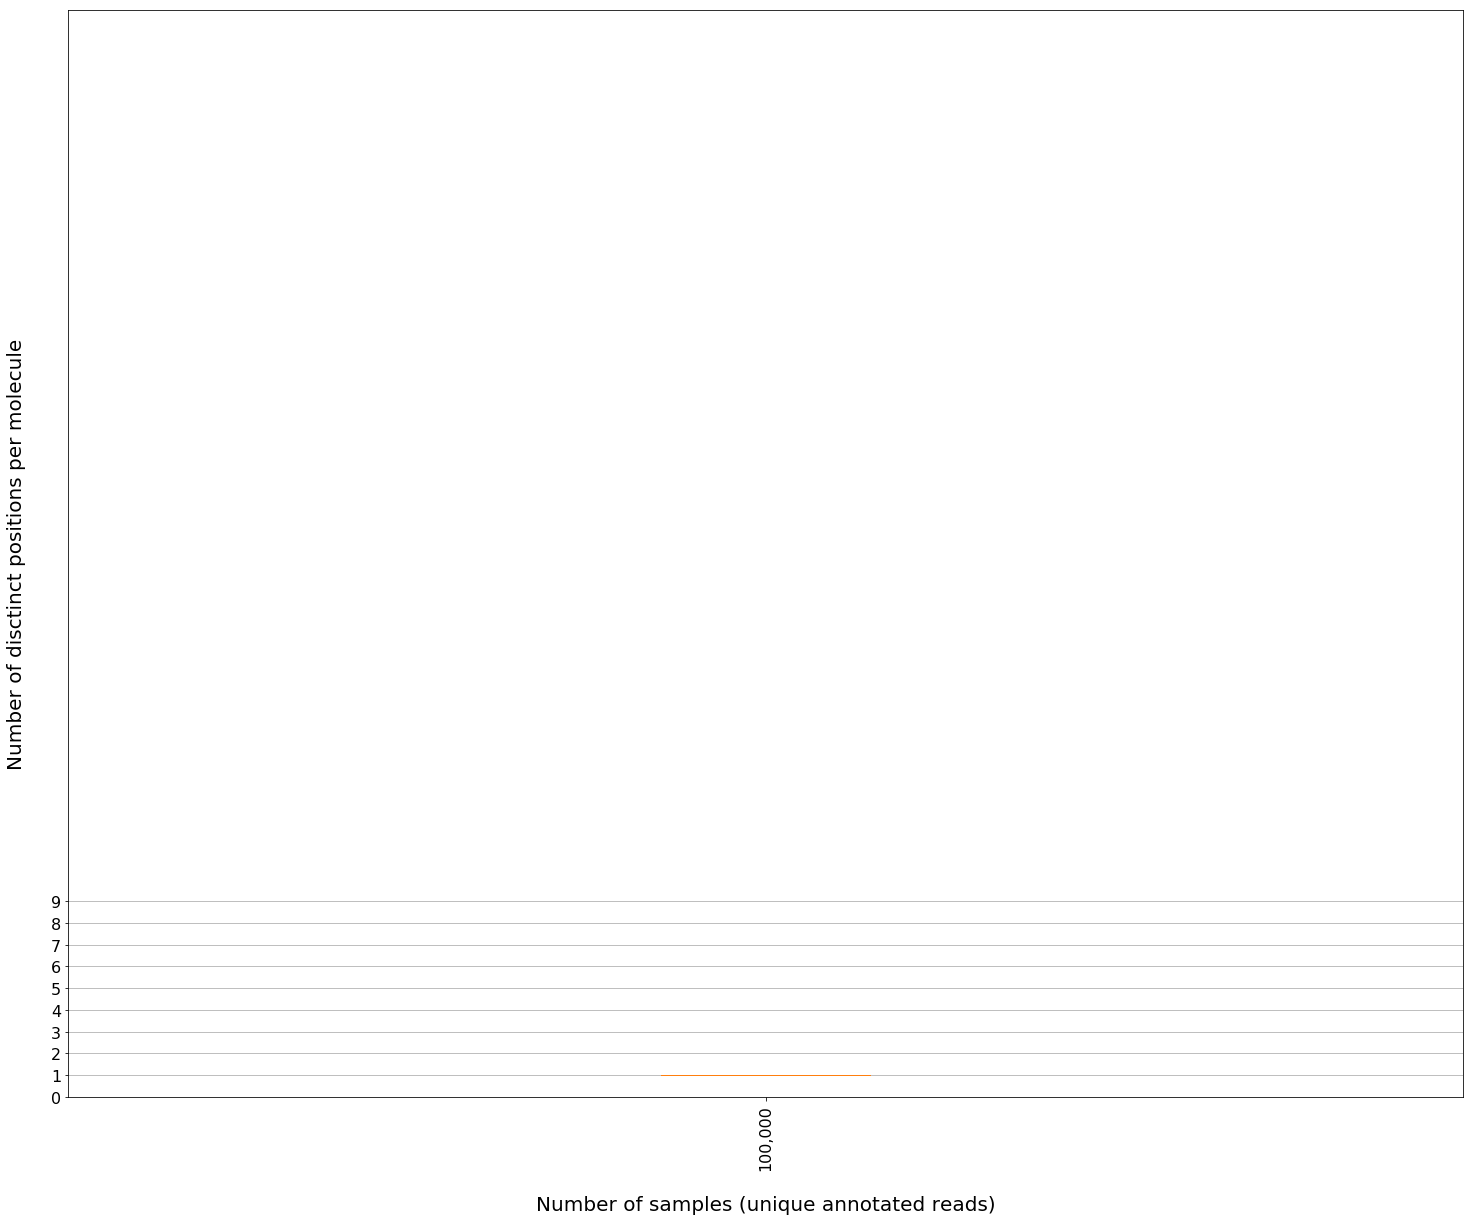

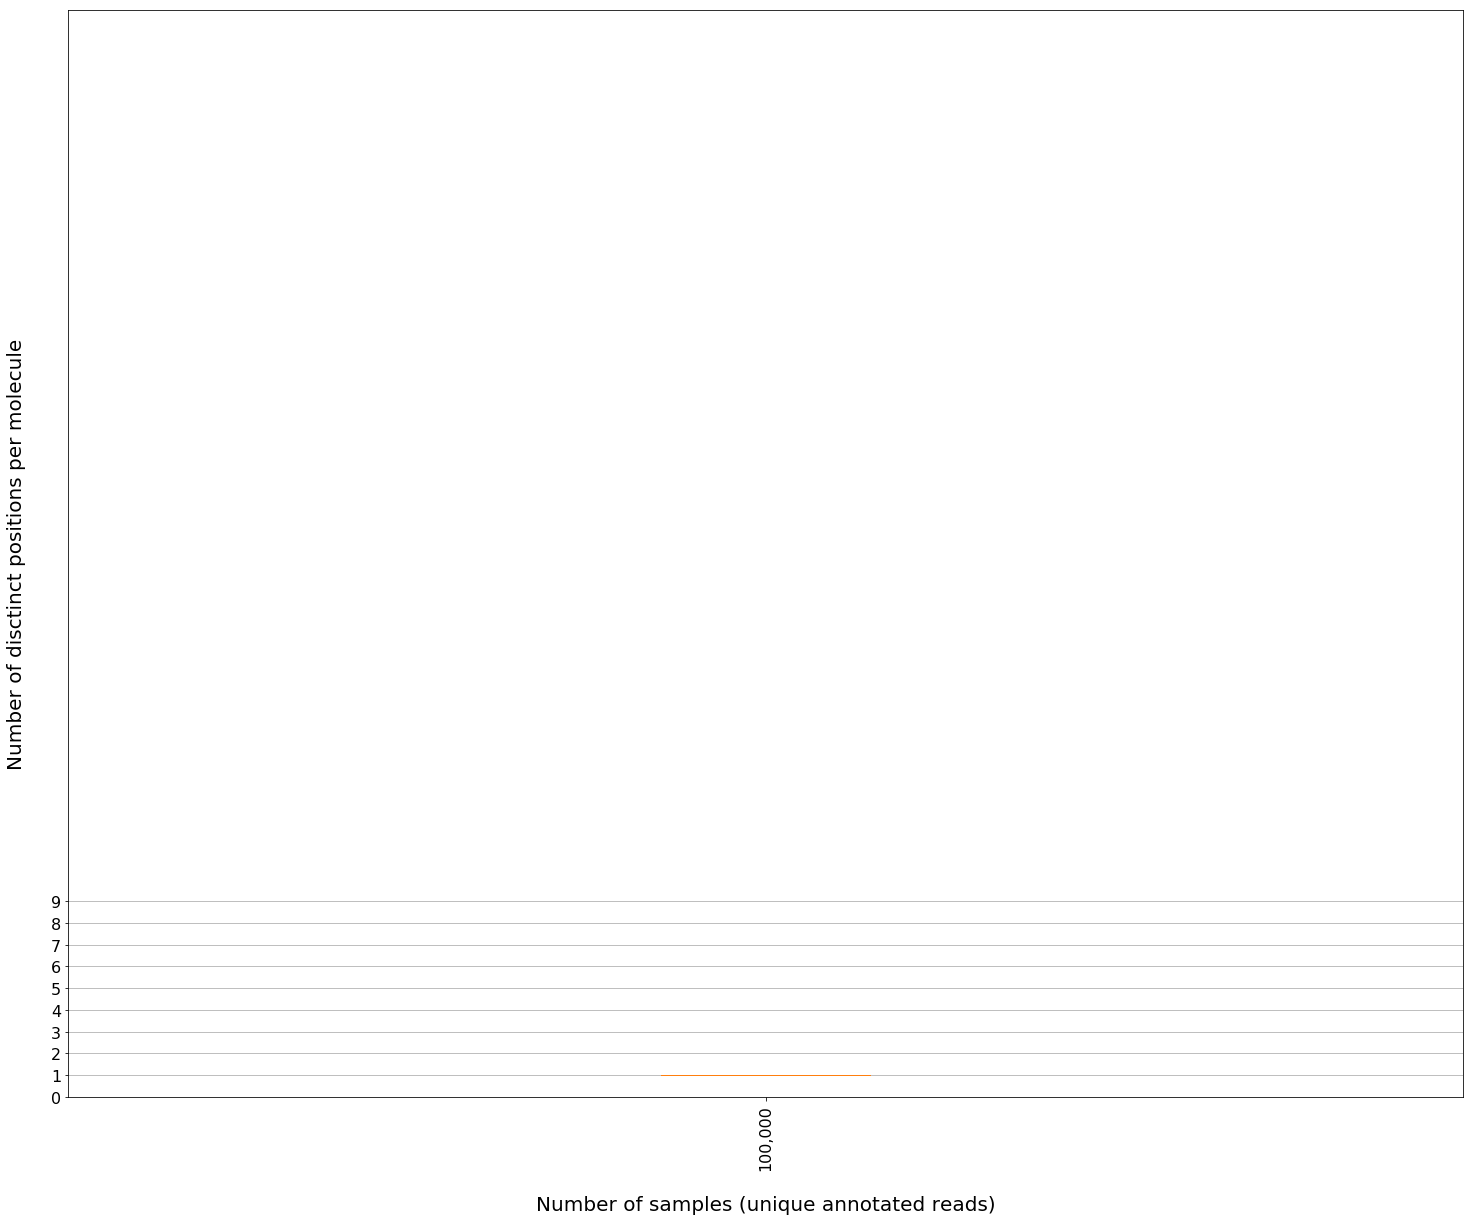

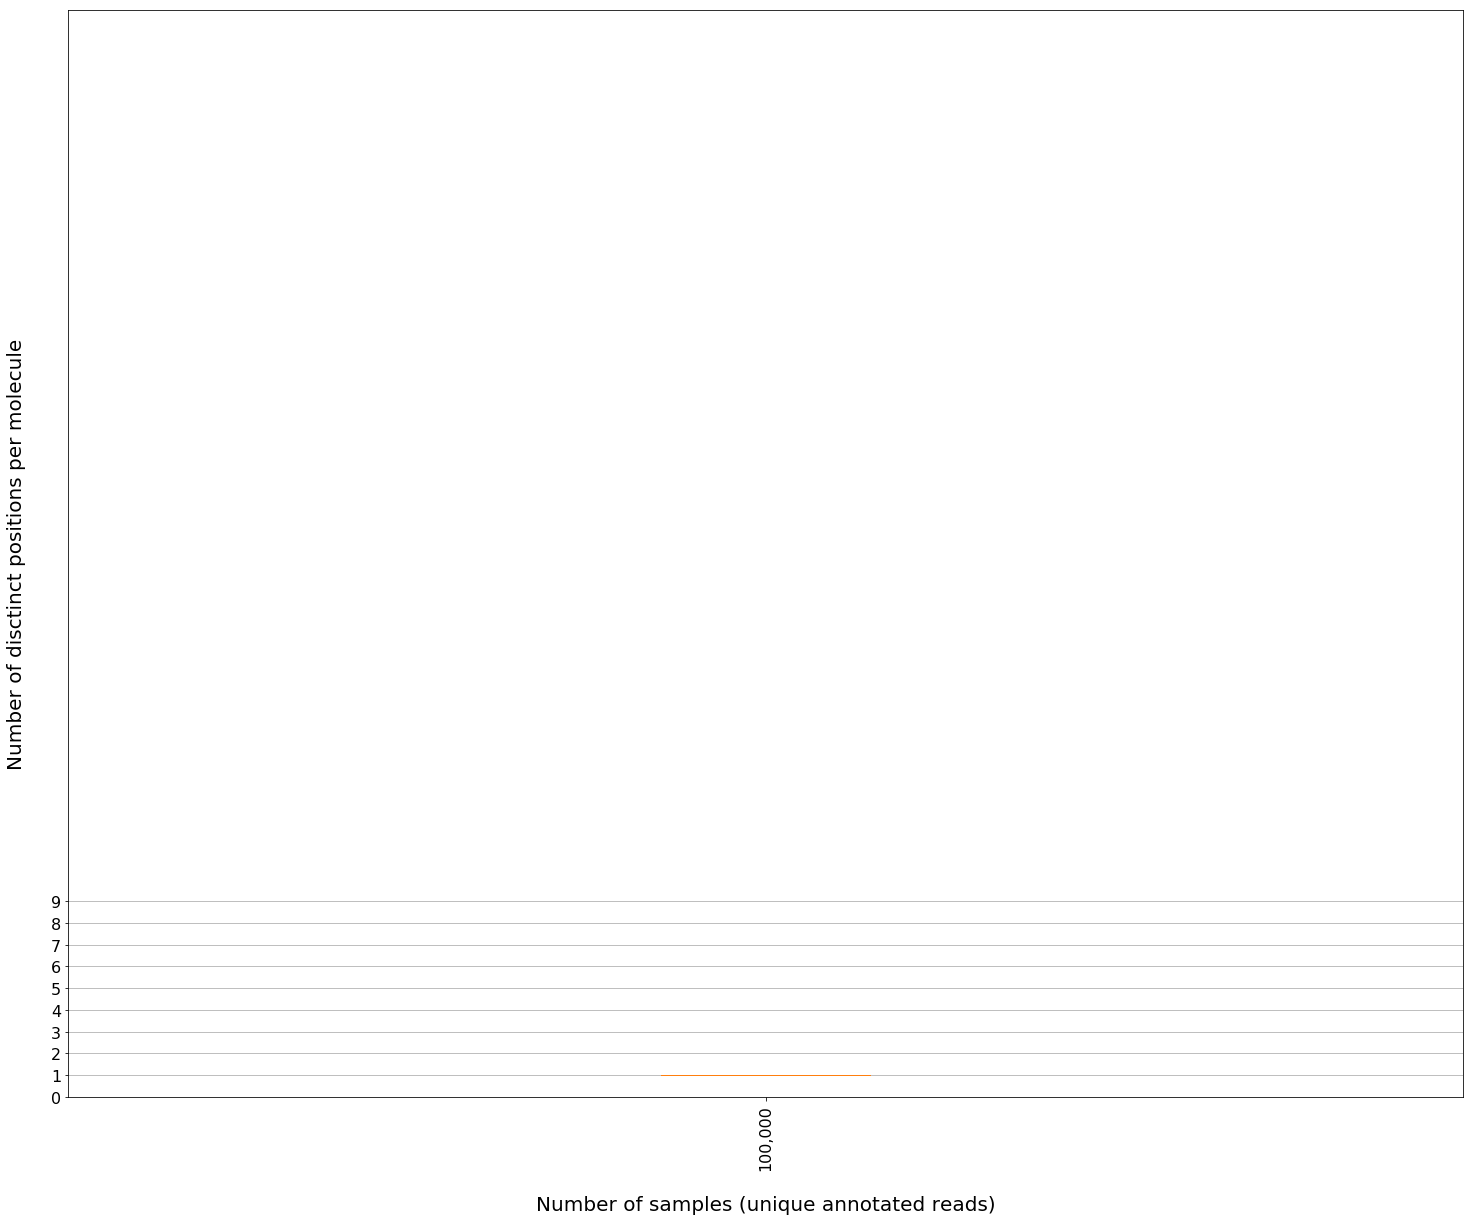

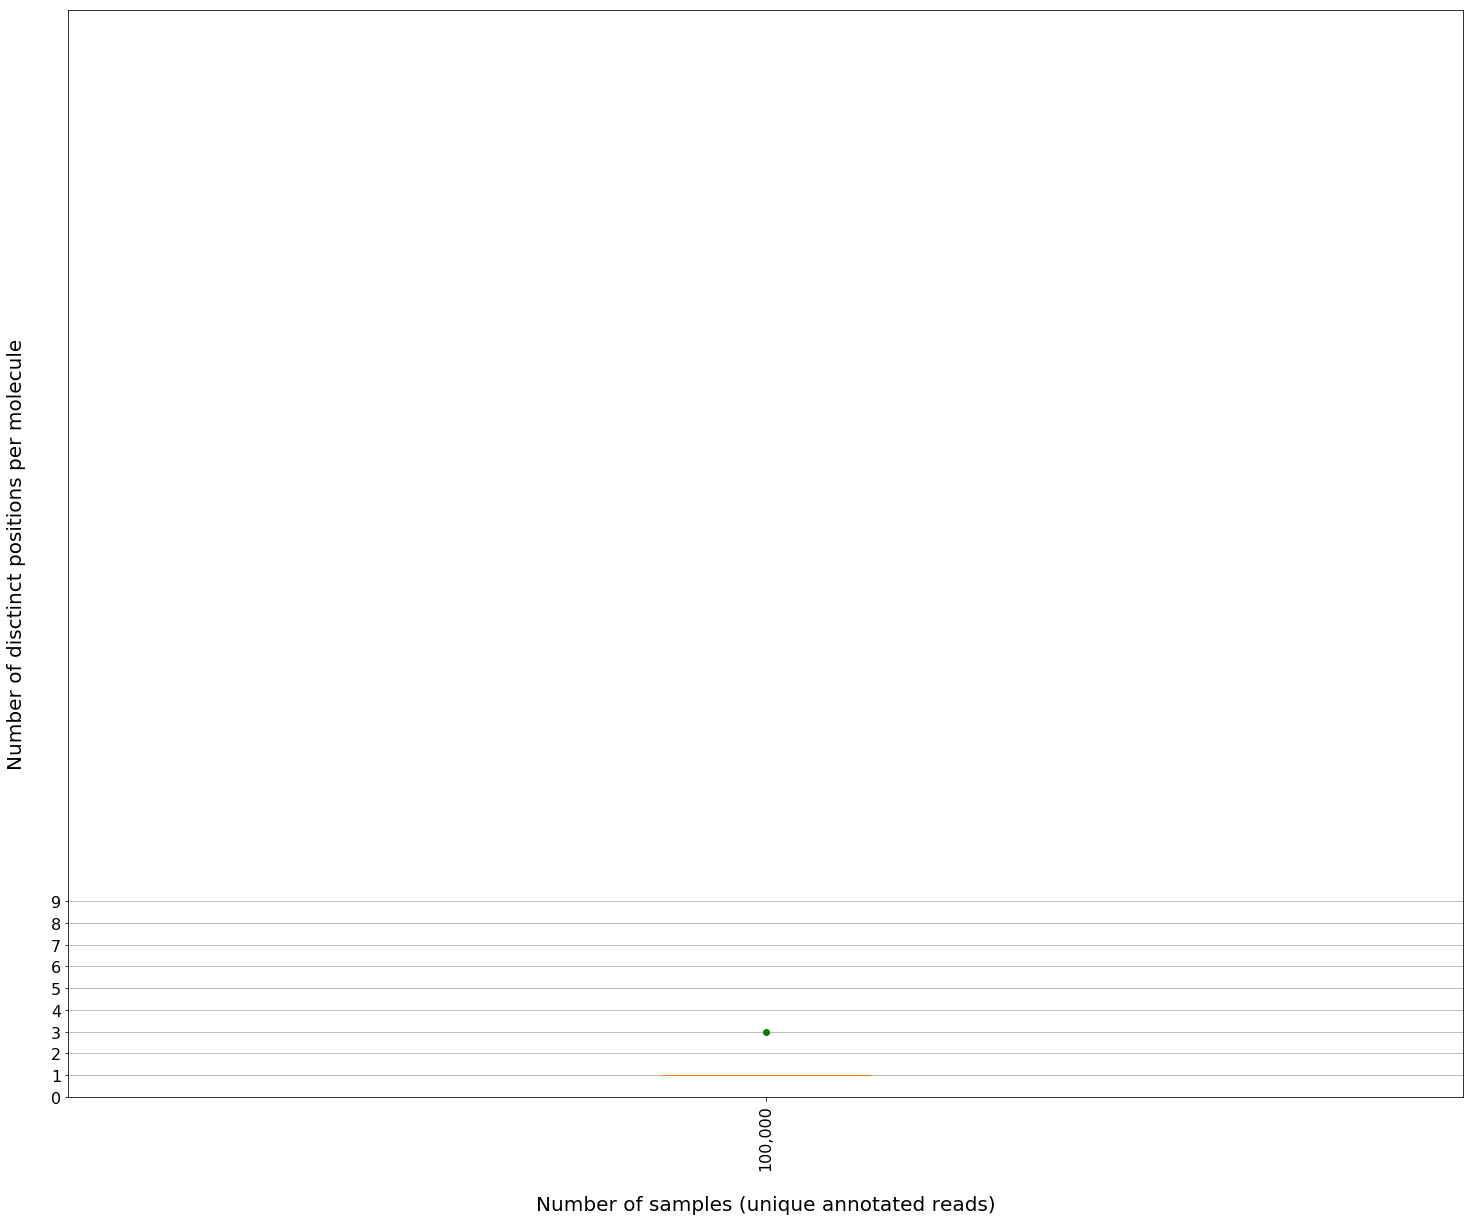

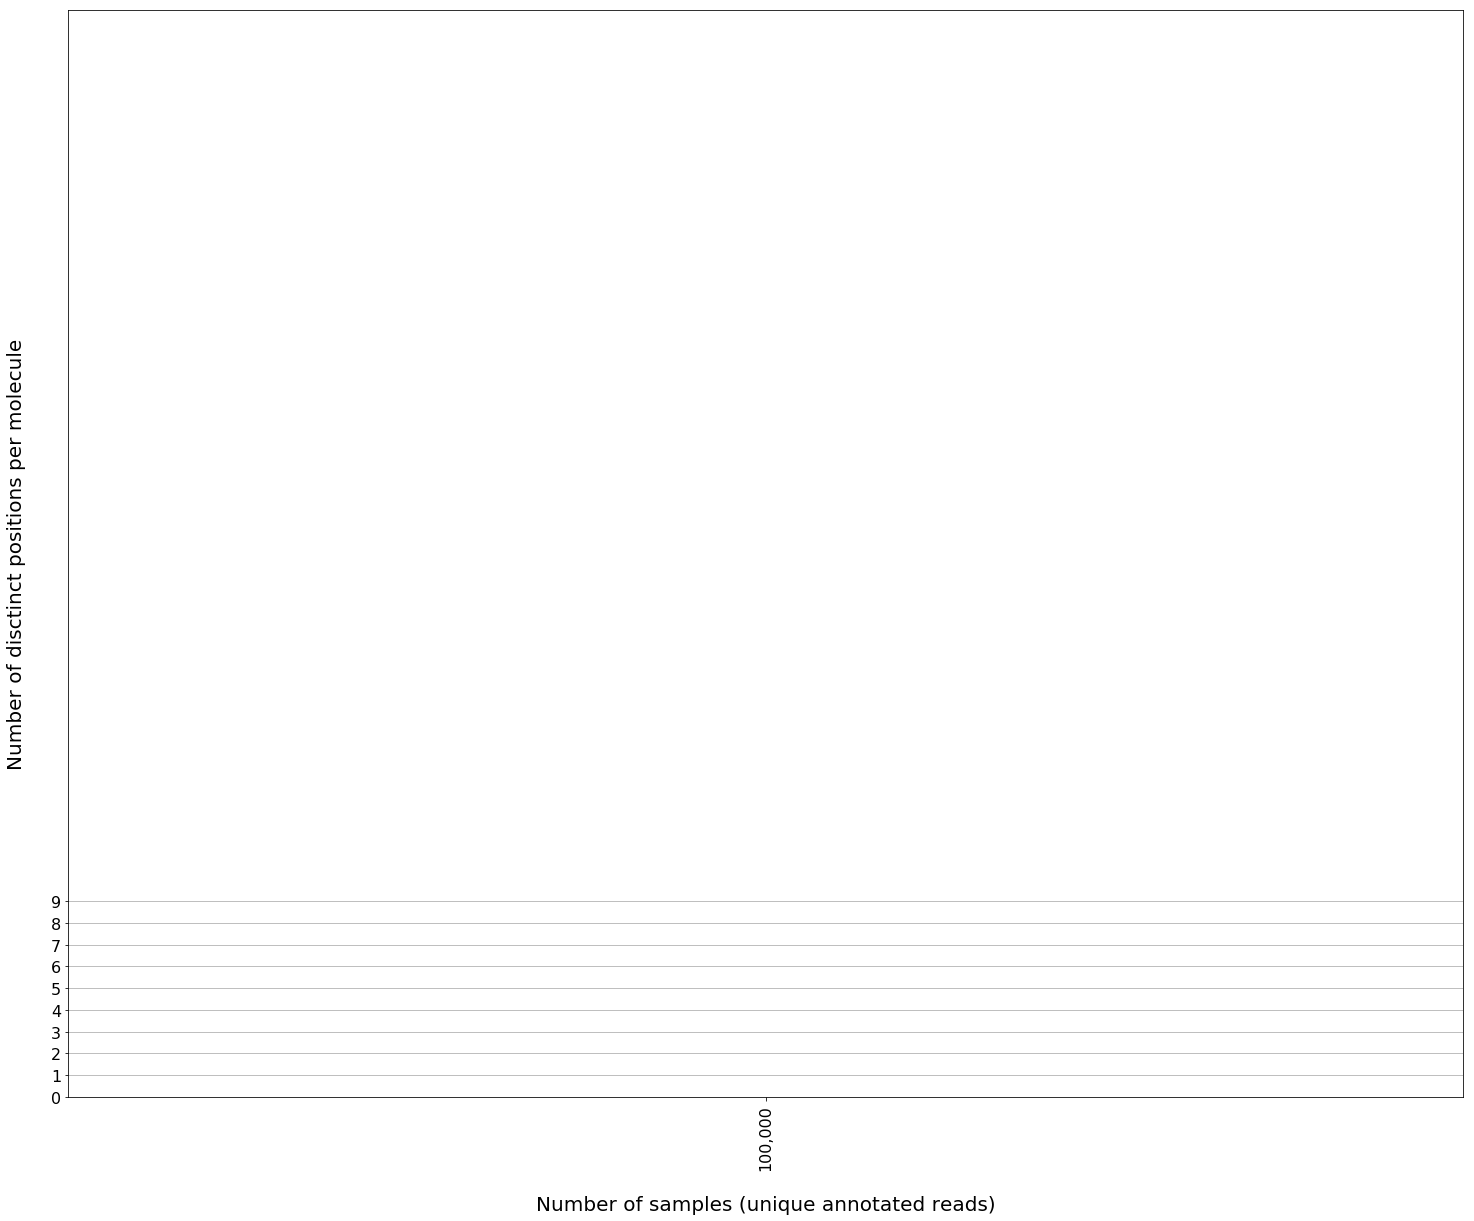

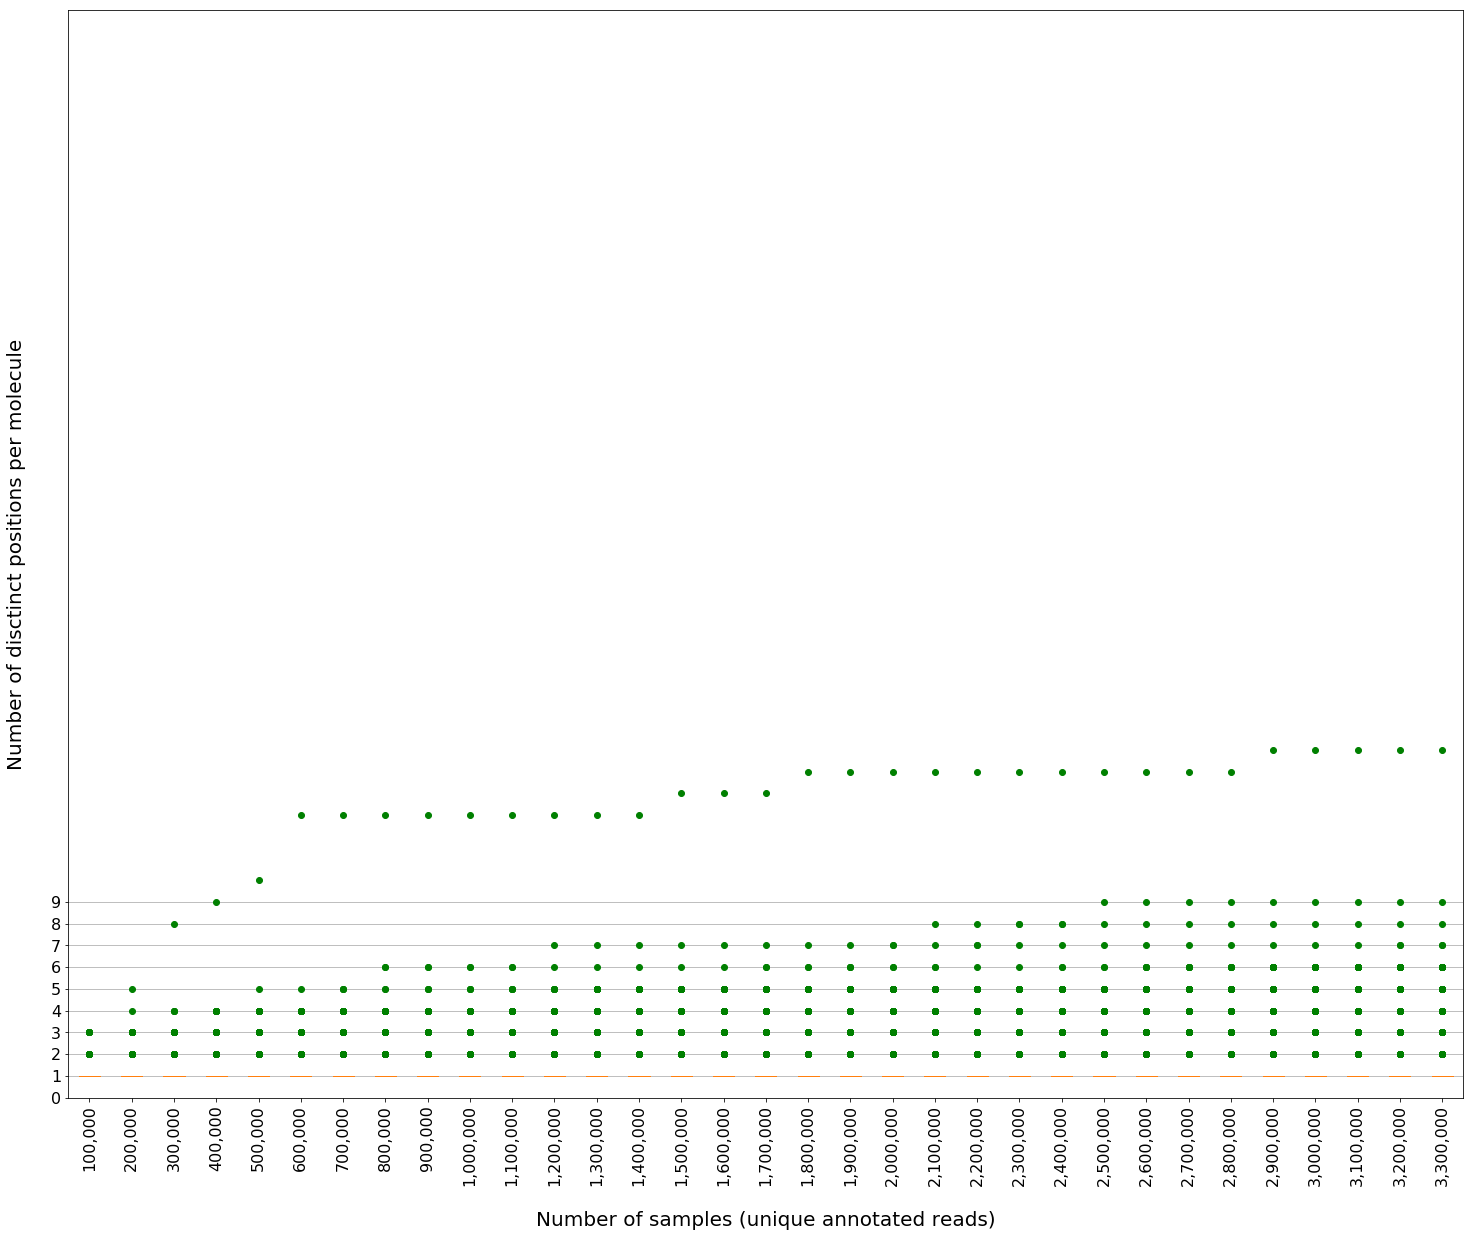

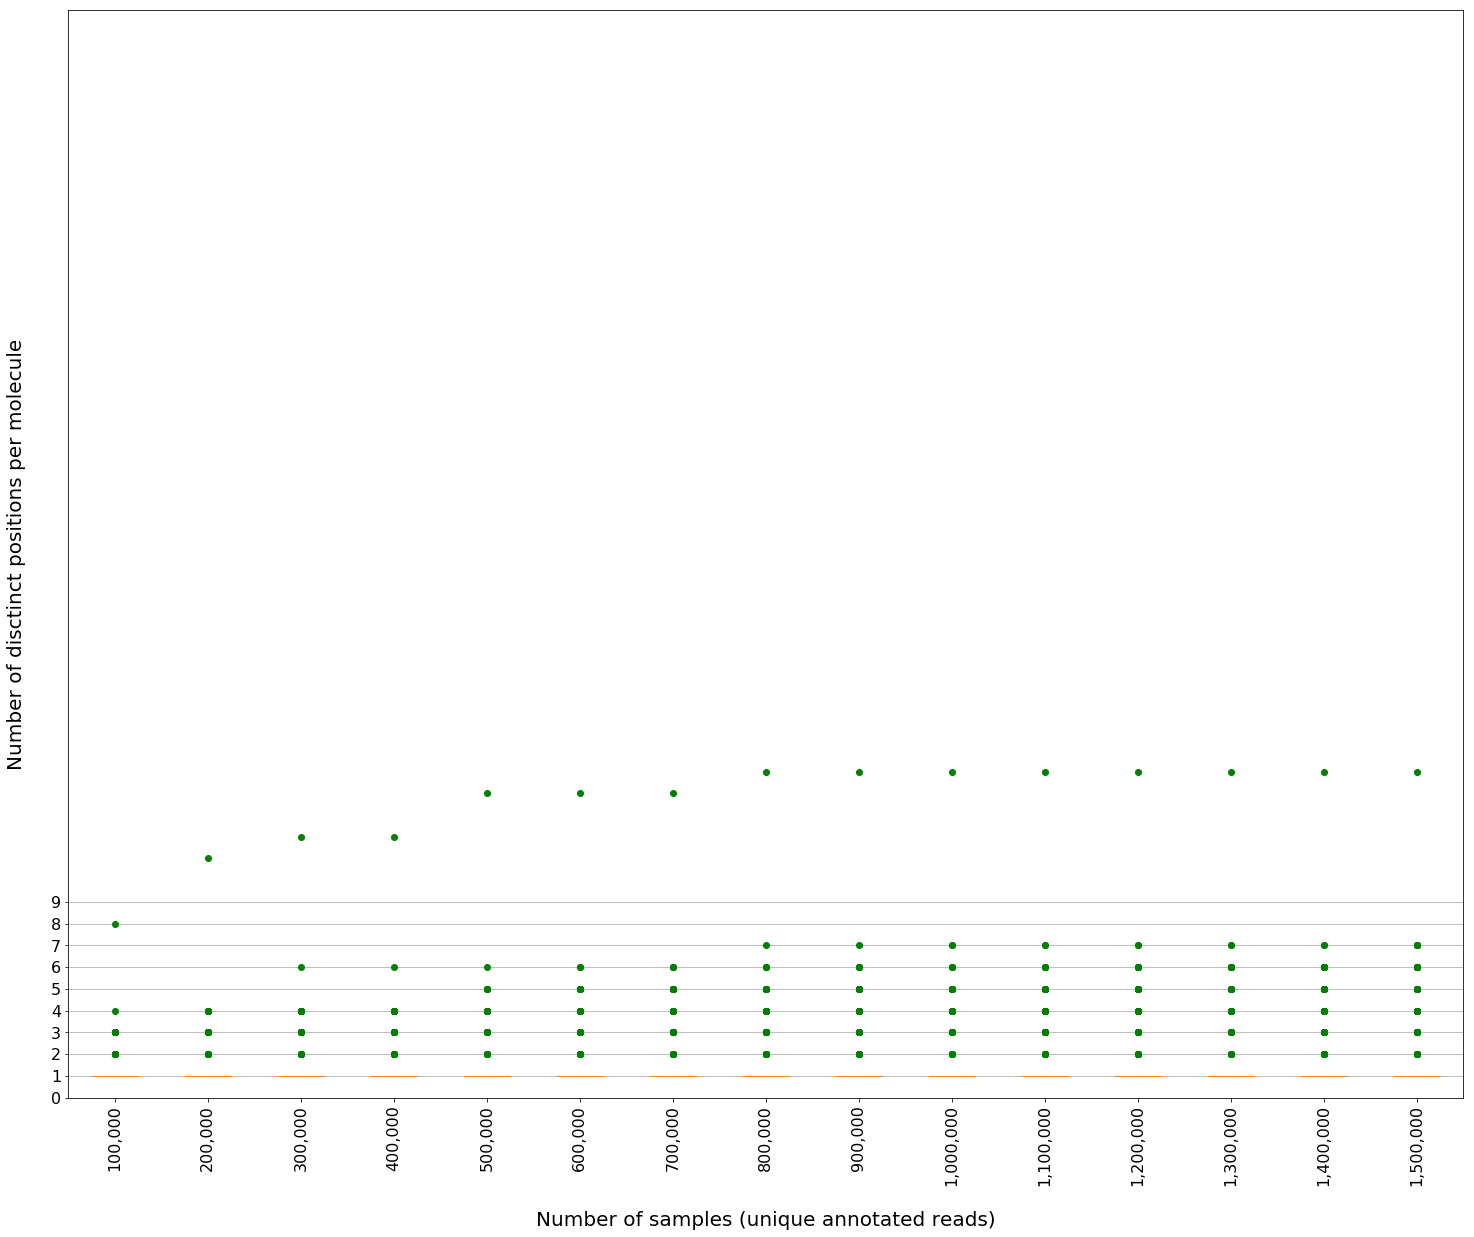

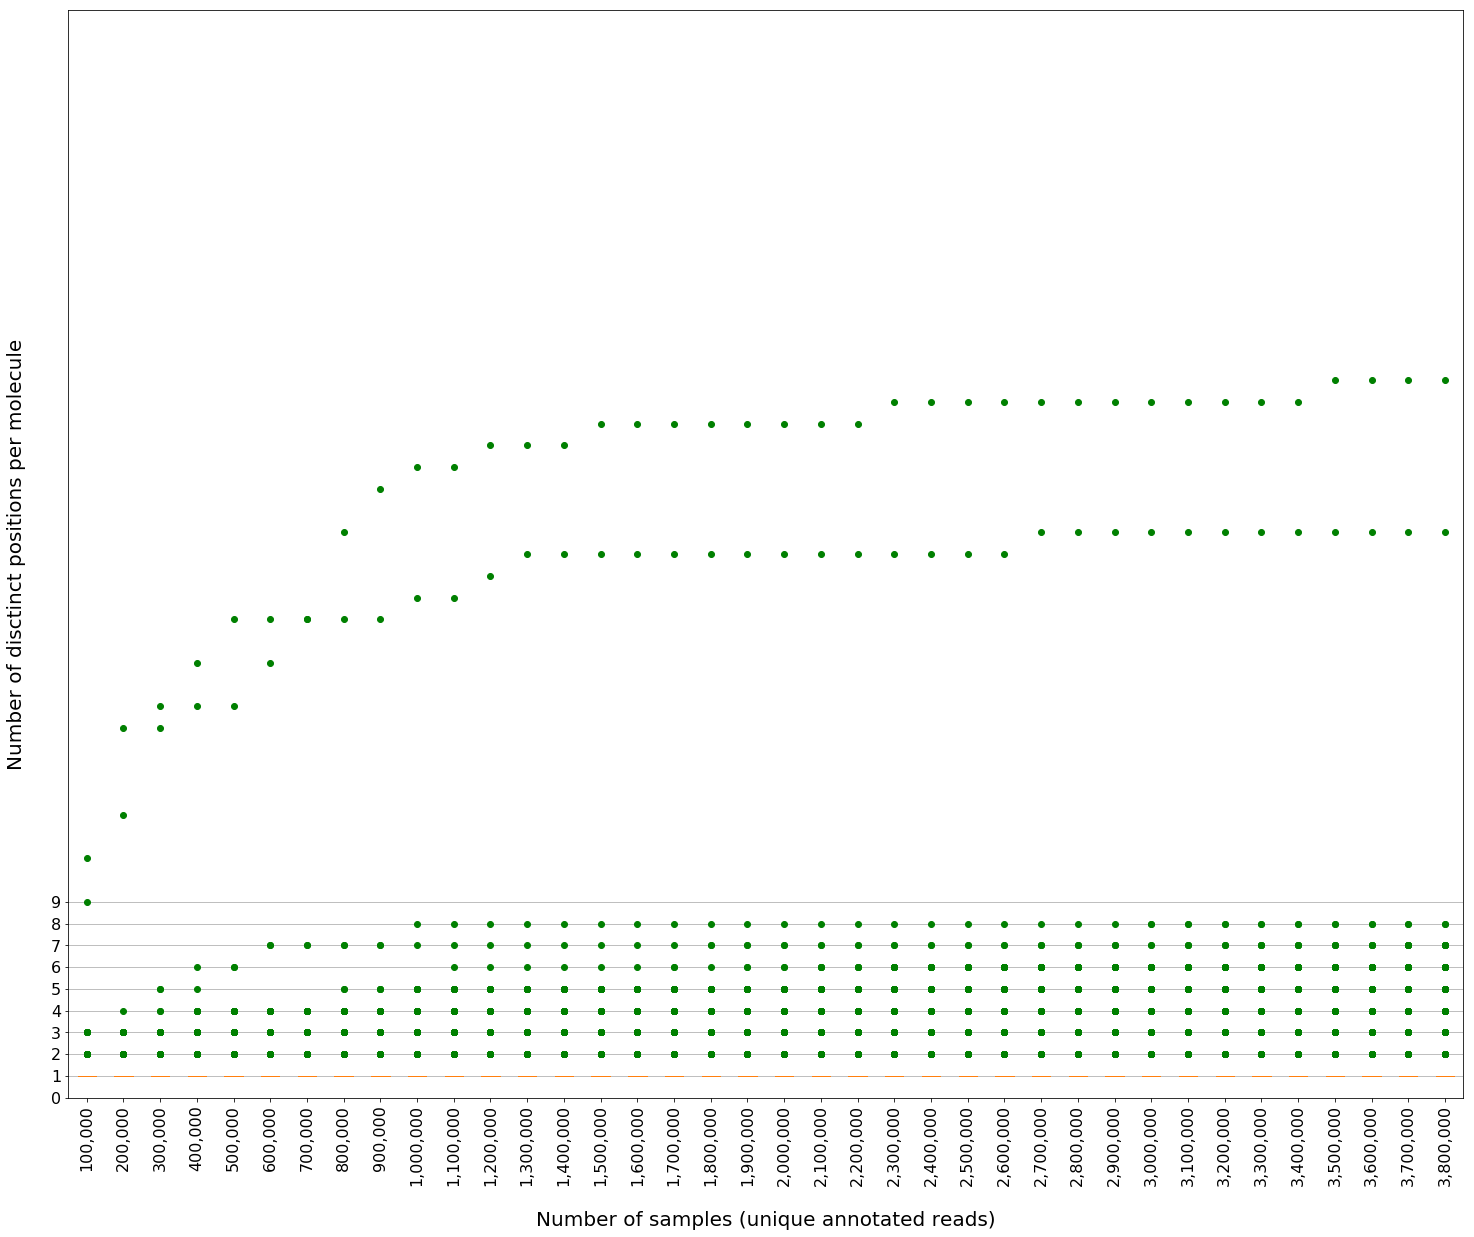

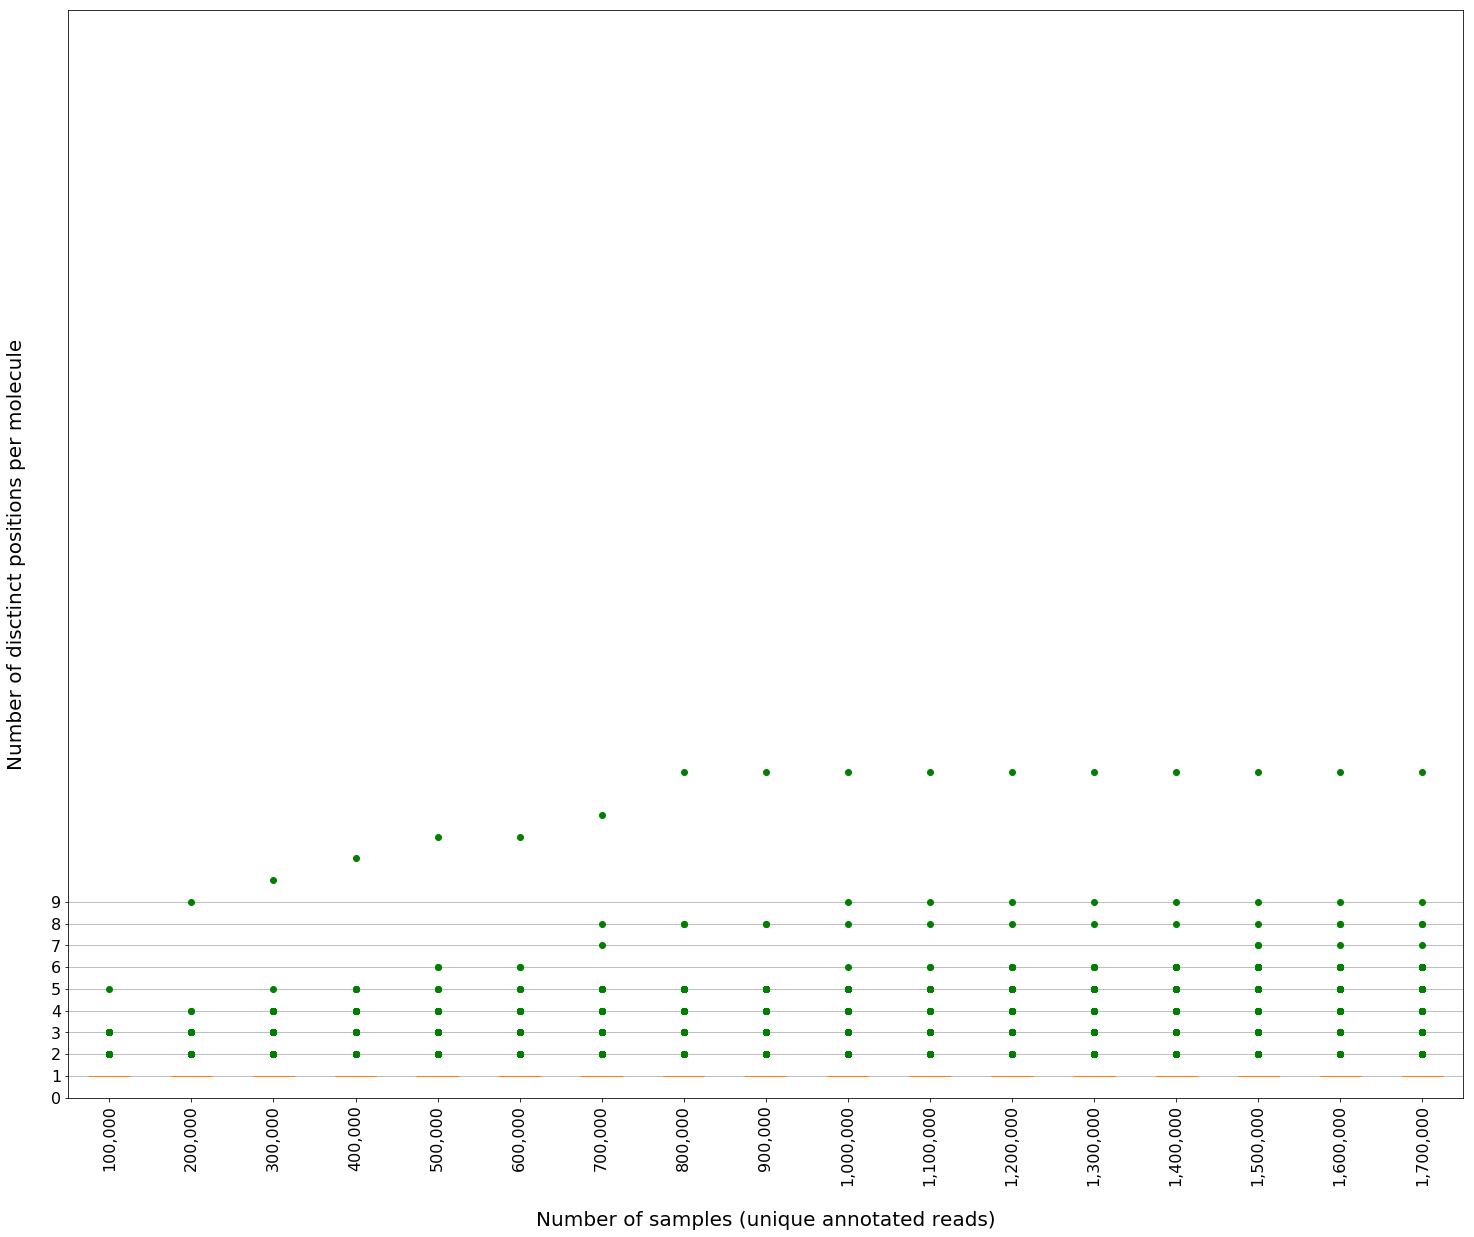

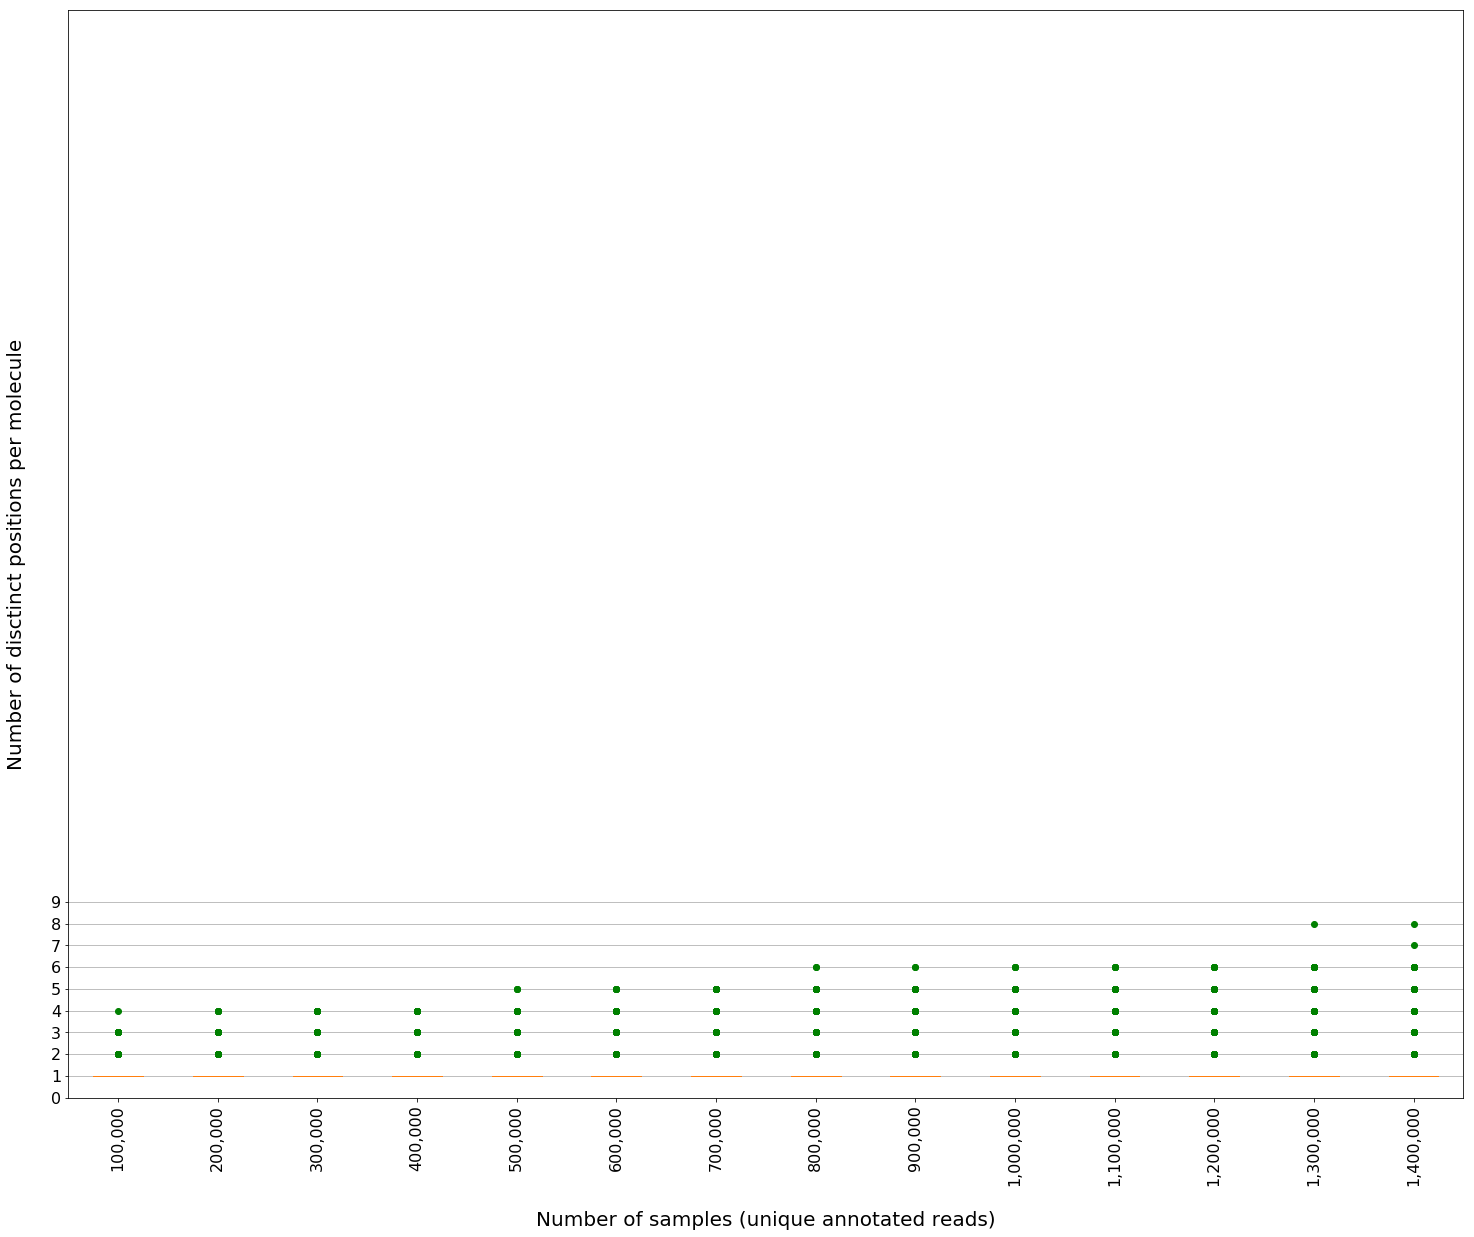

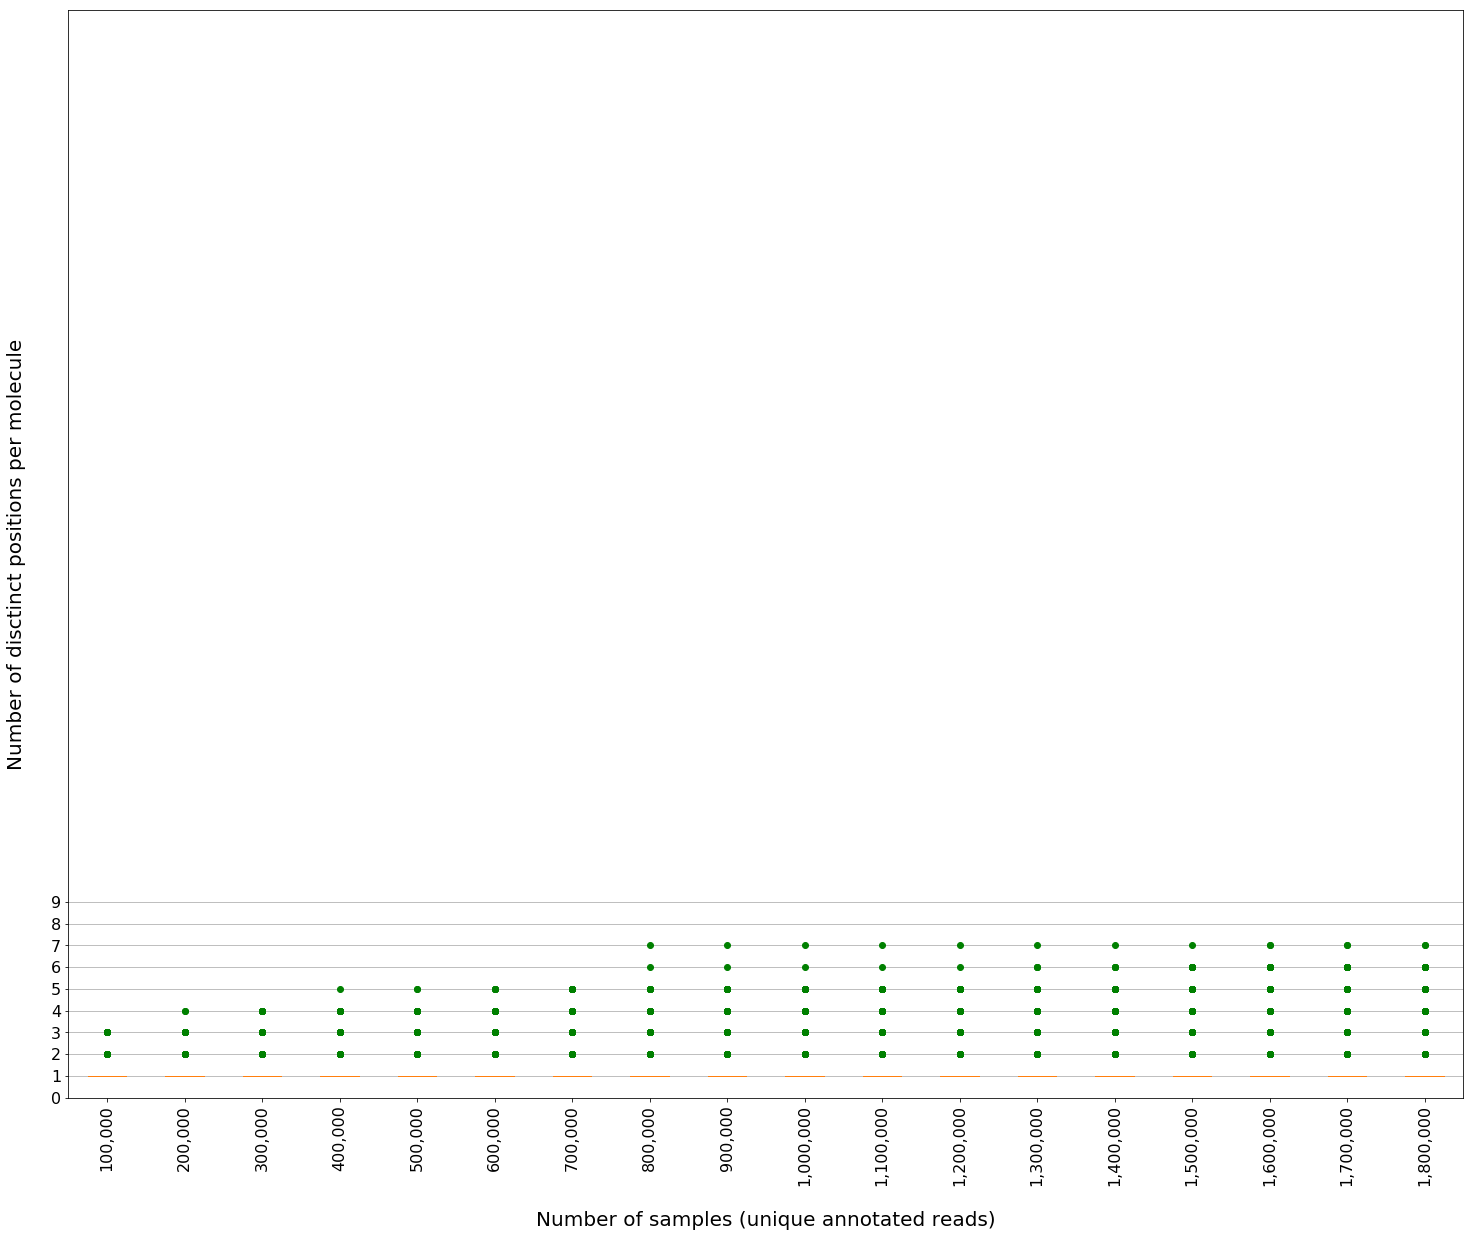

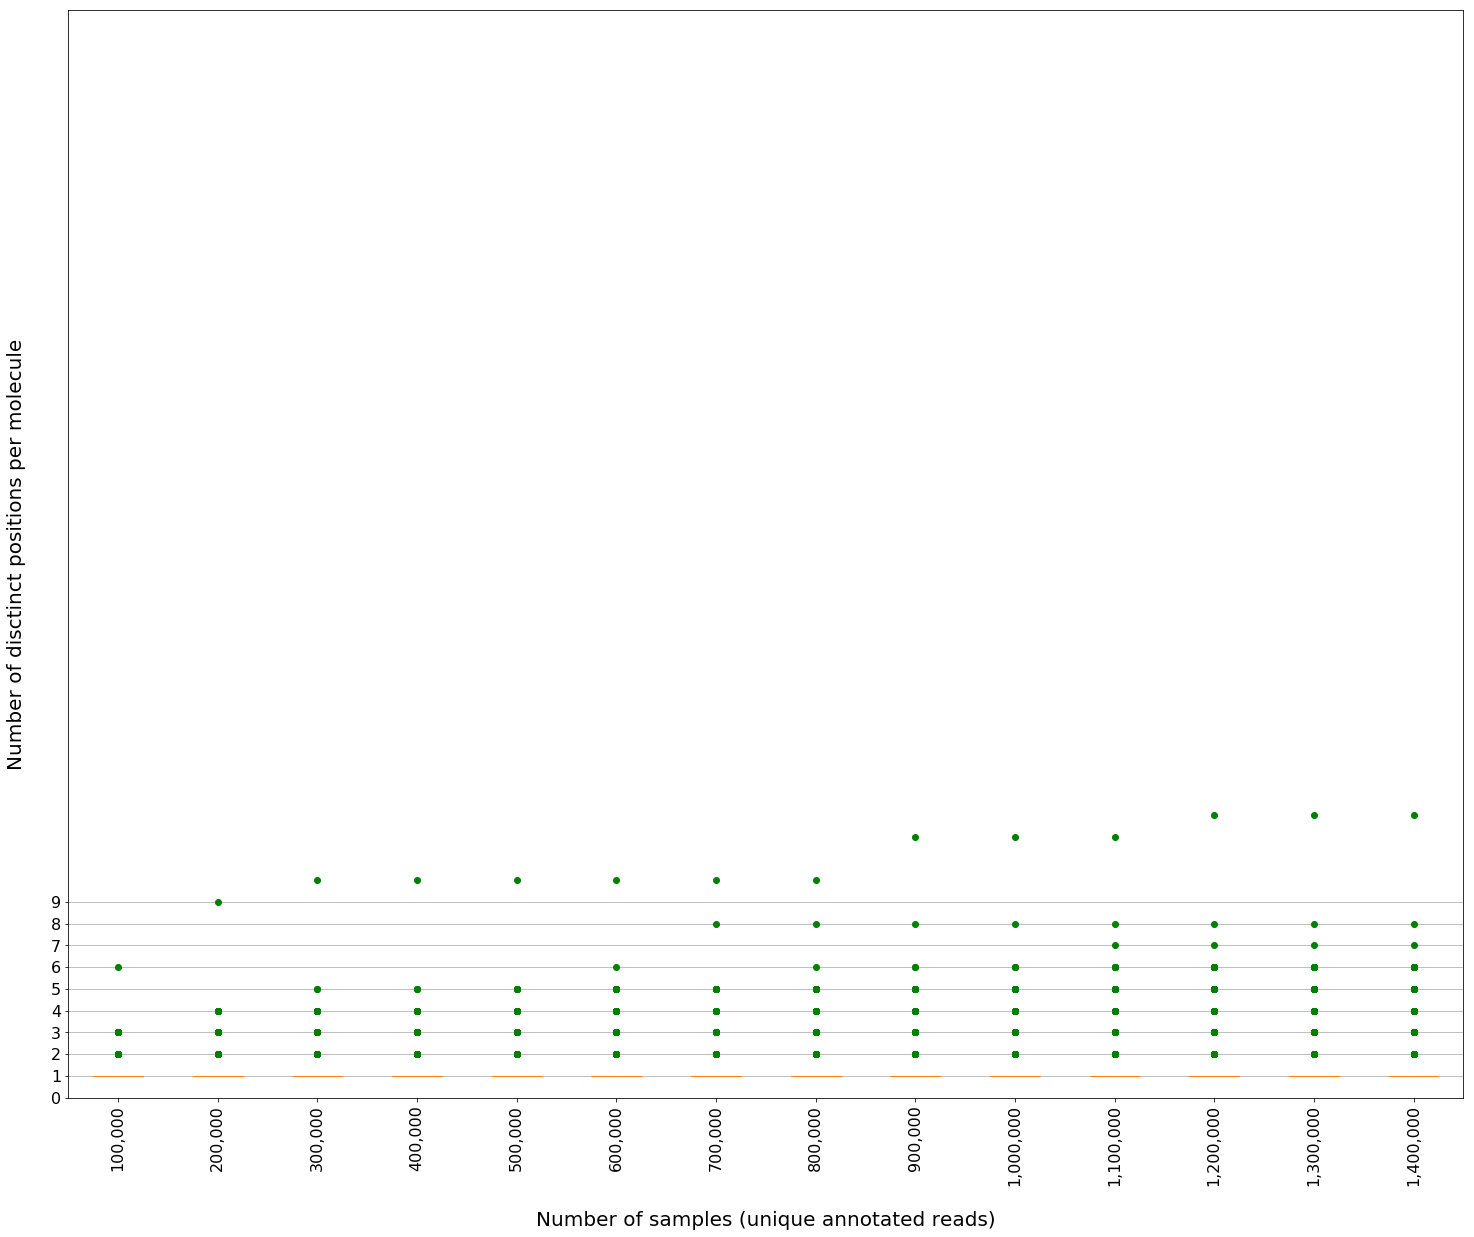

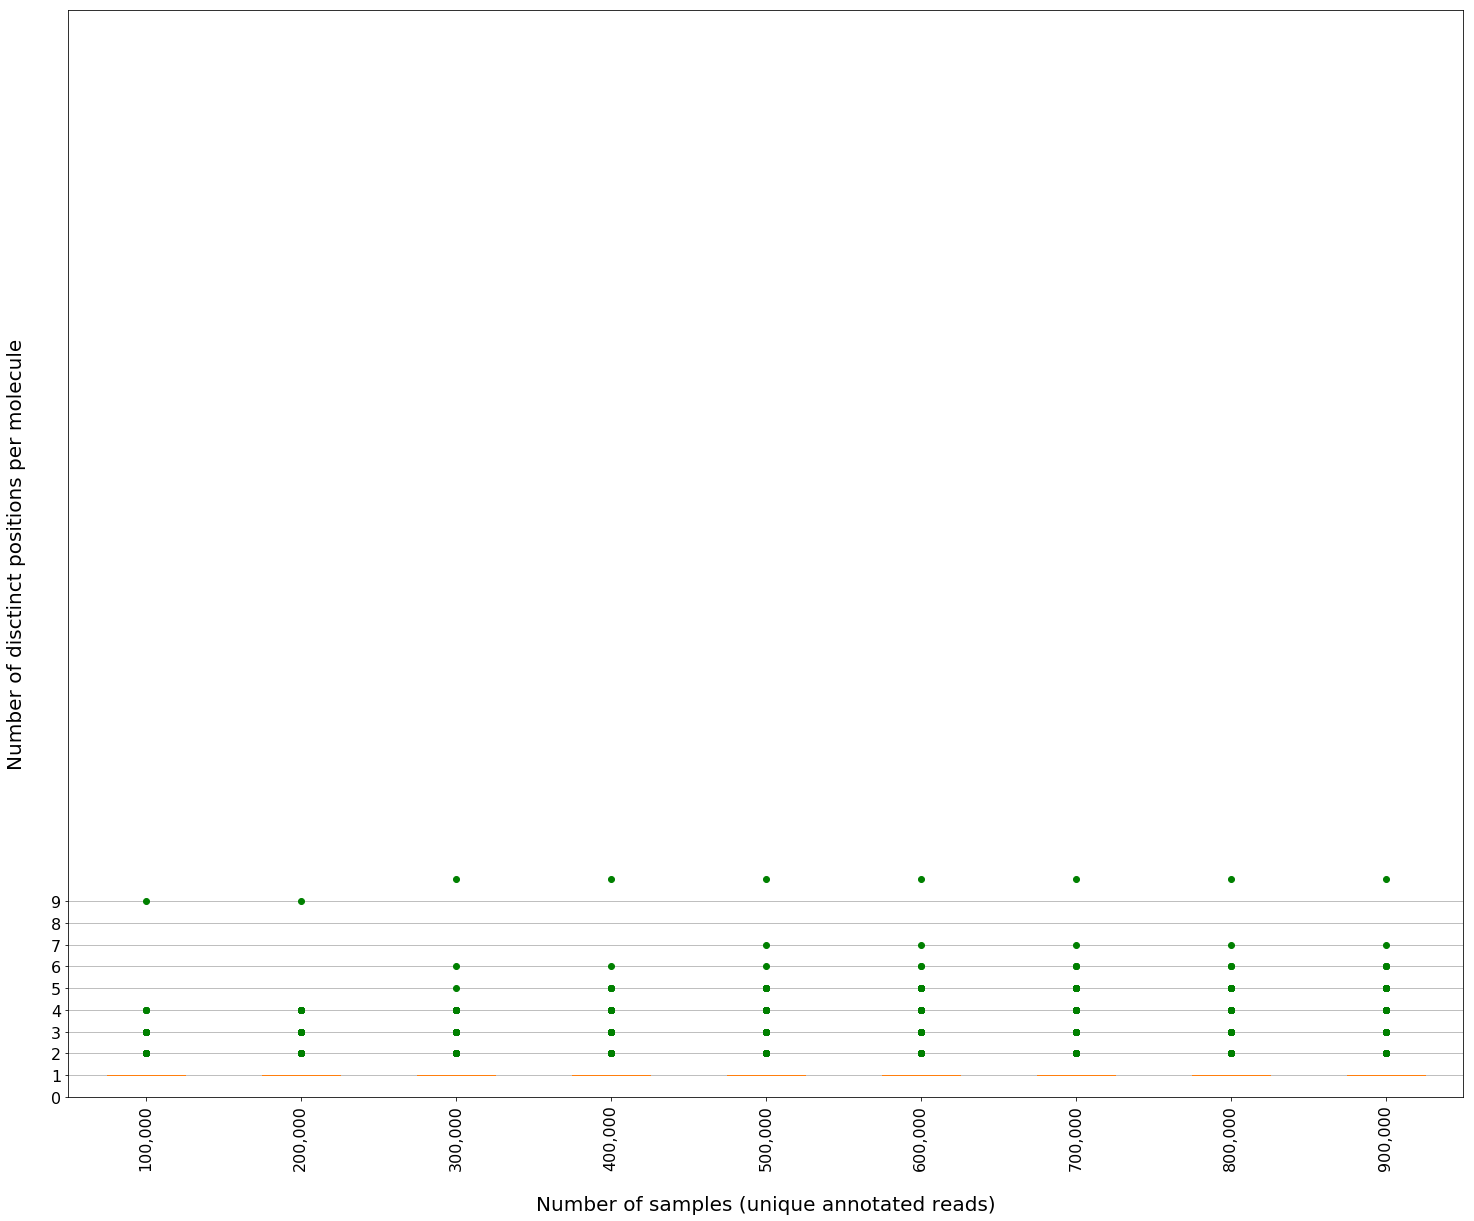

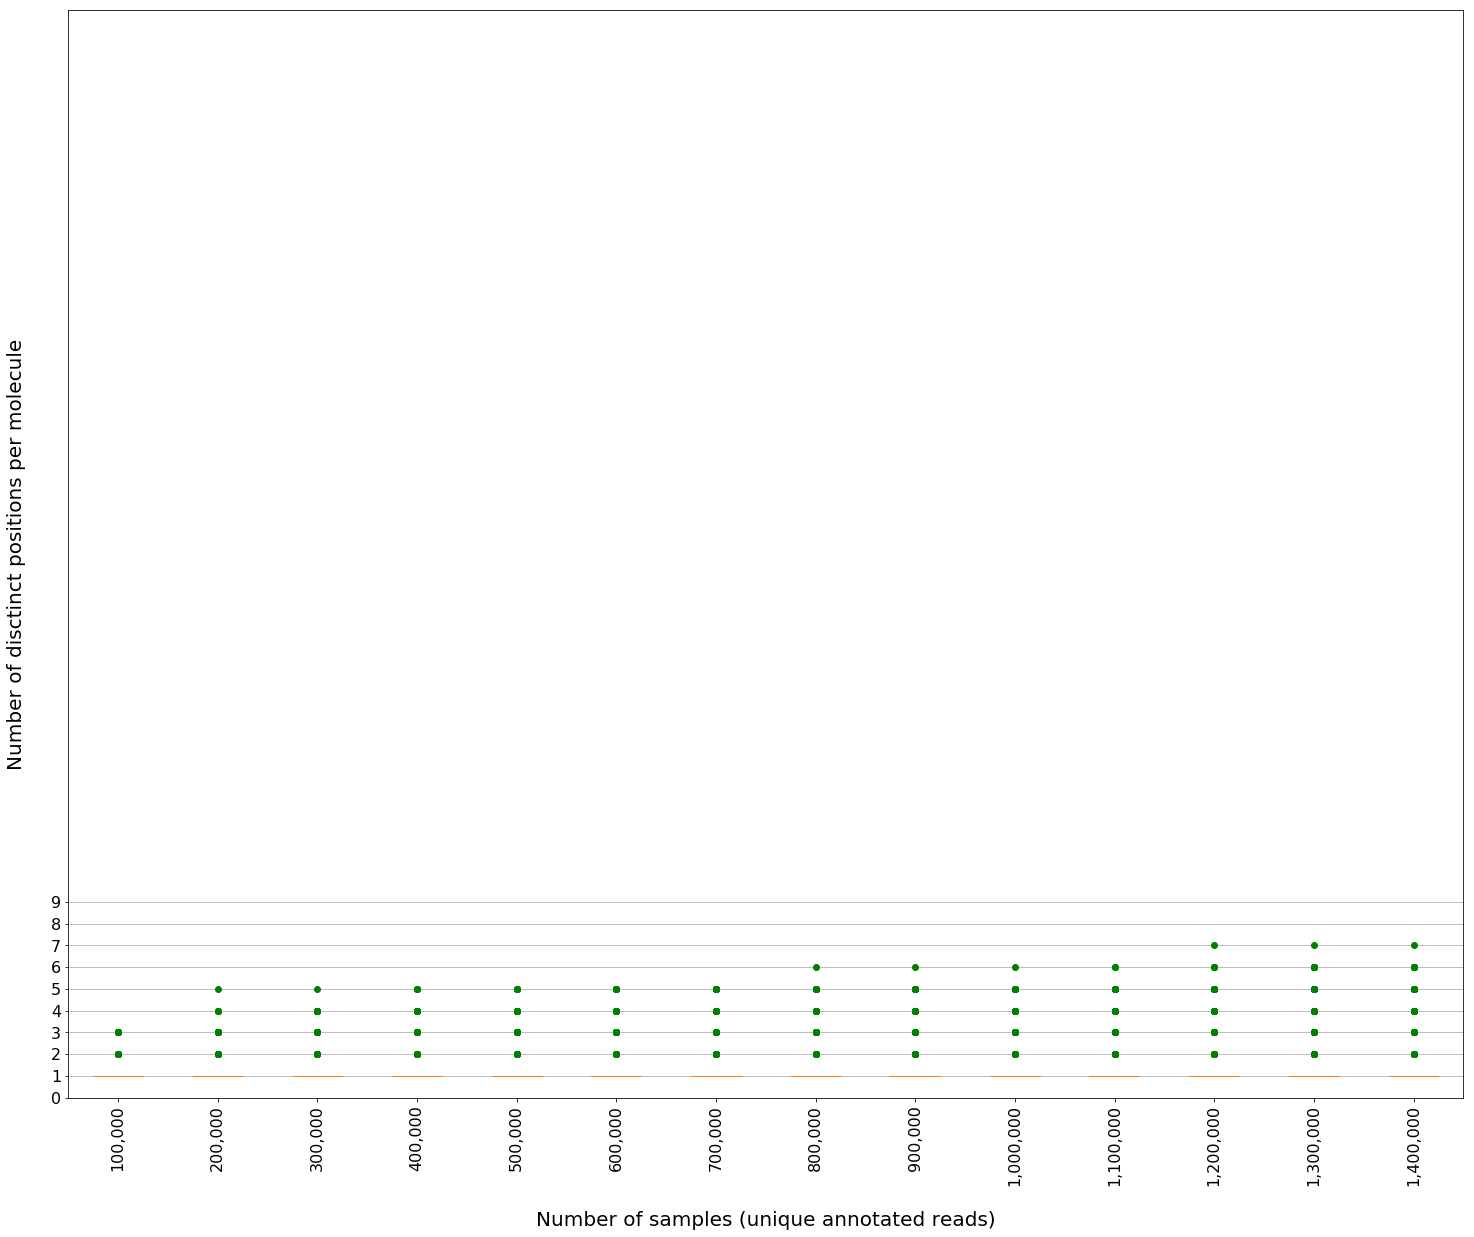

In [27]:
%%time

os.chdir("/data/parastou/UMI/data/MUS/MUS12/")
step_size = 100000
counter = 0

for in_file in glob.glob("*.bam"):
    if counter > 50:
        break
        
    db = umi_gene_db(in_file)
    shuffle(db)
    samples = []
    
    sat_plot_data = []
    for i in range(0, len(db), step_size):
        new_slice = [item for item in islice(db , i, i + step_size)]
        samples += new_slice
        # samples = random.sample(db, i)
        dist = different_positions(samples)
        sat_plot_data.append((i, dist))
    plot_sat_curve(in_file, sat_plot_data, step_size)
        
    counter += 1

In [65]:
%%time

os.chdir("/data/parastou/UMI/data/HG/AMLPDXdemux/")
step_size = 25000
counter = 0

for in_file in glob.glob("*.bam"):
    
    db = umi_gene_db(in_file)
    psamples = [psplit(item) for item in db]
    df = pd.DataFrame(psamples, columns = ['XG','POS'])
    dg = df.groupby(['XG'])['POS']
    
    ones = 0
    others = 0
    diff = {}
    amp_major_total = 0
    amp_others_total = 0
    
    for xg, pos in dg:
        
        l = len(pos)
        if l == 1:
            ones += 1
        else:
            others += l
            s = len(set(pos))
            if s in diff:
                diff[s] += l
            else:
                diff.update({s:l})
    '''            
    median_pos = max(diff.iteritems(), key = itemgetter(1))[1]
            
    for xg, pos in dg:
        if not len(pos)==1:
            if len(set(pos)) == major_pos:
                amp_major_total += len(pos)
            else:
                amp_others_total += len(pos)
    '''
                
    r_total = ones + others
    #r_amp_total = amp_major_total + amp_others_total
    
    prct_others = (float(others)/r_total) * 100
    #prct_rest = (float(amp_others_total)/r_amp_total) * 100
    
    print 'Sample : %s' % in_file
    print
    print 'Number of unamplified reads : %d' % ones
    print 'Number of amplified reads : %d ( %.2f %%)' % (others, prct_others)
    
    '''
    print 'Majority distinct pos : %d' % major_pos
    print 'Number of amplified reads with %d distinct position(s): %d' % (major_pos, amp_major_total)
    print 'Size of the rest of the population: %d ( %.2f %%)'  % (amp_others_total, prct_rest)
    '''
    print '-'*40
    print 

Sample : HGsample_AAACAT.bam

Number of unamplified reads : 9158
Number of amplified reads : 219257 ( 95.99 %)
----------------------------------------

Sample : HGsample_AAATCA.bam

Number of unamplified reads : 15418
Number of amplified reads : 111948 ( 87.89 %)
----------------------------------------

Sample : HGsample_AACATA.bam

Number of unamplified reads : 6227
Number of amplified reads : 97357 ( 93.99 %)
----------------------------------------

Sample : HGsample_AAGTTA.bam

Number of unamplified reads : 13787
Number of amplified reads : 149325 ( 91.55 %)
----------------------------------------

Sample : HGsample_AATATG.bam

Number of unamplified reads : 6922
Number of amplified reads : 131497 ( 95.00 %)
----------------------------------------

Sample : HGsample_AATGTA.bam

Number of unamplified reads : 5592
Number of amplified reads : 116890 ( 95.43 %)
----------------------------------------

Sample : HGsample_AATTTC.bam

Number of unamplified reads : 10124
Number of ampli

In [16]:
%%time

os.chdir("/data/parastou/UMI/data/HG/AMLPDXdemux/")

for in_file in glob.glob("*.bam"):
    
    st = pysam.AlignmentFile(in_file,"rb")
    st.reset()
    reads = st.fetch(until_eof=True)
    
    amplified = 0
    unamplified = 0
    
    xqs = []
    for r in reads:
        xm = r.get_tag('XM')
        qn = r.query_name
        xqs.append(xm + ':' + qn)
        
    df = pd.DataFrame(xqs, columns=['XM','QN'])
    dg = df.groupby(['XM'])['QN']
    
    for xm, group in dg:
        if len(group) ==1:
            unamplified += 1
        else:
            amplified += len(set(group))
            if not len(group)==len(set(group)):
                print list(group)
                
    r_total = amplified + unamplified
    
    prct_amplified = (float(amplified)/r_total) * 100
    
    print 'Sample : %s' % in_file
    print
    print 'Number of unamplified reads : %d' % unamplified
    print 'Number of amplified reads : %d ( %.2f %%)' % (amplified, prct_amplified)
    print '-'*40
    print 

ValueError: Shape of passed values is (1, 679800), indices imply (2, 679800)

In [14]:
in_file = '/data/parastou/UMI/data/HG/AMLPDXdemux/HGsample_AAACAT.bam'
st = pysam.AlignmentFile(in_file,"rb")
st.reset()
reads = st.fetch(until_eof=True)

In [15]:
xqs = []

for r in reads:
    print r.query_name

L183:338:CAGAAANXX:4:2207:4879:19302
L183:338:CAGAAANXX:4:1315:3276:29234
L183:338:CAGAAANXX:4:2111:3452:72055
L183:338:CAGAAANXX:4:2208:5708:22169
L183:338:CAGAAANXX:5:1115:10457:66772
L183:338:CAGAAANXX:5:1316:12881:40810
L183:338:CAGAAANXX:5:2202:12130:44290
L183:338:CAGAAANXX:5:2208:13718:85511
L183:338:CAGAAANXX:5:2310:16966:69745
L183:338:CAGAAANXX:6:1203:3741:76562
L183:338:CAGAAANXX:6:1209:8363:26008
L183:338:CAGAAANXX:6:1214:17777:26509
L183:338:CAGAAANXX:6:2106:11838:31922
L183:338:CAGAAANXX:6:2205:18644:46266
L183:338:CAGAAANXX:4:2114:14031:35493
L183:338:CAGAAANXX:6:2104:19547:25768
L183:338:CAGAAANXX:4:1109:6997:71286
L183:338:CAGAAANXX:6:2209:5179:26833
L183:338:CAGAAANXX:4:1115:9498:57635
L183:338:CAGAAANXX:4:1202:3559:15631
L183:338:CAGAAANXX:4:1207:6227:60347
L183:338:CAGAAANXX:4:1307:10942:11280
L183:338:CAGAAANXX:4:2107:10366:95699
L183:338:CAGAAANXX:4:2109:2677:90875
L183:338:CAGAAANXX:4:2211:13726:94501
L183:338:CAGAAANXX:4:2211:18985:64159
L183:338:CAGAAANXX:5:110

KeyboardInterrupt: 

In [73]:
%%time

os.chdir("/data/parastou/UMI/data/MUS/MUS12/")

for in_file in glob.glob("*.bam"):
    
    st = pysam.AlignmentFile(in_file,"rb")
    st.reset()
    reads = st.fetch(until_eof=True)
    
    amplified = 0
    unamplified = 0
    
    xqs = []
    for r in reads:
        xm = r.get_tag('XM')
        qn = r.query_name
        xqs.append((xm, qn))
        
    df = pd.DataFrame(xqs, columns=['XM','QN'])
    dg = df.groupby(['XM'])['QN']
    
    for xm, group in dg:
        if len(group) ==1:
            unamplified += 1
        else:
            amplified += len(set(group))
                
    r_total = amplified + unamplified
    
    prct_amplified = (float(amplified)/r_total) * 100
    
    print 'Sample : %s' % in_file
    print
    print 'Number of unamplified reads : %d' % unamplified
    print 'Number of amplified reads : %d ( %.2f %%)' % (amplified, prct_amplified)
    print '-'*40
    print 

Sample : sample_AAAACT.bam

Number of unamplified reads : 30314
Number of amplified reads : 18386567 ( 99.84 %)
----------------------------------------

Sample : sample_AAAGTT.bam

Number of unamplified reads : 17499
Number of amplified reads : 6026776 ( 99.71 %)
----------------------------------------



KeyboardInterrupt: 

In [ ]:
'''

bp = plt.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.sehttp://localhost:8888/notebooks/SaturationPlot.ipynb#tp(bp['fliers'], color='red', marker='+')


data = np.random.random((100, 5))
y = data.mean(axis=0)
x = np.random.random(y.size) * 10
x -= x.min()
x.sort()

# Plot a line between the means of each dataset
fig = plt.figure(figsize=(15,10))
fig.suptitle('Distribution of umi groups per genomic loci', fontsize=17)
plt.plot(x, y, 'b-')

# Save the default tick positions, so we can reset them...
locs, labels = plt.xticks() 

plt.boxplot(data, positions=x) #, notch=True)

# Reset the xtick locations.
plt.xticks(locs)
plt.show()
'''